In [1]:
## Catálogo das Abordagens
#  A1: Cadastro
#  A2: Medidas
#      A2.1: Medidas Importantes
#      A2.2: Select KBeast
#  A3: Estatística
#  A4: Doenças
#      A4.1: Select KBest
#  A5: Doenças sem Hipotensão e Normotenso
#  A6: Escolho Doença
#  A7: Categorias
#  A8: Extratificação Sexo Masculino
#  A9: Extratificação Sexo Feminino
#  A10: Sistólicas
#  A11: Diastólicas
#  A12: Medidas Mais Importantes

In [2]:
#bibliotecas pandas de leitura de arquivos
import pandas as pd
#biblioteca do kmeans
from sklearn.cluster import KMeans
import numpy as np
#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt
#caracter 
import re
#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math
from sklearn import svm

from IPython.display import Image
from pathlib import Path


#from sklearn_extra.cluster import KMedoids

In [3]:
# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"


In [4]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas

dataset = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv",sep=';', encoding="Latin1")
dataset_apos_tratamento = dataset

#dataset = dataset.drop ("Unnamed: 0", axis=1)
#for i in dataset.columns:
#    print(repr(i))
#

In [5]:
dataset

numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19149                 21786      1972-11-25       1   47.0   75.0    165   
19150                 21787      1970-10-19       1   49.0   90.0    183   
19151                 21788      1985-03-15       0   35.0   93.0    167   
19152                 21792      1952-04-21       0   68.0   64.0    160   
19153                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  sist 9:00  sist 9:15  ...  \
0      33.2  2018-09-10 12:25:23      105.0      108.0  ...   
1      29.4  2018-12-26 07:39:41      103.0      114.0  ...   
2      25.8  2018-12-26 08:06:19      147.0      148.0  ...   
3      24.2  2018-12-26 08:19:06      140.0      139.0  ...   
4      40.6  2018-12-26 08:26:59      113.0      110.0  ...   
...     ...                  ...        ...        ...  ...   
19149  27.5  2020-09-10 16:03:08      163.0      198.0  ...   
19150  26.9  2020-09-10 16:21:02      114.0      120.0  ...   
19151  33.3  2020-09-10 16:44:53      107.0      110.0  ...   
19152  25.0  2020-09-10 17:25:50       94.0      107.0  ...   
19153  30.9  2020-09-10 17:42:01      111.0      104.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19149                      116.0               12224.5                 9265.0   
19150                       85.0               10970.0                 6819.0   
19151                       62.0                9245.0                 4935.5   
19152                       68.0                8989.5                 5660.0   
19153                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19149          2439.0             474.5                18.66   
19150          3319.0             738.0                17.22   
19151          3556.0             713.5                14.36   
19152          2815.5             460.0                14.14   
19153          2400.5             612.0                13.92   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     11.36               11                34   
1                      6.65                9                23   
2                     13.01               19                19   
3                     10.34               21                 9   
4                     12.79               10                11   
...                     ...              ...               ...   
19149                 14.80               49                60   
19150                 13.67               32                27   
1

In [6]:
#!pip install scikit-learn-extra

In [7]:
############################### FUNÇÕES ##########################################

#Funções para calcular o melhor numero de cluster(grupos) que seu dataset gerar

def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=10)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [8]:
array  = list(np.arange(100) * 2 )
array.index(max(array)) + 2

101

In [9]:
#converter peso em float

#def Tratar_Peso(peso):    
#    
#    try:
#        if peso[-1] == ',' or peso[-1] == '.':
#            peso =  peso[:-1]
#    except:
#        pass
#    
#    
#    try:
#        peso = float(peso)
#    except:
#        peso = float(peso.replace(',','.'))
#    return peso
#
##converter altura
#def Tratar_Altura(altura):       
#       
#    altura = str(altura)
#    if re.match('\d,,\d', altura):
#        altura = altura.replace(',,','')
#    
#    try:
#        if altura[-1] == ',' or altura[-1] == '.' or  altura[-1] == ']':
#            altura =  altura[:-1]
#    except:
#        pass
#    
#    try:
#        altura = float(altura)
#    except:
#        altura = float(altura.replace(',','.'))     
#    
#    # convt 150.00 para 1.50
#    if altura >= 3:
#        altura = altura/100 
#    
#    
#    return altura
#
##calcular o IMC
#def IMC(peso,altura):  
#        
#    imc = float(peso) / (float(altura) ** 2)
#    
#    return np.round (imc, 1)
#
#
##Trocar  True para 1 e False para 0
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0
##
#def normaliza_float(n):
#    if isinstance(n, (float, int)):
#        return n
#    if isinstance(n, str):
#        if "," in n:
#            n = n.replace(",", ".")
#        if not n.replace(".", "").isdigit():
#            n = "".join(digito for digito in n if digito in "0123456789.")
#        n = n.replace("..", ".")
#        if not n or n.count(".") > 1:
#            n = float("nan")
#         # convt 150.00 para 1.50
#        n = float(n)
#        if n >= 3:
#            while 1:
#                if (n//10 == 0.0 or n//10 == 0):
#                    break
#                else:
#                    n = n/10 
#    return float(n)

In [10]:
dataset_apos_tratamento['IMC']

0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19149    27.5
19150    26.9
19151    33.3
19152    25.0
19153    30.9
Name: IMC, Length: 19154, dtype: float64

### Transforma Genero M = 1 e F = 0 

In [11]:
# transform Gender M and F to binary 

#limpa_coluna_genero = {"genero": {"M": True, "F": False}}
#controle = 1
#genero0 = dataset['genero']
#for i in range(len(genero0)):
#    if genero0.iloc[i] != 'M' and genero0.iloc[i] != 'F':
#        if controle == 1:
#            genero0.iloc[i] = 0
#            controle = 0
#        else:
#            genero0.iloc[i] = 1
#            controle = 1
#
#dataset_apos_tratamento['genero'] = genero0
#
#dataset_apos_tratamento = dataset_apos_tratamento.replace(limpa_coluna_genero)
#
#dataset_apos_tratamento["genero"] = dataset_apos_tratamento["genero"].astype(int)
##
##
#
genero_M_F = {"genero": {1: "M", 0: "F"}}

##  Tratar os dados para colocá-los em Categorias

In [12]:
# Cálculo do Indice de Massa Corporal:
#         IMC entre 18,0 e 24,9 Kg/m2: normal
#         IMC menor do que 18,0 Kg/m2: baixo peso
#         IMC entre 25,0 e 29,9 Kg/m2: sobrepeso 
#         IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I 
#         IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II 
#         IMC maior do que 40,0 Kg/m2: obesidade grau III  

def faixas_imc(imc):

    classes = ["Peso normal","Sobrepeso", "Obesidade"]
    intervalos = [(0, 25),(25, 30),(30, 1000)]
#    classes = ["Baixo Peso","Normal","Sobrepeso","Obesidade grau I","Obesidade grau II","Obesidade Grau III"]
#    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]

def faixas_imc_13(imc):
    classes = ["Peso normal", "Obesidade"]
    intervalos = [(0, 30),(30, 1000)]

    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
        

def faixas_imc_classe(imc):
    classes = [1, 2, 3]
    intervalos = [(0, 25),(25, 30),(30, 1000)]
#    classes = [1, 2, 3, 4, 5, 6]
#    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
    
def faixas_imc_classe_13(imc):
    classes = [1, 2]
    intervalos = [(0, 30),(30, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
    
def faixas_etarias(idade):
    classes = ["Adultos","Meia-idade","Idoso"]
    intervalos = [(0, 50),(50, 65),(65, 200)]
#    classes = ["Jovens","Adultos","Meia-idade","Idoso", "Ancião","Velhice extrema"]
#    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
def faixas_etarias_13(idade):
    classes = ["Adultos","Idoso"]
    intervalos = [(0, 65),(65, 200)]
 
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
        
def faixas_etarias_classe(idade):
    classes = [1, 2, 3]
    intervalos = [(0, 50),(50, 65),(65, 200)]    
#    classes = [1, 2, 3, 4, 5, 6]
#    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
def faixas_etarias_classe_13(idade):
    classes = [1, 2]
    intervalos = [(0, 65),(65, 200)]
      
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

In [13]:
#dataset_apos_tratamento['idade'] = dataset_apos_tratamento['idade'].fillna(-1)
#dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['idade'] != -1]

In [14]:
#dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['altura_normalizada'] <= 2.5]
#dataset_apos_tratamento = pd.concat([dataset_apos_tratamento.loc[:,'numero_identificacao':'altura'],
#                                     dataset_apos_tratamento['IMC'],
#                                    dataset_apos_tratamento.loc[:,'data_exame':'Picos Diastolica']],
#                                    axis=1)
#
#print(len(dataset_apos_tratamento))
## Dataset com IMC e tratamento de Nans com a política de normalização
#dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_completos_tratados.csv", 
#                        sep=";", encoding="latin1", index=False)
#
#dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_com_tab.csv", 
#                        sep="\t", encoding="latin1", index=False)

In [15]:
dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat']

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19149        True              False               False     True   
19150        True              False               False    False   
19151        True              False               False    False   
19152        True              False               False    False   
19153        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19149        False            False            False           True   False   
19150         True            False            False          False   False   
19151         True            False            False          False   False   
19152        False             True            False          False   False   
19153        False            False             True          False   False   

       Whitecoat  
0          False  
1          False  
2           True  
3           True  
4          False  
...          ...  
19149       True  
19150       True  
19151       True  
19152      False  
19153       True  

[19154 rows x 10 columns]

In [16]:
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

In [17]:
dataset_por_classes = pd.DataFrame()
dataset_por_classes['numero_identificacao'] = dataset_apos_tratamento['numero_identificacao']
dataset_por_classes['genero'] = dataset_apos_tratamento['genero']
dataset_por_classes['idade'] = dataset_apos_tratamento['idade'].apply(faixas_etarias_classe)
dataset_por_classes['IMC'] = dataset_apos_tratamento['IMC'].apply(faixas_imc_classe)
dataset_por_classes = pd.concat([dataset_por_classes, dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)
for doenca in list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns):
    dataset_por_classes[doenca] = dataset_apos_tratamento[doenca].apply(verdadeiro_falso)
dataset_por_classes

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      3    3      105.0      108.0   
1                         5       1      3    2      103.0      114.0   
2                         6       1      1    2      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    3      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19149                 21786       1      1    2      163.0      198.0   
19150                 21787       1      1    2      114.0      120.0   
19151                 21788       0      1    3      107.0      110.0   
19152                 21792       0      3    2       94.0      107.0   
19153                 21793       1      1    3      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0  ...           1   
1           82.0      104.0        98.0       106.0  ...           1   
2          156.0      140.0       130.0       132.0  ...           1   
3          142.0      137.0       135.0       177.0  ...           1   
4          101.0      108.0       111.0       111.0  ...           1   
...          ...        ...         ...         ...  ...         ...   
19149      172.0      148.0       161.0       156.0  ...           1   
19150      164.0      116.0       119.0       126.0  ...           1   
19151      103.0      105.0       108.0       111.0  ...           1   
19152      112.0      124.0       120.0        94.0  ...           1   
19153      103.0      101.0        97.0       110.0  ...           1   

       Sistolica Isolada  Diastolica Isolada  Dipping  Non Dipping  \
0                      0                   0        0            0   
1                      0                   0        0            0   
2                      0                   0        0            1   
3                      0                   0        1            0   
4                      0                   0        1            0   
...                  ...                 ...      ...          ...   
19149                  0                   0        1            0   
19150                  0                   0        0            1   
19151                  0                   0        0            1   
19152                  0                   0        0            0   
19153                  0                   0        0            0   

       Extreme Dipping  Reverse Dipping  Morning Surge  Masked  Whitecoat  
0                    0                1              0       0          0  
1                    0                1              0       0          0  
2                    0                0              0       0          1  
3                    0                0              0       0          1  
4                    0                0              0       0          0  
...                ...              ...            ...     ...        ...  
19149                0                0              1       0          1  
19150                0                0              0       0          1  
19151                0                0              0       0          1  
19152                1                0              0       0          0  
19153                0                1              0       0          1  

[19154 rows x 178 columns]

In [18]:
dataset_apos_tratamento['IMC'].unique

<bound method Series.unique of 0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19149    27.5
19150    26.9
19151    33.3
19152    25.0
19153    30.9
Name: IMC, Length: 19154, dtype: float64>

In [19]:
dataset_apos_tratamento

numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19149                 21786      1972-11-25       1   47.0   75.0    165   
19150                 21787      1970-10-19       1   49.0   90.0    183   
19151                 21788      1985-03-15       0   35.0   93.0    167   
19152                 21792      1952-04-21       0   68.0   64.0    160   
19153                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  sist 9:00  sist 9:15  ...  \
0      33.2  2018-09-10 12:25:23      105.0      108.0  ...   
1      29.4  2018-12-26 07:39:41      103.0      114.0  ...   
2      25.8  2018-12-26 08:06:19      147.0      148.0  ...   
3      24.2  2018-12-26 08:19:06      140.0      139.0  ...   
4      40.6  2018-12-26 08:26:59      113.0      110.0  ...   
...     ...                  ...        ...        ...  ...   
19149  27.5  2020-09-10 16:03:08      163.0      198.0  ...   
19150  26.9  2020-09-10 16:21:02      114.0      120.0  ...   
19151  33.3  2020-09-10 16:44:53      107.0      110.0  ...   
19152  25.0  2020-09-10 17:25:50       94.0      107.0  ...   
19153  30.9  2020-09-10 17:42:01      111.0      104.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19149                      116.0               12224.5                 9265.0   
19150                       85.0               10970.0                 6819.0   
19151                       62.0                9245.0                 4935.5   
19152                       68.0                8989.5                 5660.0   
19153                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19149          2439.0             474.5                18.66   
19150          3319.0             738.0                17.22   
19151          3556.0             713.5                14.36   
19152          2815.5             460.0                14.14   
19153          2400.5             612.0                13.92   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     11.36               11                34   
1                      6.65                9                23   
2                     13.01               19                19   
3                     10.34               21                 9   
4                     12.79               10                11   
...                     ...              ...               ...   
19149                 14.80               49                60   
19150                 13.67               32                27   
1

In [20]:
# Dataset com cadastro, IMC e medidas
dataset_cadastro = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                             dataset_apos_tratamento['genero'],dataset_apos_tratamento['idade'],
                             dataset_apos_tratamento['IMC'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com as medidas
dataset_medidas = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com numero identificação e estatísticas
dataset_estatistica = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h']],axis=1)

# Dataset com numero identificação e doenças
dataset_doenca = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Hipotensao':'Normotenso']],axis=1)

dataset_masc = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 1]

dataset_masc_medidas =  pd.concat([dataset_masc['numero_identificacao'],
                     dataset_masc.loc[:,'sist 9:00':'diast 8:45']],axis=1)


dataset_fem = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 0]

dataset_fem_medidas =  pd.concat([dataset_fem['numero_identificacao'],
                     dataset_fem.loc[:,'sist 9:00':'diast 8:45']],axis=1)

In [21]:
print(f'Quantidade F: {len(dataset_fem_medidas)}\nQuantidade M: {len(dataset_masc_medidas)}')

Quantidade F: 10447
Quantidade M: 8707


# Abordagem 1: Cadastro e Medidas como entrada

In [22]:
dataset_cadastro

numero_identificacao  genero  idade   IMC  sist 9:00  sist 9:15  \
0                         4       1   94.0  33.2      105.0      108.0   
1                         5       1   70.0  29.4      103.0      114.0   
2                         6       1   19.0  25.8      147.0      148.0   
3                         7       0   40.0  24.2      140.0      139.0   
4                         8       1   28.0  40.6      113.0      110.0   
...                     ...     ...    ...   ...        ...        ...   
19149                 21786       1   47.0  27.5      163.0      198.0   
19150                 21787       1   49.0  26.9      114.0      120.0   
19151                 21788       0   35.0  33.3      107.0      110.0   
19152                 21792       0   68.0  25.0       94.0      107.0   
19153                 21793       1   49.0  30.9      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  diast 6:30  \
0          116.0      104.0       106.0        98.0  ...        41.0   
1           82.0      104.0        98.0       106.0  ...        74.0   
2          156.0      140.0       130.0       132.0  ...        80.0   
3          142.0      137.0       135.0       177.0  ...        49.0   
4          101.0      108.0       111.0       111.0  ...        64.0   
...          ...        ...         ...         ...  ...         ...   
19149      172.0      148.0       161.0       156.0  ...       102.0   
19150      164.0      116.0       119.0       126.0  ...        87.0   
19151      103.0      105.0       108.0       111.0  ...        49.0   
19152      112.0      124.0       120.0        94.0  ...        63.0   
19153      103.0      101.0        97.0       110.0  ...        67.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
0            46.0        51.0        56.0        61.0        67.0        61.0   
1            74.0        74.0        70.0        67.0        63.0        60.0   
2            86.0        93.0        91.0        89.0        87.0        86.0   
3            56.0        62.0        83.0       104.0        99.0        94.0   
4            73.0        83.0        93.0        68.0        91.0        87.0   
...           ...         ...         ...         ...         ...         ...   
19149       114.0       126.0       125.0       124.0       123.0       123.0   
19150        73.0        59.0        74.0        68.0        86.0        96.0   
19151        50.0        50.0        53.0        52.0        62.0        68.0   
19152        63.0        64.0        76.0        72.0        69.0        75.0   
19153        68.0        69.0        71.0        73.0        56.0        57.0   

       diast 8:15  diast 8:30  diast 8:45  
0            69.0        62.0        51.0  
1            74.0        70.0        67.0  
2            87.0        82.0        82.0  
3            89.0        90.0        72.0  
4            84.0        81.0        72.0  
...           ...         ...         ...  
19149       121.0       119.0       123.0  
19150       107.0       106.0        93.0  
19151        61.0        64.0        60.0  
19152        74.0        69.0        67.0  
19153        65.0        68.0        82.0  

[19154 rows x 168 columns]

In [23]:
#selecionando variaveis de medidad : sist 9:00 a diast 8:45
#campos sist e diast

#   Gera uma lista com cabeçalhos
ls_cadastro = list(dataset_cadastro.loc[:,'genero':'diast 8:45'].columns)

dados_cadastro_sem_id = dataset_cadastro.loc[:,'genero':'diast 8:45']
#dados_sist_diast = dados_sist_diast.drop(['peso','altura','data_exame'],axis=1)

dados_cadastro_sem_id.head(5)

genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0       1   94.0  33.2      105.0      108.0      116.0      104.0   
1       1   70.0  29.4      103.0      114.0       82.0      104.0   
2       1   19.0  25.8      147.0      148.0      156.0      140.0   
3       0   40.0  24.2      140.0      139.0      142.0      137.0   
4       1   28.0  40.6      113.0      110.0      101.0      108.0   

   sist 10:00  sist 10:15  sist 10:30  ...  diast 6:30  diast 6:45  \
0       106.0        98.0       102.0  ...        41.0        46.0   
1        98.0       106.0       108.0  ...        74.0        74.0   
2       130.0       132.0       121.0  ...        80.0        86.0   
3       135.0       177.0       148.0  ...        49.0        56.0   
4       111.0       111.0       114.0  ...        64.0        73.0   

   diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  \
0        51.0        56.0        61.0        67.0        61.0        69.0   
1        74.0        70.0        67.0        63.0        60.0        74.0   
2        93.0        91.0        89.0        87.0        86.0        87.0   
3        62.0        83.0       104.0        99.0        94.0        89.0   
4        83.0        93.0        68.0        91.0        87.0        84.0   

   diast 8:30  diast 8:45  
0        62.0        51.0  
1        70.0        67.0  
2        82.0        82.0  
3        90.0        72.0  
4        81.0        72.0  

[5 rows x 167 columns]

## Trata nulos, quando houver

In [24]:
#  ****** trocar a variável de dados_cadastro_sem_id  para  dados_cadastro_sem_nan

#dados_medidas_sem_nan = dados_medidas.fillna(0)

#  Retirar a linha que contém NaN em alguma coluna 
# dados_cadastro_sem_nan = dados_cadastro
# ls_cadastro = list(dados_cadastro_sem_nan.columns)

## Abordagem 1: Número de Clusters gerado pelo k-Means

In [25]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_cadastro = calculate_wcss(dados_cadastro_sem_id)
num_otimo_clusters_cadastro = optimal_number_of_clusters(sum_of_squares_cadastro)
num_otimo_clusters_cadastro

Wall time: 40.7 s


7

In [26]:
#convertendo os dados para a clusterização
dados_cadastro_array = np.array(dados_cadastro_sem_id)

In [27]:
#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
kmeans_cadastro = KMeans(n_clusters=num_otimo_clusters_cadastro, random_state=42).fit(dados_cadastro_array)

In [28]:
#listar os grupos 
grupos_cadastro = kmeans_cadastro.fit_predict(dados_cadastro_array)

In [29]:
#incluir grupos nos dados de sist e diast
dados_cadastro_sem_id['grupo'] = grupos_cadastro
dados_cadastro_sem_id['grupo'] = dados_cadastro_sem_id['grupo'] + 1
dados_cadastro_sem_id


genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0           1   94.0  33.2      105.0      108.0      116.0      104.0   
1           1   70.0  29.4      103.0      114.0       82.0      104.0   
2           1   19.0  25.8      147.0      148.0      156.0      140.0   
3           0   40.0  24.2      140.0      139.0      142.0      137.0   
4           1   28.0  40.6      113.0      110.0      101.0      108.0   
...       ...    ...   ...        ...        ...        ...        ...   
19149       1   47.0  27.5      163.0      198.0      172.0      148.0   
19150       1   49.0  26.9      114.0      120.0      164.0      116.0   
19151       0   35.0  33.3      107.0      110.0      103.0      105.0   
19152       0   68.0  25.0       94.0      107.0      112.0      124.0   
19153       1   49.0  30.9      111.0      104.0      103.0      101.0   

       sist 10:00  sist 10:15  sist 10:30  ...  diast 6:45  diast 7:00  \
0           106.0        98.0       102.0  ...        46.0        51.0   
1            98.0       106.0       108.0  ...        74.0        74.0   
2           130.0       132.0       121.0  ...        86.0        93.0   
3           135.0       177.0       148.0  ...        56.0        62.0   
4           111.0       111.0       114.0  ...        73.0        83.0   
...           ...         ...         ...  ...         ...         ...   
19149       161.0       156.0       156.0  ...       114.0       126.0   
19150       119.0       126.0       123.0  ...        73.0        59.0   
19151       108.0       111.0       114.0  ...        50.0        50.0   
19152       120.0        94.0       102.0  ...        63.0        64.0   
19153        97.0       110.0       111.0  ...        68.0        69.0   

       diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  diast 8:30  \
0            56.0        61.0        67.0        61.0        69.0        62.0   
1            70.0        67.0        63.0        60.0        74.0        70.0   
2            91.0        89.0        87.0        86.0        87.0        82.0   
3            83.0       104.0        99.0        94.0        89.0        90.0   
4            93.0        68.0        91.0        87.0        84.0        81.0   
...           ...         ...         ...         ...         ...         ...   
19149       125.0       124.0       123.0       123.0       121.0       119.0   
19150        74.0        68.0        86.0        96.0       107.0       106.0   
19151        53.0        52.0        62.0        68.0        61.0        64.0   
19152        76.0        72.0        69.0        75.0        74.0        69.0   
19153        71.0        73.0        56.0        57.0        65.0        68.0   

       diast 8:45  grupo  
0            51.0      2  
1            67.0      7  
2            82.0      1  
3            72.0      1  
4            72.0      5  
...           ...    ...  
19149       123.0      3  
19150        93.0      4  
19151        60.0      7  
19152        67.0      5  
19153        82.0      6  

[19154 rows x 168 columns]

## Abordagem 1: O método Elbow

### Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico

### https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

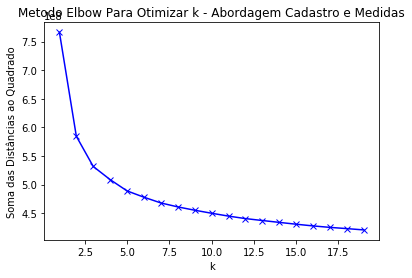

Wall time: 85 ms


In [30]:
#metodo de Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dados_cadastro_array)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Cadastro e Medidas')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_cadastro.svg', format="svg")
%time plt.show()

In [31]:
#fig.savefig('D:\Projeto_PA\\Projeto_PA_validado\\KMeansRandom\\graficos\\grafico_metodoelbow_medidas.svg', format='svg')
#plt.savefig(DIR_NMF / f'NMF_classificado_{grupo}.svg',format="svg")
#fig.savefig('diastolica_sistolica/diast_sist_elbow.png', format='png')


## Abordagem 1: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.2043085925413768
Para n_clusters = 3 O score_silhouette medio e : 0.1269770175028092
Para n_clusters = 4 O score_silhouette medio e : 0.08190916093403146
Para n_clusters = 5 O score_silhouette medio e : 0.07795837635947472
Para n_clusters = 6 O score_silhouette medio e : 0.06072372960838294
Para n_clusters = 7 O score_silhouette medio e : 0.057957893180676026
Para n_clusters = 8 O score_silhouette medio e : 0.05459936802221203


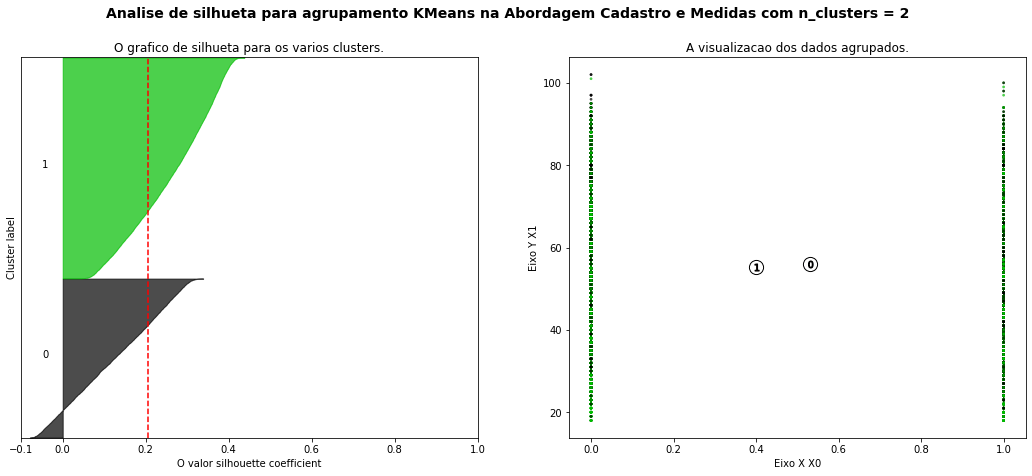

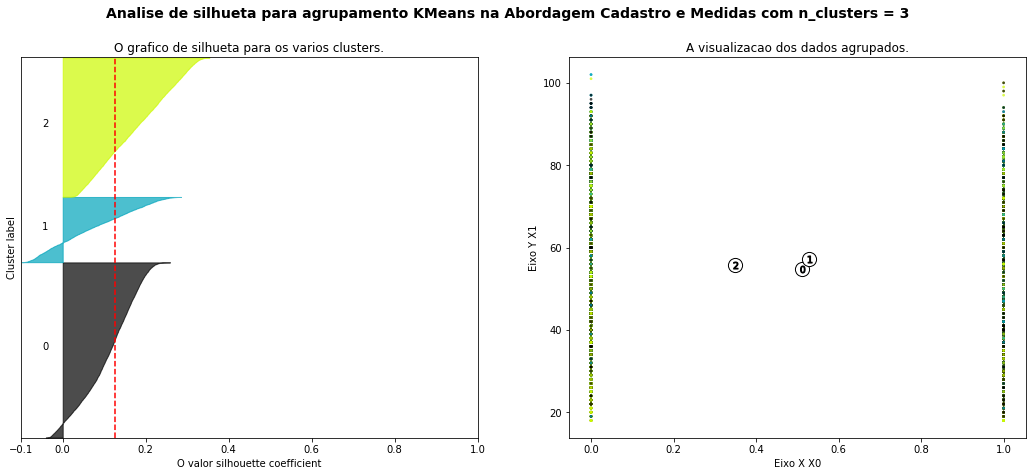

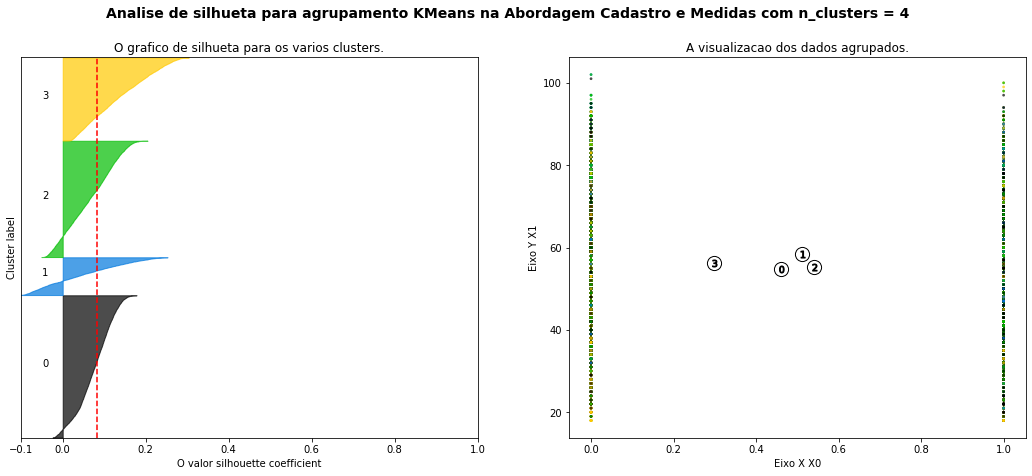

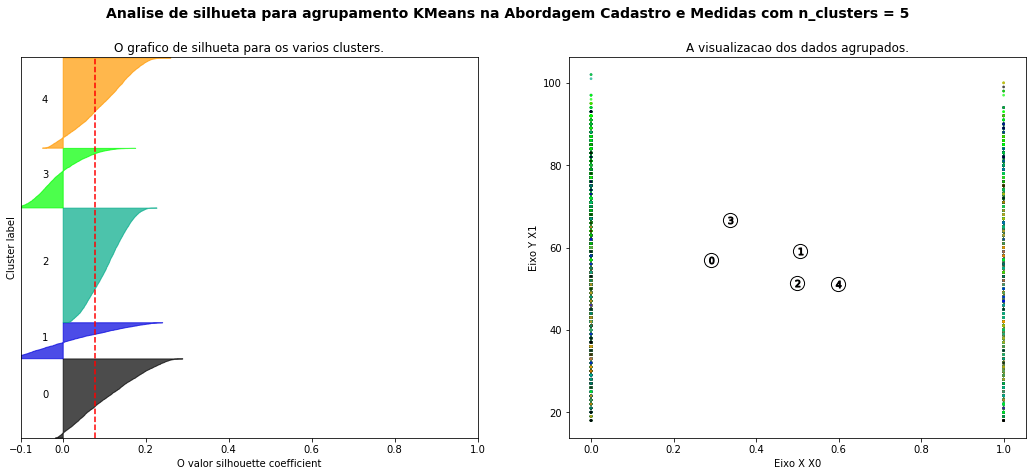

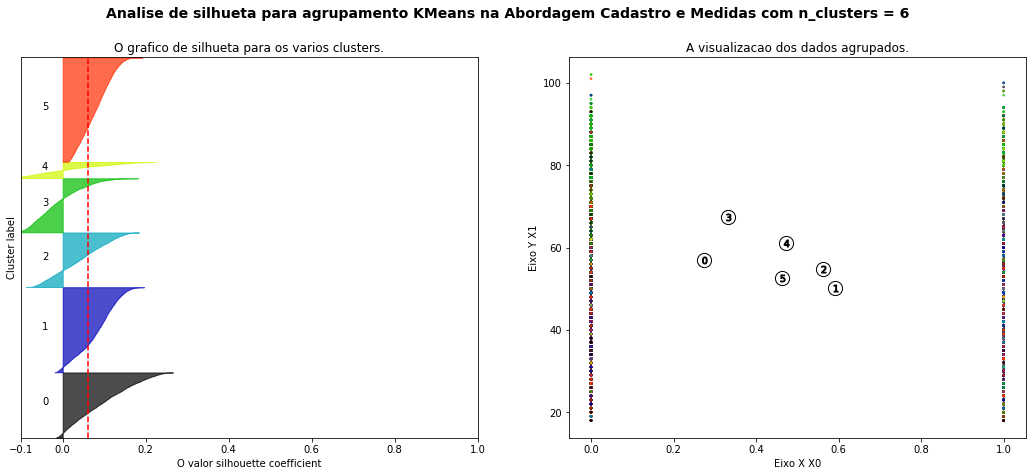

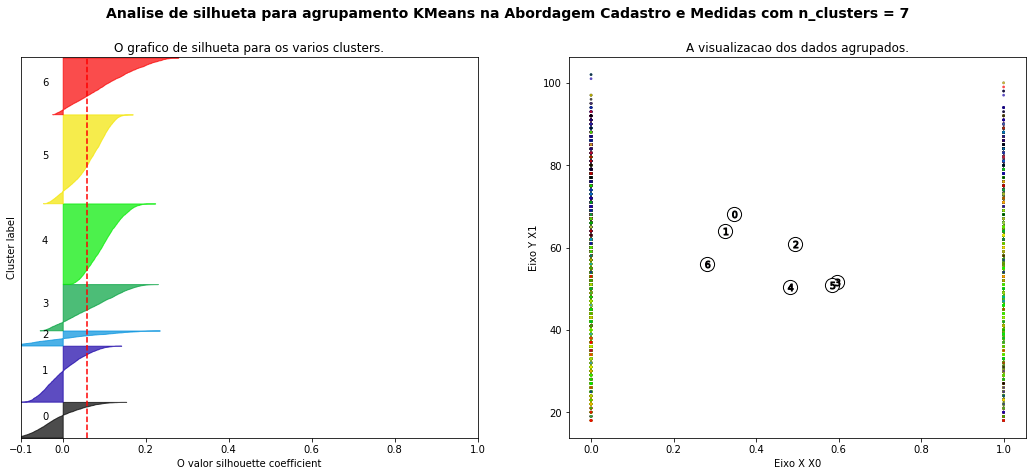

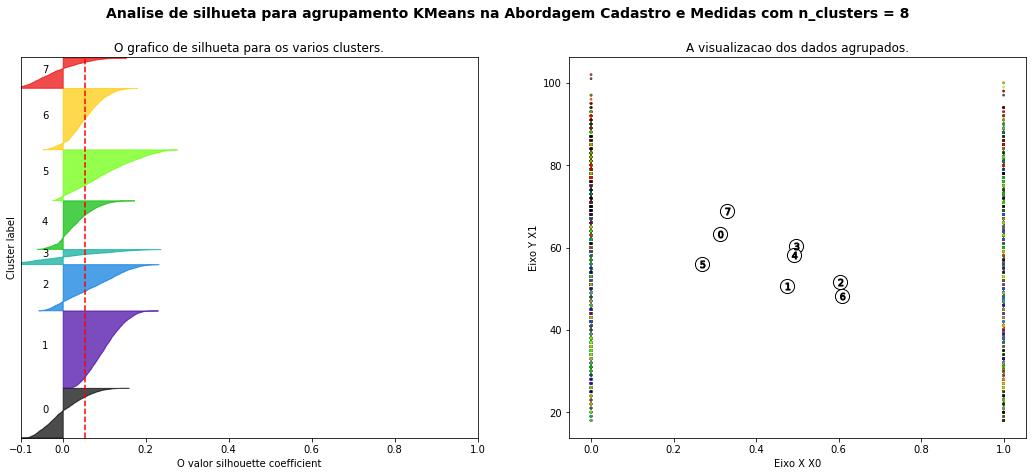

In [32]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dados_cadastro_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dados_cadastro_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dados_cadastro_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dados_cadastro_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dados_cadastro_array[:, 0], dados_cadastro_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans na Abordagem Cadastro e Medidas "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_cadastro_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando 

In [33]:
#dataset com grupos e com os dados de cadastro e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estaitsticos, 11 doenças em cada grupo 
dataset_s_d = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
dataset_s_d['IMC'] = dataset_cadastro['IMC']
dataset_s_d['grupo'] = grupos_cadastro
dataset_s_d = pd.concat([dataset_s_d,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_s_d

# Salva dataset com dados completos após o K-Means com abordagem 1 (cadastro e medidas)
dataset_s_d.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

In [34]:
dataset_s_d.head()

numero_identificacao data_nascimento  genero  idade   peso altura   IMC  \
0                     4      1923-10-05       1   94.0   85.0    160  33.2   
1                     5      1948-10-07       1   70.0   80.0    165  29.4   
2                     6      1999-03-23       1   19.0  100.0    197  25.8   
3                     7      1978-01-26       0   40.0   65.0   1,64  24.2   
4                     8      1990-03-07       1   28.0  120.0    172  40.6   

   grupo  sist 9:00  sist 9:15  ...  Mediana Sistolica em 24h  \
0      1      105.0      108.0  ...                     118.5   
1      6      103.0      114.0  ...                     106.0   
2      0      147.0      148.0  ...                     133.0   
3      0      140.0      139.0  ...                     131.0   
4      4      113.0      110.0  ...                     115.0   

   Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                       59.0                9545.5                 4902.0   
1                       62.0                8586.5                 5034.5   
2                       79.0               10674.0                 6154.0   
3                       80.0               10679.5                 6420.5   
4                       78.0                9141.5                 6118.0   

   AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0          3748.0             841.5                16.52   
1          2915.0             606.0                 7.51   
2          3721.0             751.5                12.70   
3          3642.0             602.5                16.13   
4          2405.0             566.0                12.27   

   DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  
0                 11.36               11                34  
1                  6.65                9                23  
2                 13.01               19                19  
3                 10.34               21                 9  
4                 12.79               10                11  

[5 rows x 209 columns]

## Abordagem 1: Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
#parametro simples do modelo
%time random_forest_cadastro = RandomForestClassifier(n_estimators=50)

Wall time: 0 ns


In [37]:
#base para modelo

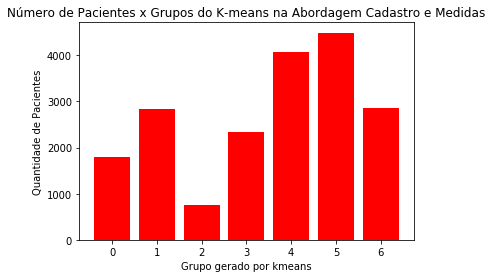

In [38]:
classes = []
qtds = []

contagem = Counter(grupos_cadastro)

for i in range(0,num_otimo_clusters_cadastro):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Cadastro e Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [39]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dados_cadastro_array, grupos_cadastro, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dados_cadastro_array, grupos_cadastro, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [40]:
#treino
random_forest_cadastro.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 1: VALIDAÇÃO

In [41]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_cadastro.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [42]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [43]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3     4     5     6
0  1058     0    0     0     0     0     0
1     0  1749    0     0     0     0     0
2     0     0  456     0     0     0     0
3     0     0    0  1370     0     0     0
4     0     0    0     0  2467     0     0
5     0     0    0     0     0  2704     0
6     0     0    0     0     0     0  1688

#### Abordagem 1: TESTE

In [44]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_cadastro.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [45]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9107282693813625 - Recall: 0.8889321883955436 - F1 Score: 0.904153853535416


In [46]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2    3     4     5     6
0  622   44    0   21     0    60     0
1   12  953    0    0    61    28    28
2   17    0  239   47     0     0     0
3   11    0    2  876     0    77     0
4    0   28    0    0  1494    54    23
5   10   12    0   14    48  1703     0
6    0   26    0    0    61     0  1091

In [47]:
dataset_s_d.describe()
dados_cadastro_array.shape
dados_cadastro_sem_id

genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0           1   94.0  33.2      105.0      108.0      116.0      104.0   
1           1   70.0  29.4      103.0      114.0       82.0      104.0   
2           1   19.0  25.8      147.0      148.0      156.0      140.0   
3           0   40.0  24.2      140.0      139.0      142.0      137.0   
4           1   28.0  40.6      113.0      110.0      101.0      108.0   
...       ...    ...   ...        ...        ...        ...        ...   
19149       1   47.0  27.5      163.0      198.0      172.0      148.0   
19150       1   49.0  26.9      114.0      120.0      164.0      116.0   
19151       0   35.0  33.3      107.0      110.0      103.0      105.0   
19152       0   68.0  25.0       94.0      107.0      112.0      124.0   
19153       1   49.0  30.9      111.0      104.0      103.0      101.0   

       sist 10:00  sist 10:15  sist 10:30  ...  diast 6:45  diast 7:00  \
0           106.0        98.0       102.0  ...        46.0        51.0   
1            98.0       106.0       108.0  ...        74.0        74.0   
2           130.0       132.0       121.0  ...        86.0        93.0   
3           135.0       177.0       148.0  ...        56.0        62.0   
4           111.0       111.0       114.0  ...        73.0        83.0   
...           ...         ...         ...  ...         ...         ...   
19149       161.0       156.0       156.0  ...       114.0       126.0   
19150       119.0       126.0       123.0  ...        73.0        59.0   
19151       108.0       111.0       114.0  ...        50.0        50.0   
19152       120.0        94.0       102.0  ...        63.0        64.0   
19153        97.0       110.0       111.0  ...        68.0        69.0   

       diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  diast 8:30  \
0            56.0        61.0        67.0        61.0        69.0        62.0   
1            70.0        67.0        63.0        60.0        74.0        70.0   
2            91.0        89.0        87.0        86.0        87.0        82.0   
3            83.0       104.0        99.0        94.0        89.0        90.0   
4            93.0        68.0        91.0        87.0        84.0        81.0   
...           ...         ...         ...         ...         ...         ...   
19149       125.0       124.0       123.0       123.0       121.0       119.0   
19150        74.0        68.0        86.0        96.0       107.0       106.0   
19151        53.0        52.0        62.0        68.0        61.0        64.0   
19152        76.0        72.0        69.0        75.0        74.0        69.0   
19153        71.0        73.0        56.0        57.0        65.0        68.0   

       diast 8:45  grupo  
0            51.0      2  
1            67.0      7  
2            82.0      1  
3            72.0      1  
4            72.0      5  
...           ...    ...  
19149       123.0      3  
19150        93.0      4  
19151        60.0      7  
19152        67.0      5  
19153        82.0      6  

[19154 rows x 168 columns]

In [48]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_s_d, grupos_cadastro, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_s_d, grupos_cadastro, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 1: Importância das Features Random Forest

In [49]:
len(ls_cadastro), len(random_forest_cadastro.feature_importances_)

(167, 167)

In [50]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_cadastro,'importance':np.round(random_forest_cadastro.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

#importances.to_excel('diastolica_sistolica/features_sisto_diasto.xlsx')

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
74     sist 6:15       0.019
76     sist 6:45       0.018
89   diast 10:00       0.011
92   diast 10:45       0.011
49    sist 20:30       0.011
..           ...         ...
2            IMC       0.002
145   diast 1:00       0.002
157   diast 6:30       0.002
147   diast 2:00       0.002
0         genero       0.000

[167 rows x 2 columns]

# Abordagem 2: Medidas como entrada

In [51]:
#  Arquivo salvo para servir de entrada ao K-medoids na abordagem Medidas
#

dataset_medidas.to_csv('D:/Projeto_PA/Projeto_PA_validado/KMedoids/centroide/kmedoids_pacientes_abordagem_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

In [52]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45

#   Gera uma lista com cabeçalhos
ls_sist_diast = list(dataset_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dados_medidas_sem_id = dataset_medidas.loc[:,'sist 9:00':'diast 8:45']

#dados_medidas_sem_id.head(5)
dados_medidas_sem_id.loc[1:70]


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
1       103.0      114.0       82.0      104.0        98.0       106.0   
2       147.0      148.0      156.0      140.0       130.0       132.0   
3       140.0      139.0      142.0      137.0       135.0       177.0   
4       113.0      110.0      101.0      108.0       111.0       111.0   
5       152.0      152.0      152.0      152.0       154.0       138.0   
..        ...        ...        ...        ...         ...         ...   
66       80.0       80.0       85.0       96.0       106.0       105.0   
67      113.0      119.0      120.0      122.0       117.0       122.0   
68      154.0      142.0      123.0      125.0       111.0       113.0   
69      118.0      122.0      116.0      115.0        84.0       102.0   
70      146.0      162.0      108.0      112.0       117.0       128.0   

    sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
1        108.0       107.0       109.0       100.0  ...        74.0   
2        121.0       113.0       149.0       128.0  ...        80.0   
3        148.0       152.0       135.0       136.0  ...        49.0   
4        114.0       115.0       113.0       112.0  ...        64.0   
5        137.0       152.0        95.0       117.0  ...        67.0   
..         ...         ...         ...         ...  ...         ...   
66       103.0       105.0       104.0       100.0  ...        59.0   
67       118.0       122.0       126.0       133.0  ...        85.0   
68       114.0       118.0       113.0       121.0  ...        67.0   
69       120.0       118.0       116.0       115.0  ...        68.0   
70       128.0       127.0       126.0       137.0  ...        76.0   

    diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
1         74.0        74.0        70.0        67.0        63.0        60.0   
2         86.0        93.0        91.0        89.0        87.0        86.0   
3         56.0        62.0        83.0       104.0        99.0        94.0   
4         73.0        83.0        93.0        68.0        91.0        87.0   
5         94.0       120.0       109.0       109.0       110.0       111.0   
..         ...         ...         ...         ...         ...         ...   
66        60.0        61.0        60.0        60.0        55.0        61.0   
67        85.0        85.0        86.0        87.0        62.0        63.0   
68        78.0        89.0        97.0        82.0        87.0        96.0   
69        68.0        67.0        56.0        62.0        66.0        73.0   
70        80.0        84.0        73.0        71.0        71.0        80.0   

    diast 8:15  diast 8:30  diast 8:45  
1         74.0        70.0        67.0  
2         87.0        82.0        82.0  
3         89.0        90.0        72.0  
4         84.0        81.0        72.0  
5        112.0       114.0       115.0  
..         ...         ...         ...  
66        47.0        49.0        45.0  
67        86.0        81.0        84.0  
68       100.0        83.0        85.0  
69        66.0        72.0        75.0  
70        77.0        76.0        74.0  

[70 rows x 164 columns]

## Abordagem 2: Número de Clusters gerado pelo k-Means

In [53]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas = calculate_wcss(dados_medidas_sem_id)
num_otimo_clusters_medidas = optimal_number_of_clusters(sum_of_squares_medidas)
num_otimo_clusters_medidas

Wall time: 47.6 s


7

In [54]:
#convertendo os dados para a clusterização

dados_medidas_array = np.array(dados_medidas_sem_id)

In [55]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas = KMeans(n_clusters=num_otimo_clusters_medidas, random_state=42).fit(dados_medidas_array)

In [56]:
#listar os grupos 

%time grupos_medidas = kmeans_medidas.fit_predict(dados_medidas_array)

Wall time: 1.4 s


In [57]:
#incluir grupos nos dados de sist e diast

dados_medidas_sem_id['grupo'] = grupos_medidas
dados_medidas_sem_id['grupo'] = dados_medidas_sem_id['grupo'] + 1
dados_medidas_sem_id

sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
0          105.0      108.0      116.0      104.0       106.0        98.0   
1          103.0      114.0       82.0      104.0        98.0       106.0   
2          147.0      148.0      156.0      140.0       130.0       132.0   
3          140.0      139.0      142.0      137.0       135.0       177.0   
4          113.0      110.0      101.0      108.0       111.0       111.0   
...          ...        ...        ...        ...         ...         ...   
19149      163.0      198.0      172.0      148.0       161.0       156.0   
19150      114.0      120.0      164.0      116.0       119.0       126.0   
19151      107.0      110.0      103.0      105.0       108.0       111.0   
19152       94.0      107.0      112.0      124.0       120.0        94.0   
19153      111.0      104.0      103.0      101.0        97.0       110.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:45  \
0           102.0       107.0       111.0       116.0  ...        46.0   
1           108.0       107.0       109.0       100.0  ...        74.0   
2           121.0       113.0       149.0       128.0  ...        86.0   
3           148.0       152.0       135.0       136.0  ...        56.0   
4           114.0       115.0       113.0       112.0  ...        73.0   
...           ...         ...         ...         ...  ...         ...   
19149       156.0       138.0       107.0        76.0  ...       114.0   
19150       123.0       122.0       122.0       159.0  ...        73.0   
19151       114.0       144.0       128.0       104.0  ...        50.0   
19152       102.0       113.0       104.0        96.0  ...        63.0   
19153       111.0       116.0       104.0       121.0  ...        68.0   

       diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  \
0            51.0        56.0        61.0        67.0        61.0        69.0   
1            74.0        70.0        67.0        63.0        60.0        74.0   
2            93.0        91.0        89.0        87.0        86.0        87.0   
3            62.0        83.0       104.0        99.0        94.0        89.0   
4            83.0        93.0        68.0        91.0        87.0        84.0   
...           ...         ...         ...         ...         ...         ...   
19149       126.0       125.0       124.0       123.0       123.0       121.0   
19150        59.0        74.0        68.0        86.0        96.0       107.0   
19151        50.0        53.0        52.0        62.0        68.0        61.0   
19152        64.0        76.0        72.0        69.0        75.0        74.0   
19153        69.0        71.0        73.0        56.0        57.0        65.0   

       diast 8:30  diast 8:45  grupo  
0            62.0        51.0      6  
1            70.0        67.0      6  
2            82.0        82.0      7  
3            90.0        72.0      7  
4            81.0        72.0      1  
...           ...         ...    ...  
19149       119.0       123.0      2  
19150       106.0        93.0      5  
19151        64.0        60.0      6  
19152        69.0        67.0      1  
19153        68.0        82.0      4  

[19154 rows x 165 columns]

In [58]:
dados_medidas_sem_id.shape

(19154, 165)

In [59]:
len(dados_medidas_sem_id.loc[:,'grupo'])
set(dados_medidas_sem_id.loc[:,'grupo'])

{1, 2, 3, 4, 5, 6, 7}

In [60]:
dados_medidas_sem_id.loc[:,'grupo']

0        6
1        6
2        7
3        7
4        1
        ..
19149    2
19150    5
19151    6
19152    1
19153    4
Name: grupo, Length: 19154, dtype: int32

###  Abordagem 2: Método Elbow
####  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
####  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

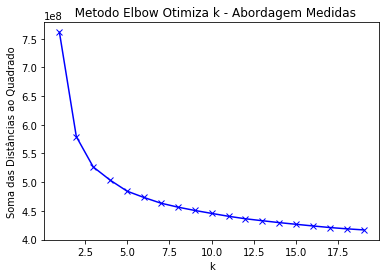

Wall time: 90 ms


In [61]:
#metodo de Elbow

Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dados_medidas_array)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('  Metodo Elbow Otimiza k - Abordagem Medidas')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medida.svg', format="svg")
%time plt.show()

### Abordagem 2: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.20556349681429986
Para n_clusters = 3 O score_silhouette medio e : 0.12796286676145194
Para n_clusters = 4 O score_silhouette medio e : 0.08280520321109608
Para n_clusters = 5 O score_silhouette medio e : 0.07908822397278614
Para n_clusters = 6 O score_silhouette medio e : 0.05916365178596947
Para n_clusters = 7 O score_silhouette medio e : 0.059073721624340964
Para n_clusters = 8 O score_silhouette medio e : 0.055497349868301384


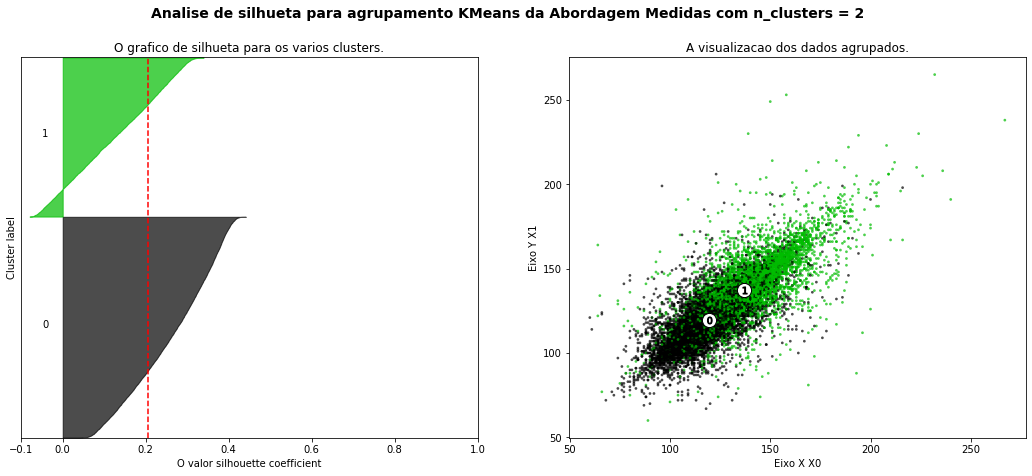

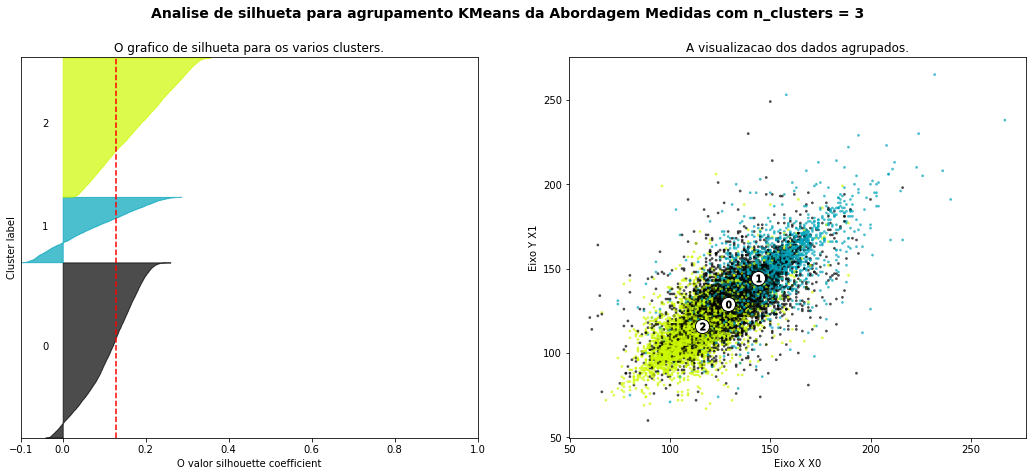

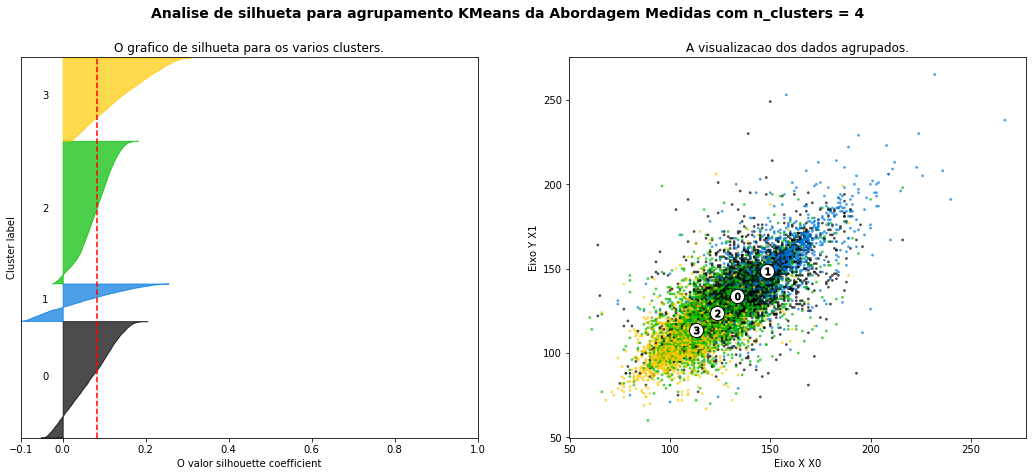

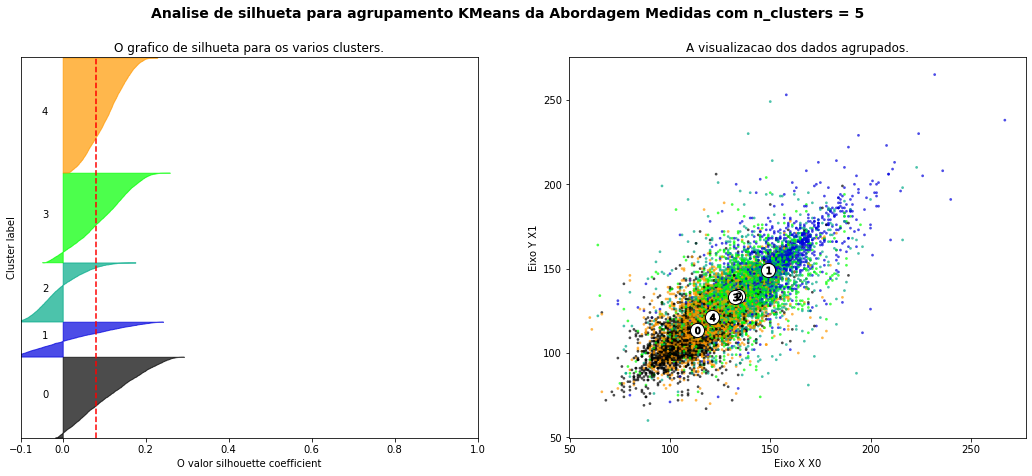

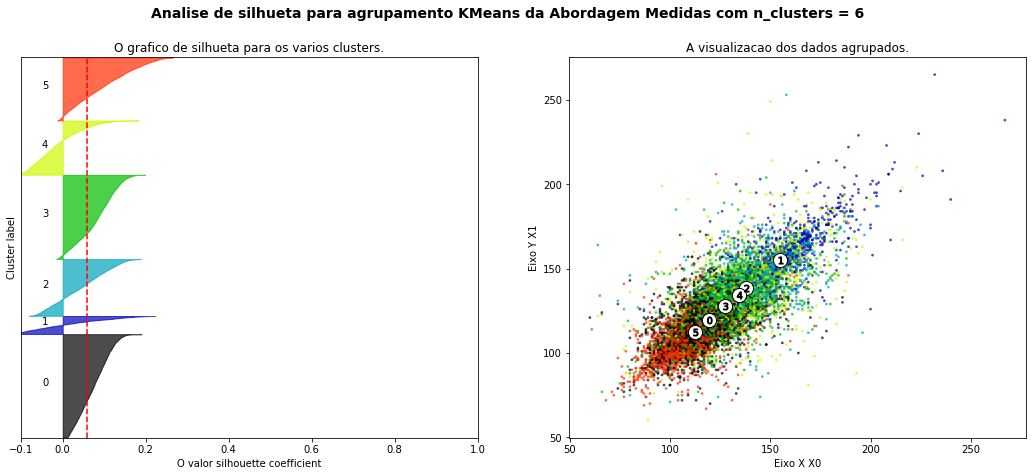

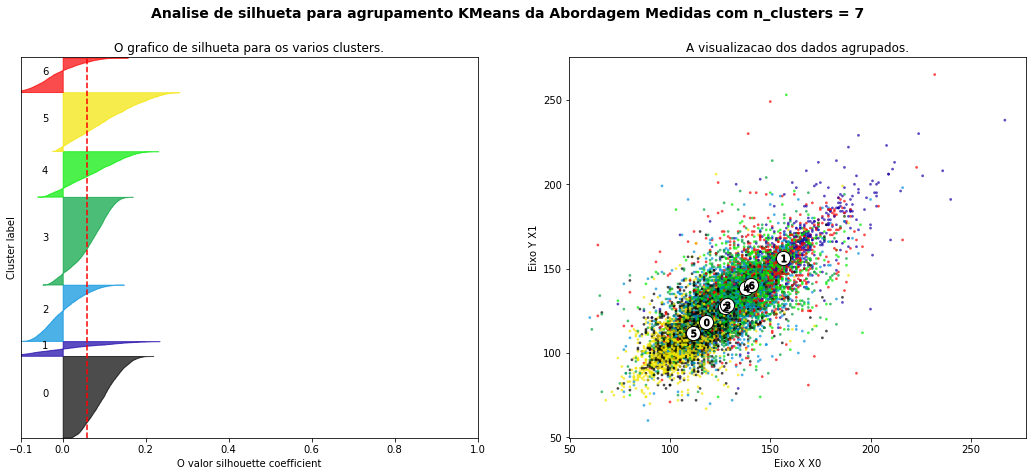

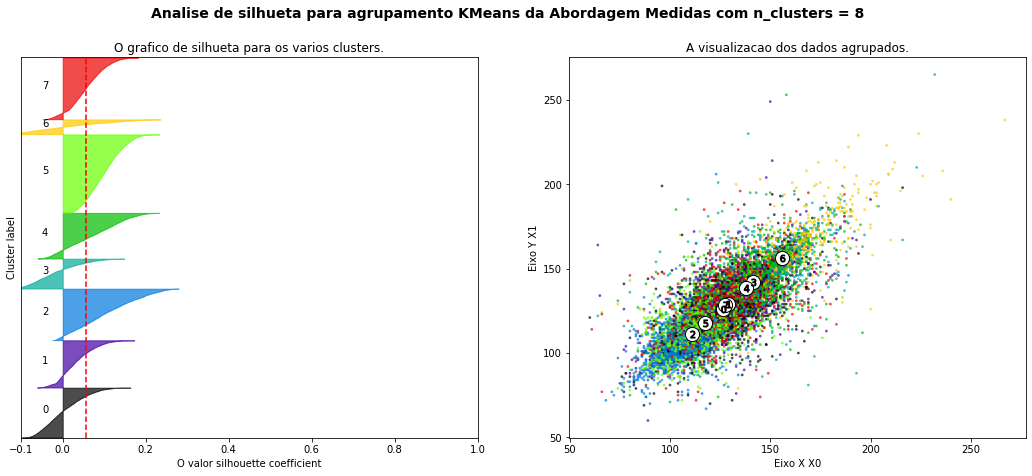

In [62]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dados_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dados_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dados_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dados_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dados_medidas_array[:, 0], dados_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Medidas "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [63]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
dataset_medidas_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']

dataset_medidas_apos_kmeans['grupo'] = grupos_medidas
dataset_medidas_apos_kmeans = pd.concat([dataset_medidas_apos_kmeans,
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_medidas_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_medidas_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

In [64]:
dataset_medidas_apos_kmeans.head()

numero_identificacao data_nascimento  genero  idade   peso altura   IMC  \
0                     4      1923-10-05       1   94.0   85.0    160  33.2   
1                     5      1948-10-07       1   70.0   80.0    165  29.4   
2                     6      1999-03-23       1   19.0  100.0    197  25.8   
3                     7      1978-01-26       0   40.0   65.0   1,64  24.2   
4                     8      1990-03-07       1   28.0  120.0    172  40.6   

   grupo  sist 9:00  sist 9:15  ...  Mediana Sistolica em 24h  \
0      5      105.0      108.0  ...                     118.5   
1      5      103.0      114.0  ...                     106.0   
2      6      147.0      148.0  ...                     133.0   
3      6      140.0      139.0  ...                     131.0   
4      0      113.0      110.0  ...                     115.0   

   Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                       59.0                9545.5                 4902.0   
1                       62.0                8586.5                 5034.5   
2                       79.0               10674.0                 6154.0   
3                       80.0               10679.5                 6420.5   
4                       78.0                9141.5                 6118.0   

   AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0          3748.0             841.5                16.52   
1          2915.0             606.0                 7.51   
2          3721.0             751.5                12.70   
3          3642.0             602.5                16.13   
4          2405.0             566.0                12.27   

   DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  
0                 11.36               11                34  
1                  6.65                9                23  
2                 13.01               19                19  
3                 10.34               21                 9  
4                 12.79               10                11  

[5 rows x 209 columns]

### Abordagem 2: Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
#parametro simples do modelo
random_forest_medidas = RandomForestClassifier(n_estimators=50)

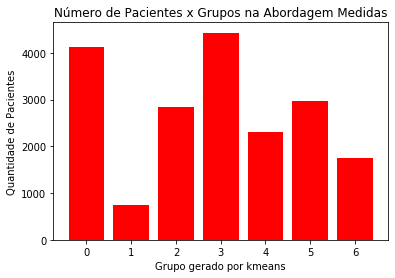

In [67]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_medidas)

for i in range(0,num_otimo_clusters_medidas):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [68]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_array, grupos_medidas, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_array, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [69]:
#treino
random_forest_medidas.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 2: VALIDAÇÃO

In [70]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_medidas.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [71]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [72]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1     2     3     4     5     6
0  2506    0     0     0     0     0     0
1     0  446     0     0     0     0     0
2     0    0  1769     0     0     0     0
3     0    0     0  2661     0     0     0
4     0    0     0     0  1347     0     0
5     0    0     0     0     0  1743     0
6     0    0     0     0     0     0  1020

#### Abordagem 2: TESTE

In [73]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_medidas.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [74]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9091620986687549 - Recall: 0.8869846075628262 - F1 Score: 0.9034042583339223


In [75]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2     3    4     5    6
0  1523    0   24    47    0    26    0
1     0  241    0     0   41     0   14
2    71    0  946    24    0    24    8
3    54    0   12  1690    9     0    4
4     0    0    0    85  857     0    9
5    71    0   22     0    0  1133    0
6     0    1   56    66   28     0  576

In [76]:
dataset_medidas_apos_kmeans.describe()


numero_identificacao        genero         idade          peso  \
count          19154.000000  19154.000000  19154.000000  19154.000000   
mean           10811.307873      0.454579     55.597473     77.336692   
std             6301.966543      0.497946     15.787639     16.751499   
min                4.000000      0.000000     18.000000     31.000000   
25%             5337.250000      0.000000     43.000000     65.000000   
50%            10724.500000      0.000000     56.000000     75.000000   
75%            16280.750000      1.000000     68.000000     87.000000   
max            21793.000000      1.000000    102.000000    200.000000   

                IMC         grupo     sist 9:00     sist 9:15     sist 9:30  \
count  19154.000000  19154.000000  19154.000000  19154.000000  19154.000000   
mean      27.837825      2.831523    126.673332    126.948470    126.961000   
std        4.778817      1.942865     17.546729     17.627613     17.501936   
min       12.100000      0.000000     60.000000     60.000000     61.000000   
25%       24.600000      1.000000    115.000000    115.000000    115.000000   
50%       27.200000      3.000000    125.000000    126.000000    125.000000   
75%       30.400000      4.000000    137.000000    137.000000    137.000000   
max       85.400000      6.000000    267.000000    265.000000    257.000000   

          sist 9:45  ...  Mediana Sistolica em 24h  Mediana Diastolica em 24h  \
count  19154.000000  ...              19154.000000               19154.000000   
mean     126.903728  ...                122.322517                  77.209956   
std       17.390477  ...                 11.689902                   9.949541   
min       62.000000  ...                 84.500000                  43.000000   
25%      115.000000  ...                114.000000                  70.000000   
50%      126.000000  ...                121.000000                  77.000000   
75%      137.000000  ...                129.000000                  84.000000   
max      243.000000  ...                190.000000                 138.500000   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
count          19154.000000           19154.000000    19154.000000   
mean            9948.473635            6224.492926     3071.976715   
std              942.314165             766.246944      616.297264   
min             6903.000000            3651.500000     1641.500000   
25%             9300.000000            5700.125000     2629.000000   
50%             9865.500000            6191.500000     2974.500000   
75%            10482.875000            6708.500000     3411.500000   
max            15230.000000           11134.500000     7329.500000   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
count      19154.000000         19154.000000          19154.000000   
mean         604.734468            12.921506             10.578444   
std          122.777743             3.472378              2.308890   
min          281.500000             4.570000              3.980000   
25%          519.500000            10.490000              8.960000   
50%          586.750000            12.390000             10.380000   
75%          669.500000            14.800000             11.960000   
max         1418.500000            39.550000             24.390000   

       Picos Sistolica  Picos Diastolica  
count     19154.000000      19154.000000  
mean         16.187846         20.631356  
std          13.085308         13.846391  
min           0.000000          0.000000  
25%           7.000000         11.000000  
50%          12.000000         17.000000  
75%          21.000000         27.000000  
max          81.000000         82.000000  

[8 rows x 194 columns]

In [77]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos_medidas, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 2: Importância das Features Random Forest

In [78]:
len(ls_sist_diast), len(random_forest_medidas.feature_importances_)

(164, 164)

In [79]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia_medidas = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_medidas.feature_importances_,3)})
importancia_medidas = importancia_medidas.sort_values('importance',ascending=False)

importancia_medidas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia_medidas


features  importance
71     sist 6:15       0.014
73     sist 6:45       0.012
89   diast 10:45       0.012
98   diast 13:00       0.011
90   diast 11:00       0.011
..           ...         ...
140   diast 0:00       0.003
139  diast 23:30       0.003
138  diast 23:00       0.003
137  diast 22:45       0.003
146   diast 3:00       0.003

[164 rows x 2 columns]

# Abordagem 2.1: Medidas Importantes

In [80]:
#  Utiliza as 7 features mais importantes calculadas na Abordagem Medidas
ls_importantes = importancia_medidas['features'].iloc[:7].values
ls_importantes

array(['sist 6:15', 'sist 6:45', 'diast 10:45', 'diast 13:00',
       'diast 11:00', 'sist 7:00', 'sist 3:30'], dtype=object)

In [81]:
medidas_importantes = dataset_apos_tratamento[ls_importantes]
medidas_importantes

sist 6:15  sist 6:45  diast 10:45  diast 13:00  diast 11:00  sist 7:00  \
0          104.0       94.0         50.0         73.0         54.0       92.0   
1          107.0      111.0         52.0         54.0         61.0      113.0   
2          122.0      136.0         57.0         70.0         54.0      136.0   
3          116.0      104.0         88.0         84.0         77.0      111.0   
4          102.0      116.0         81.0         83.0         76.0      124.0   
...          ...        ...          ...          ...          ...        ...   
19149      152.0      162.0        121.0        123.0         90.0      166.0   
19150      146.0      136.0         80.0         85.0         83.0      116.0   
19151       94.0       96.0         66.0         68.0         63.0       95.0   
19152      107.0      124.0         71.0         71.0         74.0      133.0   
19153      102.0      105.0         78.0         87.0         75.0      108.0   

       sist 3:30  
0           82.0  
1          111.0  
2          107.0  
3          141.0  
4           95.0  
...          ...  
19149      123.0  
19150      116.0  
19151      118.0  
19152       95.0  
19153      142.0  

[19154 rows x 7 columns]

## Abordagem 2.1: Número de Clusters gerado pelo k-Means

In [82]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas_importantes = calculate_wcss(medidas_importantes)
num_otimo_clusters_medidas_importantes = optimal_number_of_clusters(sum_of_squares_medidas_importantes)
num_otimo_clusters_medidas_importantes

Wall time: 17 s


6

In [83]:
#convertendo os dados para a clusterização

dados_medidas_importantes_array = np.array(medidas_importantes)

In [84]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas_importantes = KMeans(n_clusters=num_otimo_clusters_medidas_importantes, random_state=42).fit(dados_medidas_importantes_array)

In [85]:
#listar os grupos 

%time grupos_medidas_importantes = kmeans_medidas_importantes.fit_predict(dados_medidas_importantes_array)
grupos_medidas_importantes

Wall time: 312 ms


array([2, 1, 4, ..., 2, 1, 5])

In [86]:
medidas_importantes.insert(0,'grupo',grupos_medidas_importantes + 1)
medidas_importantes

grupo  sist 6:15  sist 6:45  diast 10:45  diast 13:00  diast 11:00  \
0          3      104.0       94.0         50.0         73.0         54.0   
1          2      107.0      111.0         52.0         54.0         61.0   
2          5      122.0      136.0         57.0         70.0         54.0   
3          6      116.0      104.0         88.0         84.0         77.0   
4          6      102.0      116.0         81.0         83.0         76.0   
...      ...        ...        ...          ...          ...          ...   
19149      1      152.0      162.0        121.0        123.0         90.0   
19150      5      146.0      136.0         80.0         85.0         83.0   
19151      3       94.0       96.0         66.0         68.0         63.0   
19152      2      107.0      124.0         71.0         71.0         74.0   
19153      6      102.0      105.0         78.0         87.0         75.0   

       sist 7:00  sist 3:30  
0           92.0       82.0  
1          113.0      111.0  
2          136.0      107.0  
3          111.0      141.0  
4          124.0       95.0  
...          ...        ...  
19149      166.0      123.0  
19150      116.0      116.0  
19151       95.0      118.0  
19152      133.0       95.0  
19153      108.0      142.0  

[19154 rows x 8 columns]

In [87]:
df_medidas_importantes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],medidas_importantes['grupo'],dataset_apos_tratamento.loc[:,'sist 9:00':]], axis=1)
df_medidas_importantes

numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19149                 21786      1972-11-25       1   47.0   75.0    165   
19150                 21787      1970-10-19       1   49.0   90.0    183   
19151                 21788      1985-03-15       0   35.0   93.0    167   
19152                 21792      1952-04-21       0   68.0   64.0    160   
19153                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      3      105.0  ...   
1      29.4  2018-12-26 07:39:41      2      103.0  ...   
2      25.8  2018-12-26 08:06:19      5      147.0  ...   
3      24.2  2018-12-26 08:19:06      6      140.0  ...   
4      40.6  2018-12-26 08:26:59      6      113.0  ...   
...     ...                  ...    ...        ...  ...   
19149  27.5  2020-09-10 16:03:08      1      163.0  ...   
19150  26.9  2020-09-10 16:21:02      5      114.0  ...   
19151  33.3  2020-09-10 16:44:53      3      107.0  ...   
19152  25.0  2020-09-10 17:25:50      2       94.0  ...   
19153  30.9  2020-09-10 17:42:01      6      111.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19149                      116.0               12224.5                 9265.0   
19150                       85.0               10970.0                 6819.0   
19151                       62.0                9245.0                 4935.5   
19152                       68.0                8989.5                 5660.0   
19153                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19149          2439.0             474.5                18.66   
19150          3319.0             738.0                17.22   
19151          3556.0             713.5                14.36   
19152          2815.5             460.0                14.14   
19153          2400.5             612.0                13.92   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     11.36               11                34   
1                      6.65                9                23   
2                     13.01               19                19   
3                     10.34               21                 9   
4                     12.79               10                11   
...                     ...              ...               ...   
19149                 14.80               49                60   
19150                 13.67               32                27   
19151                  8.29               14     

# Abordagem 2.2: Features Selection: Select Kbest na Abordagem 2

In [88]:
#  Uso do SelectKBest para identificar as melhores 5 features

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

medidas_mais_importantes_ml = SelectKBest(chi2, k=7).fit_transform(dados_medidas_array, grupos_medidas)
medidas_mais_importantes_ml.shape

(19154, 7)

In [89]:
#medidas_transformadas[70]

In [90]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

medidas_mais_importantes = pd.DataFrame(medidas_mais_importantes_ml)

In [91]:
# identificação de quais colunas foram escolhidas
#
lista_colunas_escolhidas = []
#
## X é o dataset das doenças que precisa ser transformado em df
medidas_transformadas = pd.DataFrame(dados_medidas_array)


for coluna_ml in range(len(medidas_mais_importantes.columns)):
    for coluna_base in range(len(medidas_transformadas.columns)):
        # para identificar valores únicos
        if set(np.array(medidas_transformadas[coluna_base]) == np.array(medidas_mais_importantes[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas,list(dados_medidas_sem_id.iloc[:,lista_colunas_escolhidas].columns)

#

([70, 71, 72, 73, 74, 75, 76],
 ['sist 6:00',
  'sist 6:15',
  'sist 6:30',
  'sist 6:45',
  'sist 7:00',
  'sist 7:15',
  'sist 7:30'])

In [92]:
#selecionando padrões de doencas

ls_medidas_kbest = ['sist 5:30', 'sist 6:00', 'sist 6:15', 'sist 6:30', 'sist 6:45', 'sist 7:00', 'sist 7:15']
ls_medidas_kbest = list(dados_medidas_sem_id.iloc[:,lista_colunas_escolhidas].columns)

dados_padrao_medidas_kbest =  dataset_apos_tratamento[ls_medidas_kbest]
dados_padrao_medidas_kbest

sist 6:00  sist 6:15  sist 6:30  sist 6:45  sist 7:00  sist 7:15  \
0          113.0      104.0       96.0       94.0       92.0       91.0   
1          105.0      107.0      109.0      111.0      113.0      113.0   
2          109.0      122.0      135.0      136.0      136.0      135.0   
3          135.0      116.0       96.0      104.0      111.0      128.0   
4           94.0      102.0      109.0      116.0      124.0      132.0   
...          ...        ...        ...        ...        ...        ...   
19149      147.0      152.0      157.0      162.0      166.0      166.0   
19150      135.0      146.0      157.0      136.0      116.0      113.0   
19151       89.0       94.0       98.0       96.0       95.0      100.0   
19152       99.0      107.0      116.0      124.0      133.0      121.0   
19153      100.0      102.0      103.0      105.0      108.0      111.0   

       sist 7:30  
0           89.0  
1          113.0  
2          134.0  
3          145.0  
4           93.0  
...          ...  
19149      166.0  
19150      113.0  
19151      110.0  
19152      114.0  
19153      105.0  

[19154 rows x 7 columns]

## K-means para Abordagem 2.2: SelectKbest

In [93]:
#  Cálculo do "n_clusters" considerando as colunas definidas por SelectKBest

sum_of_squares = calculate_wcss(medidas_mais_importantes_ml)
medidas_kbest = optimal_number_of_clusters(sum_of_squares)
kmeans = KMeans(n_clusters=medidas_kbest, random_state=42).fit(medidas_mais_importantes_ml)
grupos_medidas = kmeans.fit_predict(medidas_mais_importantes_ml)
print(medidas_kbest)
print(grupos_medidas)

6
[0 3 4 ... 0 3 0]


###  Abordagem 2.2: Random Forest for KBest

In [94]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

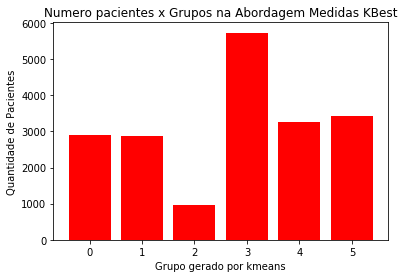

In [95]:
#base para modelo
classes = []
qtds = []

contagem_medidas = Counter(grupos_medidas)

for i in range(0,medidas_kbest):
    classes.append(i)
    qtds.append(contagem_medidas[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos na Abordagem Medidas KBest')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem2_medidasKBest_por_grupos.svg',format="svg")
plt.show()

## Train, Test, Validation for KBest

In [96]:
# Separa o grupo de dados para treino e teste
#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection: SelectKBest
x_train, x_test, y_train, y_test = train_test_split(medidas_mais_importantes_ml, grupos_medidas, test_size=1 - train_ratio,random_state=42)

# Feature Selection: SelectKBest
x_val, x_test, y_val, y_test = train_test_split(medidas_mais_importantes_ml, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)


# Feature Selection: SelectKBest sem validação
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)

#X_train.shape, y_train.shape

#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [97]:
# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 2.2: VALIDAÇÃO

In [98]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [99]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3     4     5
0  1724     0    0     0     0     0
1     0  1703    0     0     0     0
2     0     0  562     0     0     0
3     0     0    0  3439     0     0
4     0     0    0     0  1978     0
5     0     0    0     0     0  2086

#### Abordagem 2.2: TESTE

In [100]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9715478987209606 - Recall: 0.9675052982000397 - F1 Score: 0.9703998235049133


In [101]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3     4     5
0  1159     0    0    30     0     0
1     0  1160    5     0     5     9
2     0    22  370     0     0     0
3    17     0    0  2244    18    11
4     0     5    0    28  1228    19
5     0    17    0     9    23  1283

####  Abordagem 2.2: Importância das Features Random Forest

In [102]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

# Importância para SelectKBest
importancia_medidas = pd.DataFrame({'features':ls_medidas_kbest,'importance':np.round(random_forest.feature_importances_,3)})

importancia_medidas = importancia_medidas.sort_values('importance',ascending=False)

importancia_medidas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_kbest_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia_medidas

features  importance
3  sist 6:45       0.211
1  sist 6:15       0.200
5  sist 7:15       0.171
6  sist 7:30       0.138
2  sist 6:30       0.100
4  sist 7:00       0.094
0  sist 6:00       0.085

# Abordagem 3: Estatísticas como entrada

In [103]:
#selecionando variaveis estatisticas


ls_estatistica = [
    'Media Sistolica em 24h',
#    'Media Diastolica em 24h',
#    'Media Sistolica Diurna',
#    'Media Sistolica Matutina',
#    'Media Sistolica Vespertina',
#    'Media Sistolica Daytime',
#    'Media Sistolica Nighttime',
#    'Media Diastolica Diurna',
#    'Media Diastolica Matutina',
#    'Media Diastolica Vespertina',
#    'Media Diastolica Daytime',
#    'Media Diastolica Nighttime',
#    'Variancia Sistolica em 24h',
#    'Variancia Diastolica em 24h',
#    'Mediana Sistolica em 24h',
#    'Mediana Diastolica em 24h',
    'AUC Sistolica em 24h',
    'AUC Diastolica em 24h',
    'AUC PP Daytime',
#    'AUC PP Nighttime',
#    'DP Sistolica em 24h',
#    'DP Diastolica em 24h',
]

dados_estatistica =  dataset_estatistica[ls_estatistica]

In [104]:
#tratar nulos
dados_estatistica_sem_nan = dados_estatistica.fillna(0)

## Abordagem 3: Número de Clusters gerado pelo k-Means

In [105]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(dados_estatistica_sem_nan)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

Wall time: 13.2 s
7


In [106]:
#convertendo os dados para a clusterização
X = np.array(dados_estatistica_sem_nan)

In [107]:
#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=42).fit(X)

In [108]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [109]:
#incluir grupos nos dados de sist e diast
dados_estatistica_sem_nan['grupo'] = grupos
dados_estatistica_sem_nan['grupo'] = dados_estatistica_sem_nan['grupo'] + 1

##   Abordagem 3: Método Elbow 

###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

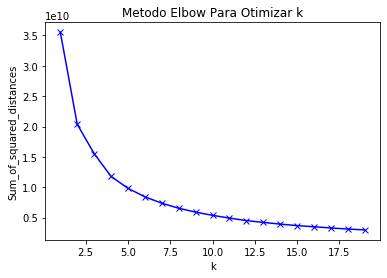

In [110]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_estatistica.svg', format="svg")
plt.show()



## Abordagem 3: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.384823235139126
Para n_clusters = 3 O score_silhouette medio e : 0.3262500329703919
Para n_clusters = 4 O score_silhouette medio e : 0.3508836444178031
Para n_clusters = 5 O score_silhouette medio e : 0.3254762199663175
Para n_clusters = 6 O score_silhouette medio e : 0.32661250698986194
Para n_clusters = 7 O score_silhouette medio e : 0.3205042421259532


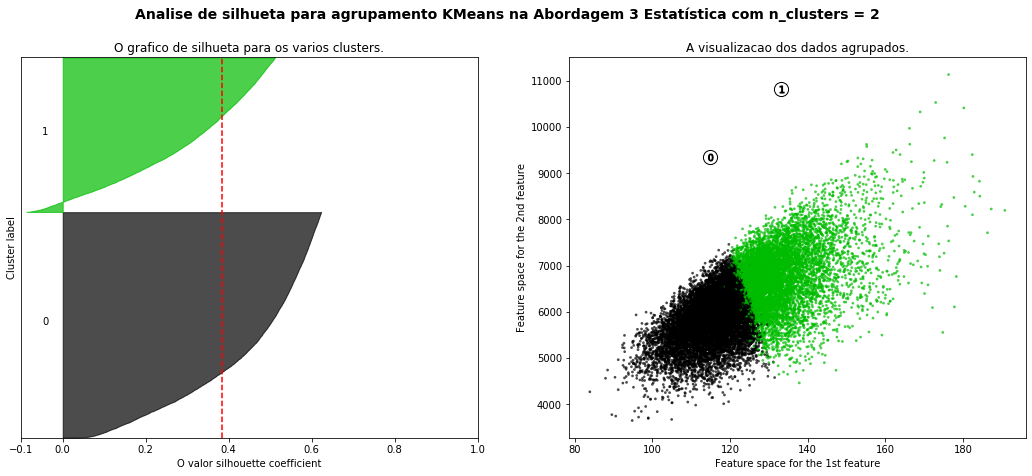

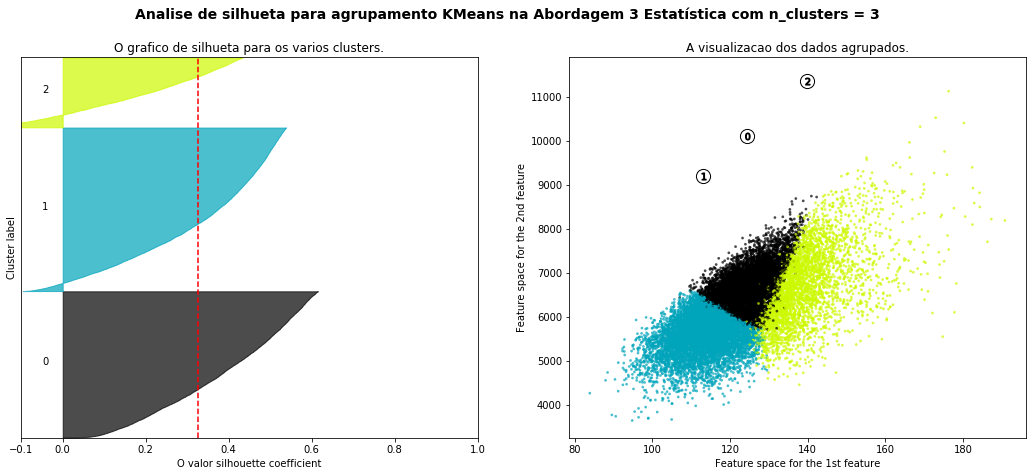

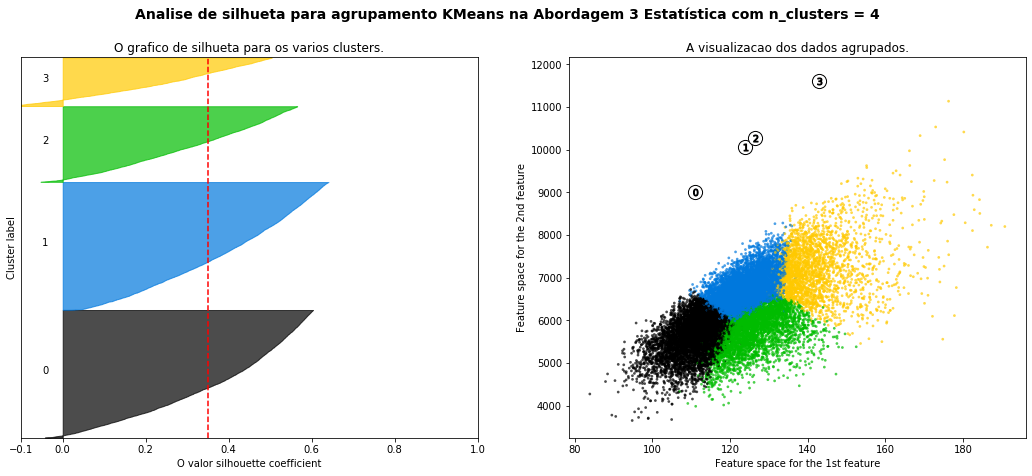

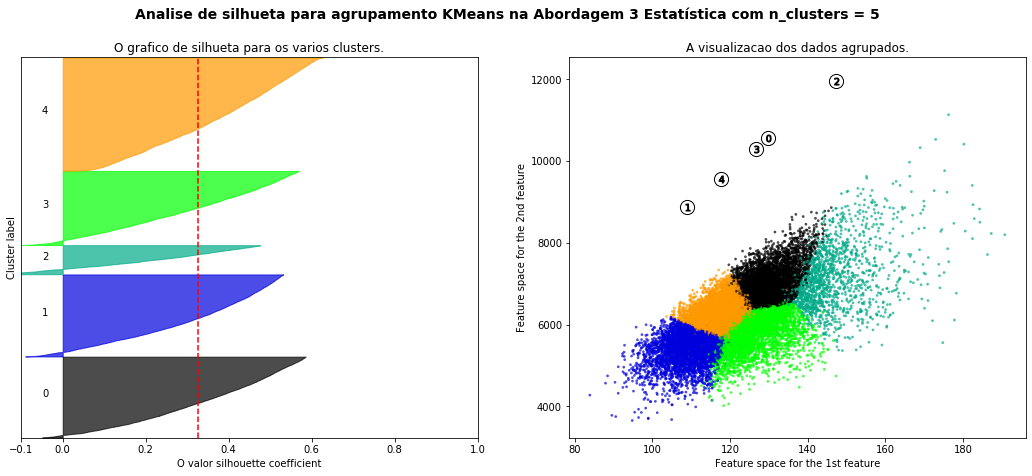

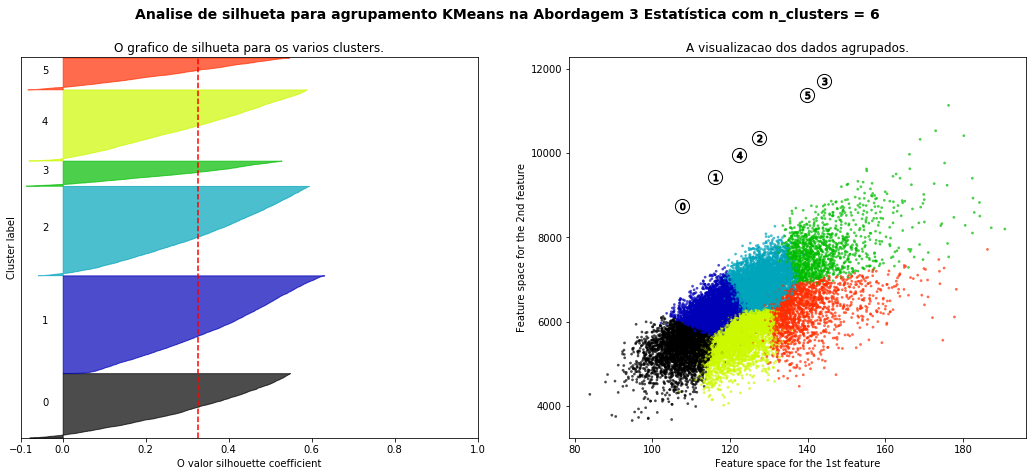

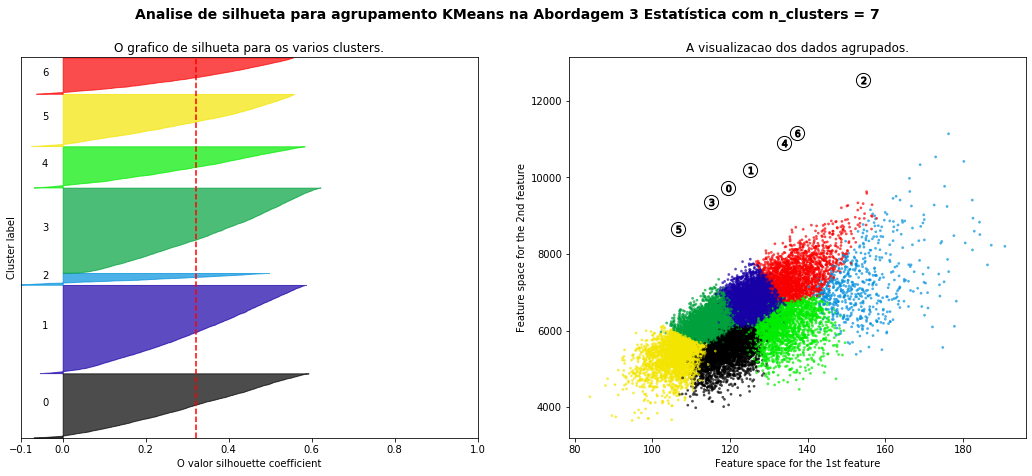

In [111]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans na Abordagem 3 Estatística "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_estatistica_{n_clusters}.svg', format="svg")
    #fig.savefig('estatisticas/estatisticas_kmeans_'+str(n_clusters)+'.png', format='png')

plt.show()

#fig.savefig('kmeans_estatisticas.png', format='png')

In [112]:
#dataset com grupos e por estatisticas

dataset_estatistica = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']
#############################################################################################
#dataset_estatistica = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_estatistica['IMC'] = dataset_medidas['IMC']
dataset_estatistica['grupo'] = grupos
dataset_estatistica = pd.concat([dataset_estatistica,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


### Abordagem 3: Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

In [114]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

In [115]:
#base para modelo

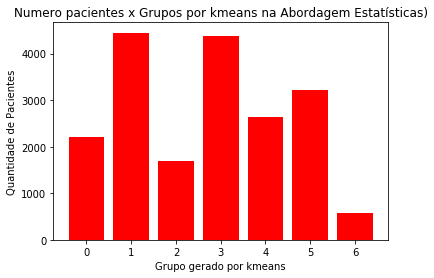

In [116]:
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Estatísticas)')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem2_estatistica_por_grupos.svg',format="svg")
plt.show()

In [117]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [118]:
#treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 3: VALIDAÇÃO

In [119]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [120]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [121]:
#Matriz da Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3     4     5    6
0  1313     0    0     0     0     0    0
1     0  2683    0     0     0     0    0
2     0     0  993     0     0     0    0
3     0     0    0  2626     0     0    0
4     0     0    0     0  1562     0    0
5     0     0    0     0     0  1987    0
6     0     0    0     0     0     0  328

#### Abordagem 3: TESTE

In [122]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [123]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9895588619159489 - Recall: 0.9887976744023378 - F1 Score: 0.9869815090008923


In [124]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3     4     5    6
0  881     0    0     1     0     5    6
1    0  1759    0     7     1     0    0
2    4     0  689     2     0     0    4
3    6     7    5  1728     0     3    0
4    0     1    0     0  1074     4    0
5   11     3    0     3     4  1214    0
6    0     0    3     0     0     0  237

In [125]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_estatistica = x_val_[['numero_identificacao']]
pacientes_validacao_estatistica['Grupo_Real'] = y_val_
pacientes_validacao_estatistica['Grupo_Previsto'] = y_prev_val
pacientes_validacao_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


#teste
pacientes_teste_estatistica = x_test_[['numero_identificacao']]
pacientes_teste_estatistica['Grupo_Real'] = y_test_
pacientes_teste_estatistica['Grupo_Previsto'] = y_prev_test
pacientes_teste_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 3: Importância das Features Random Forest

In [126]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_estatistica,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1    AUC Sistolica em 24h       0.334
2   AUC Diastolica em 24h       0.282
3          AUC PP Daytime       0.204
0  Media Sistolica em 24h       0.181

# Abordagem 4: Padrão de Doenças

In [127]:
#selecionando padrões de doencas

ls_padroes_doencas = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas =  dataset_apos_tratamento[ls_padroes_doencas]

In [128]:
dados_padrao_doencas[dados_padrao_doencas['Non Dipping'] == True]

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
2            True              False               False    False   
5            True              False               False    False   
6            True              False               False    False   
7            True              False               False    False   
8            True              False               False    False   
...           ...                ...                 ...      ...   
19142        True              False               False    False   
19143        True              False               False    False   
19145        True              False               False    False   
19150        True              False               False    False   
19151        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
2             True            False            False          False   False   
5             True            False            False          False   False   
6             True            False            False          False   False   
7             True            False            False          False   False   
8             True            False            False          False   False   
...            ...              ...              ...            ...     ...   
19142         True            False            False          False   False   
19143         True            False            False          False   False   
19145         True            False            False          False   False   
19150         True            False            False          False   False   
19151         True            False            False          False   False   

       Whitecoat  Normotenso  
2           True       False  
5           True       False  
6           True       False  
7          False       False  
8          False       False  
...          ...         ...  
19142       True       False  
19143       True       False  
19145       True       False  
19150       True       False  
19151       True       False  

[8683 rows x 11 columns]

In [129]:
#tratar nulos
dados_padrao_doencas_sem_nan = dados_padrao_doencas.fillna(0)
dados_padrao_doencas_sem_nan

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19149        True              False               False     True   
19150        True              False               False    False   
19151        True              False               False    False   
19152        True              False               False    False   
19153        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19149        False            False            False           True   False   
19150         True            False            False          False   False   
19151         True            False            False          False   False   
19152        False             True            False          False   False   
19153        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19149       True       False  
19150       True       False  
19151       True       False  
19152      False       False  
19153       True       False  

[19154 rows x 11 columns]

In [130]:
#trocar nulos do dataframe
d_p_d = dados_padrao_doencas
dados_padrao_doencas

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19149        True              False               False     True   
19150        True              False               False    False   
19151        True              False               False    False   
19152        True              False               False    False   
19153        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19149        False            False            False           True   False   
19150         True            False            False          False   False   
19151         True            False            False          False   False   
19152        False             True            False          False   False   
19153        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19149       True       False  
19150       True       False  
19151       True       False  
19152      False       False  
19153       True       False  

[19154 rows x 11 columns]

In [131]:
##############################################################################################################
#Trocar True e False para 1 e 0
#d_p_d['Hipotensao'] = d_p_d['Hipotensao'].apply(verdadeiro_falso)
#d_p_d['Sistolica Isolada'] = d_p_d['Sistolica Isolada'].apply(verdadeiro_falso)
#d_p_d['Diastolica Isolada'] = d_p_d['Diastolica Isolada'].apply(verdadeiro_falso)
#d_p_d['Dipping'] = d_p_d['Dipping'].apply(verdadeiro_falso)
#d_p_d['Non Dipping'] = d_p_d['Non Dipping'].apply(verdadeiro_falso)
#d_p_d['Extreme Dipping'] = d_p_d['Extreme Dipping'].apply(verdadeiro_falso)
#d_p_d['Reverse Dipping'] = d_p_d['Reverse Dipping'].apply(verdadeiro_falso)
#d_p_d['Morning Surge'] = d_p_d['Morning Surge'].apply(verdadeiro_falso)
#d_p_d['Masked'] = d_p_d['Masked'].apply(verdadeiro_falso)
#d_p_d['Whitecoat'] = d_p_d['Whitecoat'].apply(verdadeiro_falso)
#d_p_d['Normotenso'] = d_p_d['Normotenso'].apply(verdadeiro_falso)

##  Abordagem 4: Número de Clusters gerado pelo k-Means

In [132]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(d_p_d)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

7


In [133]:
kmeans

KMeans(n_clusters=7, random_state=42)

In [134]:
#convertendo os dados para entrga ao Random - Classifcação
X = np.array(d_p_d)

In [135]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans = KMeans(n_clusters=n, random_state=42).fit(X)


In [136]:
#listar os grupos 

grupos = kmeans.fit_predict(X)


In [137]:
grupos

array([2, 2, 1, ..., 1, 6, 2])

In [138]:
set(grupos)

{0, 1, 2, 3, 4, 5, 6}

##   Abordagem 4: Método Elbow 

###  Método de cálculo do melhor número de cluster para o algoritmo e plota o gráfico

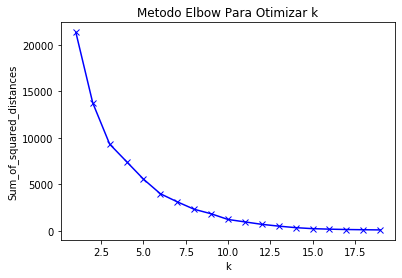

In [139]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf()
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_doenca.svg', format="svg")
plt.show()

## Abordagem 4: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.4170396686896818
Para n_clusters = 3 O score_silhouette medio e : 0.5264804129586854
Para n_clusters = 4 O score_silhouette medio e : 0.579893882970028
Para n_clusters = 5 O score_silhouette medio e : 0.6194778241571113
Para n_clusters = 6 O score_silhouette medio e : 0.6951081658876236
Para n_clusters = 7 O score_silhouette medio e : 0.7501577149868125
Para n_clusters = 8 O score_silhouette medio e : 0.801600052711


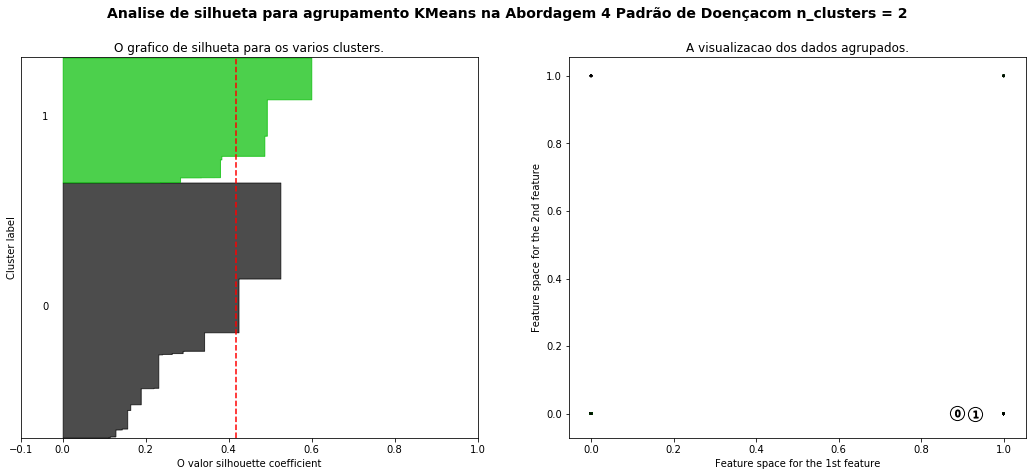

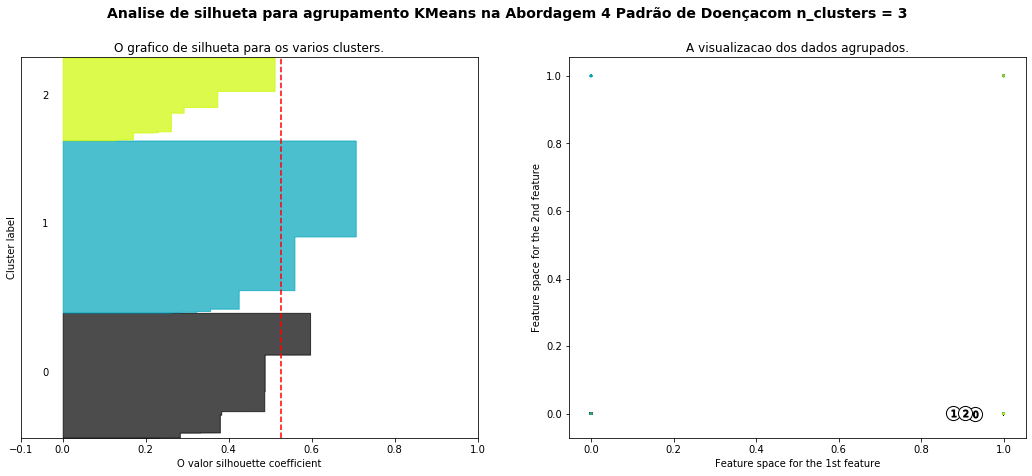

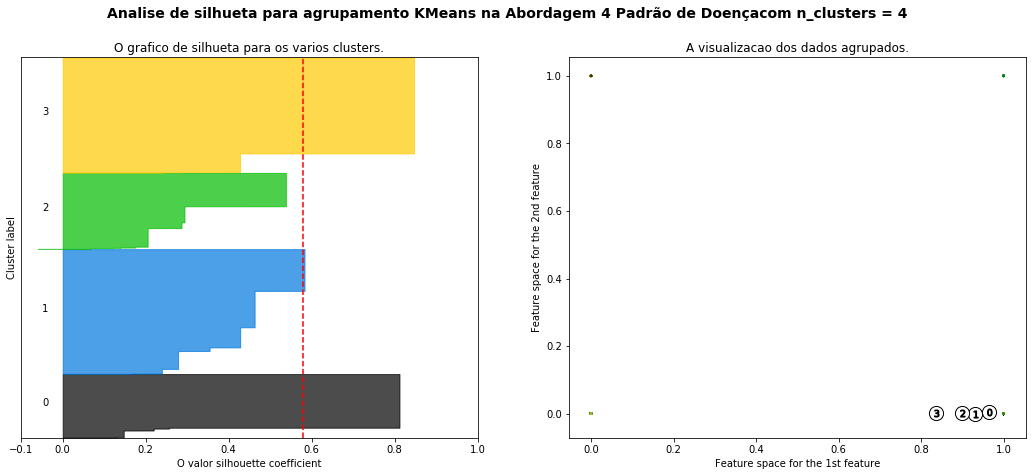

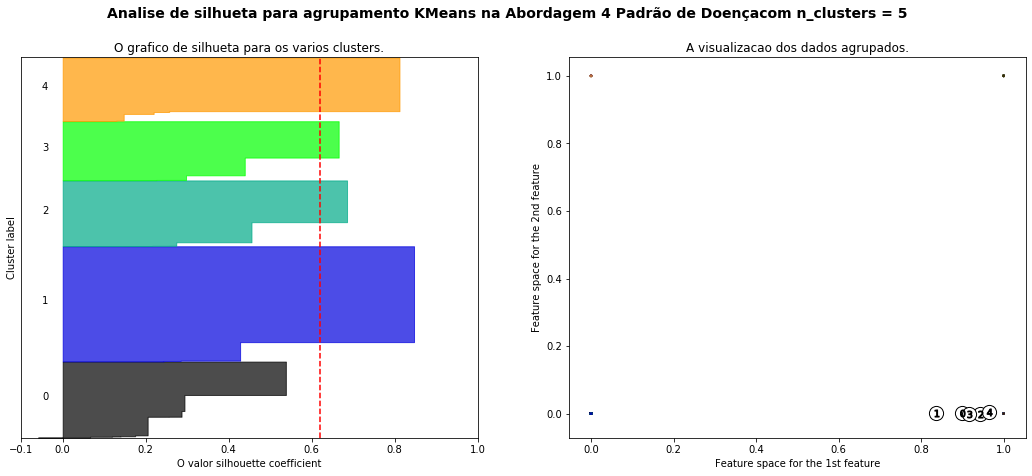

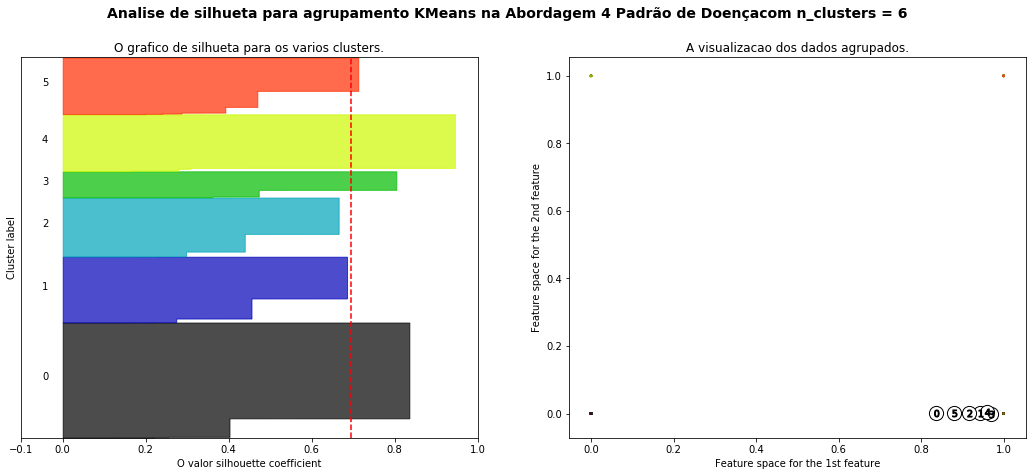

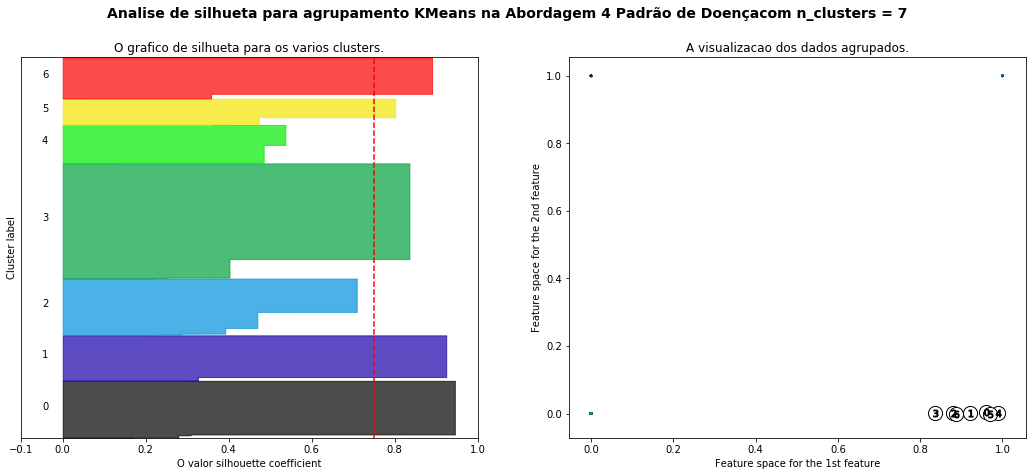

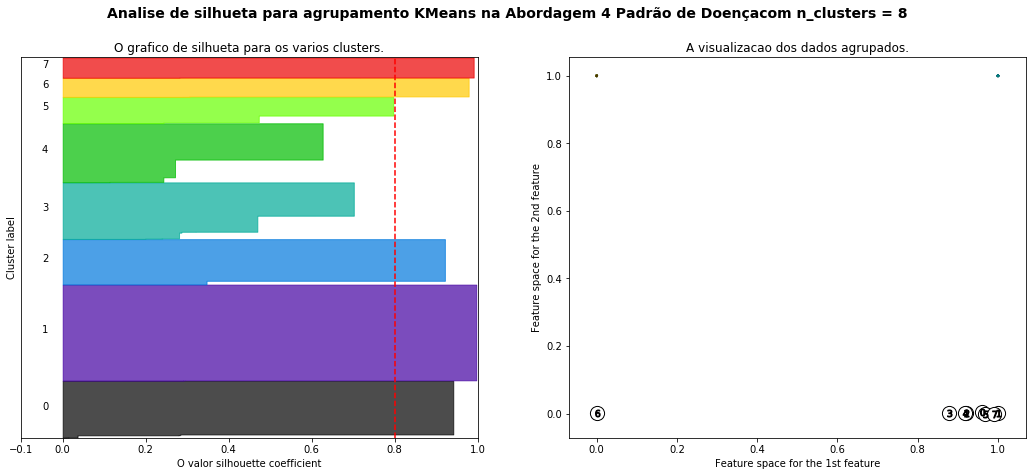

In [140]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans na Abordagem 4 Padrão de Doença"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_doenca_{n_clusters}.svg', format="svg")
    #fig.savefig('padrao_doencas/padrao_doencas_kmeans_'+str(n_clusters)+'.png', format='png')  

plt.show()

#fig.savefig('kmeans_padroes_doencas.png', format='png')

In [141]:
#dataset com grupos e por padrão de doencas

dataset_padrao_doenca = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']
#dataset_padrao_doenca = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_padrao_doenca['IMC'] = dataset_medidas['IMC']
dataset_padrao_doenca['grupo'] = grupos
dataset_padrao_doenca['grupo'] = dataset_padrao_doenca['grupo'] + 1

dataset_padrao_doenca = pd.concat([dataset_padrao_doenca,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_padrao_doenca.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

In [142]:
dados_padrao_doencas

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19149        True              False               False     True   
19150        True              False               False    False   
19151        True              False               False    False   
19152        True              False               False    False   
19153        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19149        False            False            False           True   False   
19150         True            False            False          False   False   
19151         True            False            False          False   False   
19152        False             True            False          False   False   
19153        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19149       True       False  
19150       True       False  
19151       True       False  
19152      False       False  
19153       True       False  

[19154 rows x 11 columns]

# Abordagem 4.1: Features Selection: Kbest  na Abordagem 4: Doenças

In [143]:
#  Uso do SelectKBest para identificar as melhores 5 features

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

features_mais_importante_ml = SelectKBest(chi2, k=5).fit_transform(X, grupos)
features_mais_importante_ml.shape

(19154, 5)

In [144]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

features_mais_importante = pd.DataFrame(features_mais_importante_ml)


In [145]:
# identificação de quais colunas foram escolhidas

lista_colunas_escolhidas = []
# X é o dataset das doenças que precisa ser transformado em df
x_df = pd.DataFrame(X)
for coluna_ml in range(len(features_mais_importante.columns)):
    for coluna_base in range(len(x_df.columns)):
        # para identificar valores únicos
        if set(np.array(x_df[coluna_base]) == np.array(features_mais_importante[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas

# Foram escolhidas as colunas 'Diastolica Isolada', 'Dipping','Non Dipping', 'Extreme Dipping', 'Reverse Dipping'

[3, 4, 5, 6, 7]

In [146]:
#selecionando padrões de doencas

ls_doencas_kbest = ['Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping']

#ls_doencas_kbest = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
#       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
#       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas_kbest =  dataset_apos_tratamento[ls_doencas_kbest]

## Abordagem 4.1:  K-means para SelectKbest

In [147]:
#  Cálculo do "n_clusters" considerando as colunas definidas por SelectKBest

sum_of_squares = calculate_wcss(features_mais_importante_ml)
n_kbest = optimal_number_of_clusters(sum_of_squares)
kmeans = KMeans(n_clusters=n_kbest, random_state=42).fit(features_mais_importante_ml)
grupos = kmeans.fit_predict(features_mais_importante_ml)
print(n)
print(grupos)

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (11). Possibl

7
[0 0 1 ... 1 4 0]


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (20). Possibly due to duplicate points in X.


In [148]:
# Separa o grupo de dados para treino e teste

# Feature Selection: none
#X_train, X_test, y_train, y_test = train_test_split(X, grupos, test_size=0.15, random_state=0)

# Feature Selection: SelectKBest
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)
#
#X_train.shape, y_train.shape
#
#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

###  Abordagem 4.1: Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier

In [150]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=10)

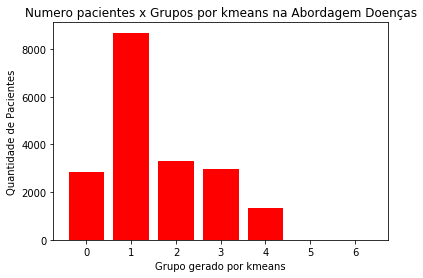

In [151]:
#base para modelo
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()

In [152]:
#salvar a imagem
#fig.savefig('padrao_doencas/qtd_x_padrao_doencas.png', format='png')

## Train, Test, Validation

In [153]:
# Separa o grupo de dados para treino e teste
#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection: none
#X_train, X_test, y_train, y_test = train_test_split(X, grupos, test_size=0.15, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)

# Feature Selection: SelectKBest
x_train, x_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=1 - train_ratio,random_state=42)

# Feature Selection: none
#x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Feature Selection: SelectKBest
x_val, x_test, y_val, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)


# Feature Selection: SelectKBest sem validação
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)

#X_train.shape, y_train.shape

#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [154]:
# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10)

#### Abordagem 4.1: VALIDAÇÃO

In [155]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [156]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [157]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3    4  5  6
0  1695     0     0     0    0  0  0
1     0  5218     0     0    0  0  0
2     0     0  1985     0    0  0  0
3     0     0     0  1808    0  0  0
4     0     0     0     0  786  0  0
5     0     0     0     0    0  0  0
6     0     0     0     0    0  0  0

#### Abordagem 4.1: TESTE

In [158]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [159]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [160]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3    4  5  6
0  1166     0     0     0    0  0  0
1     0  3465     0     0    0  0  0
2     0     0  1330     0    0  0  0
3     0     0     0  1171    0  0  0
4     0     0     0     0  530  0  0
5     0     0     0     0    0  0  0
6     0     0     0     0    0  0  0

In [161]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

####  Abordagem 4.1: Importância das Features Random Forest

In [162]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

#importancia = pd.DataFrame({'features':ls_padroes_doencas,'importance':np.round(random_forest.feature_importances_,3)})

# Importância para SelctKBest
importancia = pd.DataFrame({'features':ls_doencas_kbest,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1             Dipping       0.399
4     Reverse Dipping       0.237
3     Extreme Dipping       0.200
2         Non Dipping       0.098
0  Diastolica Isolada       0.065

# Abordagem 5 doença sem extremos (Sem Hipotensão e sem Normotenso)

In [163]:
#   Doenças SEM Hipotensão

ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_doencas = ls_doencas[1:]

#  O índice zero é a 1a. coluna de doença que vai até 9 (a última até Whitecoat)
#  Usar esse comando para a abordagem em cada uma das doenças separadamente
#grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

#  Usar esse comando para a abordagem de um range de doenças. Aqui não entrou Hipotensão, nem Normotenso
escolho_doenca = np.array(dataset_apos_tratamento[ls_doencas])

In [164]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(escolho_doenca)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=42).fit(escolho_doenca)

#listar os grupos 
grupo_escolho_doenca = kmeans.fit_predict(escolho_doenca)

#incluir grupos nos dados de sist e diast

grupo_df = pd.DataFrame()
grupo_df['grupo'] = grupo_escolho_doenca
grupo_df['grupo'] = grupo_df['grupo'] + 1

dados_completos_escolho_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    grupo_df['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}

dados_completos_escolho_doenca = dados_completos_escolho_doenca.replace(genero_M_F)

#dados_completos_escolho_doenca = dados_completos_generico
#dados_completos_escolho_doenca['grupo'] = grupo_escolho_doenca
#dados_completos_escolho_doenca['grupo'] = dados_completos_escolho_doenca['grupo'] + 1

Wall time: 2.27 s
7


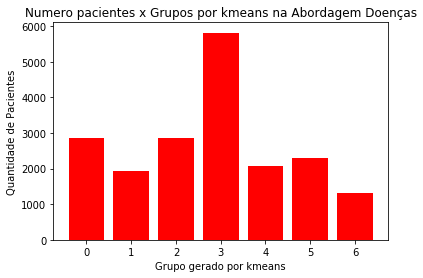

In [165]:
#     Aplicação do RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier

#    Aplicação do modelo com parâmetro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = []
qtds = []

contagem = Counter(grupo_escolho_doenca)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()

In [166]:
#  Separação dos dados em Treino, Test e Validação
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(escolho_doenca, grupo_escolho_doenca, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(escolho_doenca, grupo_escolho_doenca, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

In [167]:
#### Abordagem 5: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0     1     2     3     4     5    6
0  1702     0     0     0     0     0    0
1     0  1198     0     0     0     0    0
2     0     0  1694     0     0     0    0
3     0     0     0  3516     0     0    0
4     0     0     0     0  1248     0    0
5     0     0     0     0     0  1348    0
6     0     0     0     0     0     0  786

In [168]:
#### Abordagem 5: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0    1     2     3    4    5    6
0  1168    0     0     0    0    0    0
1     0  736     0     0    0    0    0
2     0    0  1166     0    0    0    0
3     0    0     0  2297    0    0    0
4     0    0     0     0  823    0    0
5     0    0     0     0    0  942    0
6     0    0     0     0    0    0  530

In [169]:
####  Abordagem 5: Importância das Features Random Forest

#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais


importancia = pd.DataFrame({'features':ls_doencas,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_sem_hipo_normo.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
8           Whitecoat       0.333
3         Non Dipping       0.191
5     Reverse Dipping       0.142
2             Dipping       0.138
6       Morning Surge       0.129
4     Extreme Dipping       0.067
0   Sistolica Isolada       0.000
1  Diastolica Isolada       0.000
7              Masked       0.000

# Abordagem 6: escolho doença

In [170]:
ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_medidas = list(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'].columns)

#  O índice zero é a 1a. coluna de doença que vai até 9 (a última até Whitecoat)
grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

dados_medidas_novo = np.array(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'])
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = [0,1]
qtds = []

'''contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()'''
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

In [171]:
# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_novo, grupos_doenca, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_novo, grupos_doenca, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

In [172]:
#### Abordagem 6: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9999129829446571 - Recall: 0.9995655951346656 - F1 Score: 0.9997585287297546


In [173]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0      1
0  1150      1
1     0  10341

In [174]:
#### Abordagem 6: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9540589924301749 - Recall: 0.8137045154647807 - F1 Score: 0.8526820799422838


In [175]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1
0  477   269
1   83  6833

In [176]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dados_medidas_novo, grupos_doenca, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dados_medidas_novo, grupos_doenca, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

##validacao
#pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
#pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
#pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
#pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
#             sep=';',index=False,encoding='UTF-8')

##teste
#pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
#pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
#pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
#pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
#             sep=';',index=False,encoding='UTF-8')

####  Abordagem 6: Importância das Features Random Forest

In [177]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

importancia = pd.DataFrame({'features':ls_medidas,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_escolho_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')
importancia

features  importance
147   diast 3:30       0.024
145   diast 2:30       0.022
148   diast 4:00       0.020
141   diast 0:30       0.020
142   diast 1:00       0.018
..           ...         ...
5     sist 10:15       0.003
91   diast 11:15       0.003
9     sist 11:15       0.003
119  diast 18:15       0.003
1      sist 9:15       0.003

[164 rows x 2 columns]

# Abordagem 7: por Categorias 

In [178]:
#dataset_por_classes[ls_classes]
#ls_classes

In [179]:
#convertendo os dados para entrega ao Random - Classifcação

#ls_classes = list(dataset_por_classes.loc[:,'genero':].columns)

#genero_M_F1 = {"genero": {"M":1, "F":0}}
#dataset_por_classes = dataset_por_classes.replace(genero_M_F1)

ls_classes = list((dataset_por_classes.drop(list(dataset_por_classes.loc[:,'sist 9:00':'diast 8:45'].columns),axis=1)).drop('numero_identificacao',axis=1).columns)

array_classes = np.array(dataset_por_classes[ls_classes])

print (dataset_por_classes)


       numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      3    3      105.0      108.0   
1                         5       1      3    2      103.0      114.0   
2                         6       1      1    2      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    3      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19149                 21786       1      1    2      163.0      198.0   
19150                 21787       1      1    2      114.0      120.0   
19151                 21788       0      1    3      107.0      110.0   
19152                 21792       0      3    2       94.0      107.0   
19153                 21793       1      1    3      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0

In [180]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)

sum_of_squares = calculate_wcss(array_classes)
n_classes = optimal_number_of_clusters(sum_of_squares)
print (n_classes)


7


In [181]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans_classes = KMeans(n_clusters=n_classes, random_state=42).fit(array_classes)


#listar os grupos 

grupos_classes = kmeans_classes.fit_predict(array_classes)


grupos_classes


array([4, 4, 0, ..., 0, 4, 0])

In [182]:
#  Inclui a coluna Grupo no dataset que será gravado no final
dataset_por_classes['grupo'] = grupos_classes 
dataset_por_classes['grupo'] = dataset_por_classes['grupo'] + 1

In [183]:
dataset_por_classes

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      3    3      105.0      108.0   
1                         5       1      3    2      103.0      114.0   
2                         6       1      1    2      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    3      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19149                 21786       1      1    2      163.0      198.0   
19150                 21787       1      1    2      114.0      120.0   
19151                 21788       0      1    3      107.0      110.0   
19152                 21792       0      3    2       94.0      107.0   
19153                 21793       1      1    3      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Sistolica Isolada  \
0          116.0      104.0       106.0        98.0  ...                  0   
1           82.0      104.0        98.0       106.0  ...                  0   
2          156.0      140.0       130.0       132.0  ...                  0   
3          142.0      137.0       135.0       177.0  ...                  0   
4          101.0      108.0       111.0       111.0  ...                  0   
...          ...        ...         ...         ...  ...                ...   
19149      172.0      148.0       161.0       156.0  ...                  0   
19150      164.0      116.0       119.0       126.0  ...                  0   
19151      103.0      105.0       108.0       111.0  ...                  0   
19152      112.0      124.0       120.0        94.0  ...                  0   
19153      103.0      101.0        97.0       110.0  ...                  0   

       Diastolica Isolada  Dipping  Non Dipping  Extreme Dipping  \
0                       0        0            0                0   
1                       0        0            0                0   
2                       0        0            1                0   
3                       0        1            0                0   
4                       0        1            0                0   
...                   ...      ...          ...              ...   
19149                   0        1            0                0   
19150                   0        0            1                0   
19151                   0        0            1                0   
19152                   0        0            0                1   
19153                   0        0            0                0   

       Reverse Dipping  Morning Surge  Masked  Whitecoat  grupo  
0                    1              0       0          0      5  
1                    1              0       0          0      5  
2                    0              0       0          1      1  
3                    0              0       0          1      7  
4                    0              0       0          0      4  
...                ...            ...     ...        ...    ...  
19149                0              1       0          1      4  
19150                0              0       0          1      1  
19151                0              0       0          1      1  
19152                0              0       0          0      5  
19153                1              0       0          1      1  

[19154 rows x 179 columns]

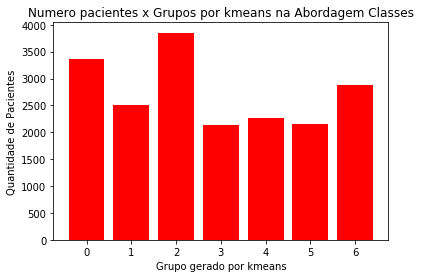

In [184]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest_classes = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = []
qtds = []

contagem = Counter(grupos_classes)

for i in range(0,n_classes):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Classes')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_AbordagemClasses_doenca_por_grupos.svg',format="svg")
plt.show()

In [185]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(array_classes, grupos_classes, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(array_classes, grupos_classes, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest_classes.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

In [186]:
#### Abordagem 7: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest_classes.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0     1     2     3     4     5     6
0  2064     0     0     0     0     0     0
1     0  1458     0     0     0     0     0
2     0     0  2313     0     0     0     0
3     0     0     0  1277     0     0     0
4     0     0     0     0  1345     0     0
5     0     0     0     0     0  1296     0
6     0     0     0     0     0     0  1739

In [187]:
#### Abordagem 7: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest_classes.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0     1     2    3    4    5     6
0  1303     0     0    0    0    0     0
1     0  1044     0    0    0    0     0
2     0     0  1539    0    0    0     0
3     0     0     0  850    0    0     0
4     0     0     0    0  923    0     0
5     0     0     0    0    0  859     0
6     0     0     0    0    0    0  1144

In [188]:
# Importância para Categorias

importancia = pd.DataFrame({'features':ls_classes,'importance':np.round(random_forest_classes.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_categoria.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1                idade       0.332
2                  IMC       0.312
6              Dipping       0.117
7          Non Dipping       0.108
9      Reverse Dipping       0.044
10       Morning Surge       0.040
0               genero       0.024
8      Extreme Dipping       0.019
3           Hipotensao       0.002
12           Whitecoat       0.001
4    Sistolica Isolada       0.000
5   Diastolica Isolada       0.000
11              Masked       0.000

# Abordagem 8: Extratificação do Sexo Masculino

In [189]:
#   Gera uma lista com cabeçalhos

ls_sist_diast = list(dataset_masc_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dataset_masc_medidas_sem_id = dataset_masc_medidas.loc[:,'sist 9:00':'diast 8:45']

dataset_masc_medidas_sem_id


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
0          105.0      108.0      116.0      104.0       106.0        98.0   
1          103.0      114.0       82.0      104.0        98.0       106.0   
2          147.0      148.0      156.0      140.0       130.0       132.0   
4          113.0      110.0      101.0      108.0       111.0       111.0   
5          152.0      152.0      152.0      152.0       154.0       138.0   
...          ...        ...        ...        ...         ...         ...   
19143      105.0      117.0       86.0      110.0       114.0       117.0   
19148      119.0      116.0      113.0      110.0       115.0       117.0   
19149      163.0      198.0      172.0      148.0       161.0       156.0   
19150      114.0      120.0      164.0      116.0       119.0       126.0   
19153      111.0      104.0      103.0      101.0        97.0       110.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
0           102.0       107.0       111.0       116.0  ...        41.0   
1           108.0       107.0       109.0       100.0  ...        74.0   
2           121.0       113.0       149.0       128.0  ...        80.0   
4           114.0       115.0       113.0       112.0  ...        64.0   
5           137.0       152.0        95.0       117.0  ...        67.0   
...           ...         ...         ...         ...  ...         ...   
19143       119.0       119.0       119.0        96.0  ...        78.0   
19148       112.0       119.0       111.0       112.0  ...        83.0   
19149       156.0       138.0       107.0        76.0  ...       102.0   
19150       123.0       122.0       122.0       159.0  ...        87.0   
19153       111.0       116.0       104.0       121.0  ...        67.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
0            46.0        51.0        56.0        61.0        67.0        61.0   
1            74.0        74.0        70.0        67.0        63.0        60.0   
2            86.0        93.0        91.0        89.0        87.0        86.0   
4            73.0        83.0        93.0        68.0        91.0        87.0   
5            94.0       120.0       109.0       109.0       110.0       111.0   
...           ...         ...         ...         ...         ...         ...   
19143        78.0        77.0        65.0        64.0        54.0        60.0   
19148        80.0        78.0        72.0        66.0        70.0        75.0   
19149       114.0       126.0       125.0       124.0       123.0       123.0   
19150        73.0        59.0        74.0        68.0        86.0        96.0   
19153        68.0        69.0        71.0        73.0        56.0        57.0   

       diast 8:15  diast 8:30  diast 8:45  
0            69.0        62.0        51.0  
1            74.0        70.0        67.0  
2            87.0        82.0        82.0  
4            84.0        81.0        72.0  
5           112.0       114.0       115.0  
...           ...         ...         ...  
19143        62.0        65.0        63.0  
19148        66.0        83.0        82.0  
19149       121.0       119.0       123.0  
19150       107.0       106.0        93.0  
19153        65.0        68.0        82.0  

[8707 rows x 164 columns]

## Abordagem 8: Número de Clusters gerado pelo k-Means

In [190]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_masc = calculate_wcss(dataset_masc_medidas_sem_id)
num_otimo_clusters_masc = optimal_number_of_clusters(sum_of_squares_masc)
num_otimo_clusters_masc

Wall time: 17.1 s


6

In [191]:
#convertendo os dados para a clusterização

dataset_masc_medidas_array = np.array(dataset_masc_medidas_sem_id)

In [192]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_masc = KMeans(n_clusters=num_otimo_clusters_masc, random_state=42).fit(dataset_masc_medidas_array)

In [193]:
#listar os grupos 

%time grupos_masc = kmeans_masc.fit_predict(dataset_masc_medidas_array)

Wall time: 624 ms


##  Abordagem 8: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

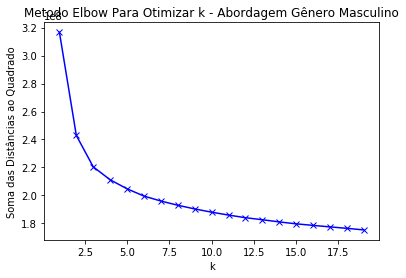

Wall time: 97.8 ms


In [194]:
#metodo de Elbow

Sum_of_squared_distances_masc = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_masc_medidas_array)
    Sum_of_squared_distances_masc.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances_masc, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Gênero Masculino')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medidas_masc.svg', format="svg")
%time plt.show()

## Abordagem 8: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.19942216996597537
Para n_clusters = 3 O score_silhouette medio e : 0.1266221740260475
Para n_clusters = 4 O score_silhouette medio e : 0.08162051200056061
Para n_clusters = 5 O score_silhouette medio e : 0.07666915468723748
Para n_clusters = 6 O score_silhouette medio e : 0.061193553449507415
Para n_clusters = 7 O score_silhouette medio e : 0.05739256562054491
Para n_clusters = 8 O score_silhouette medio e : 0.05523430502539047


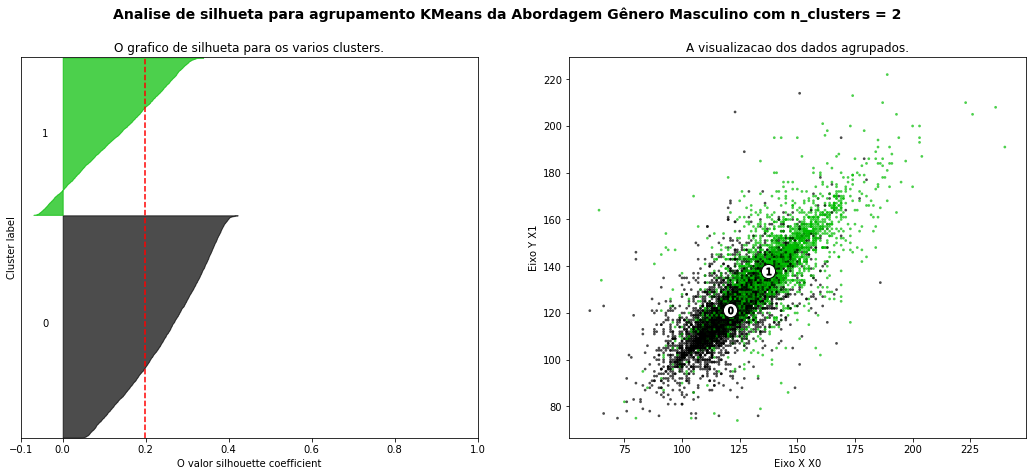

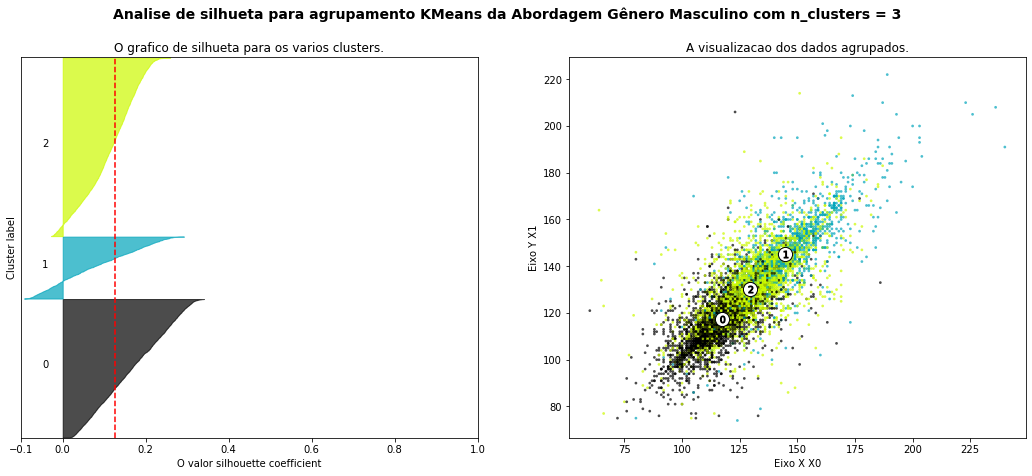

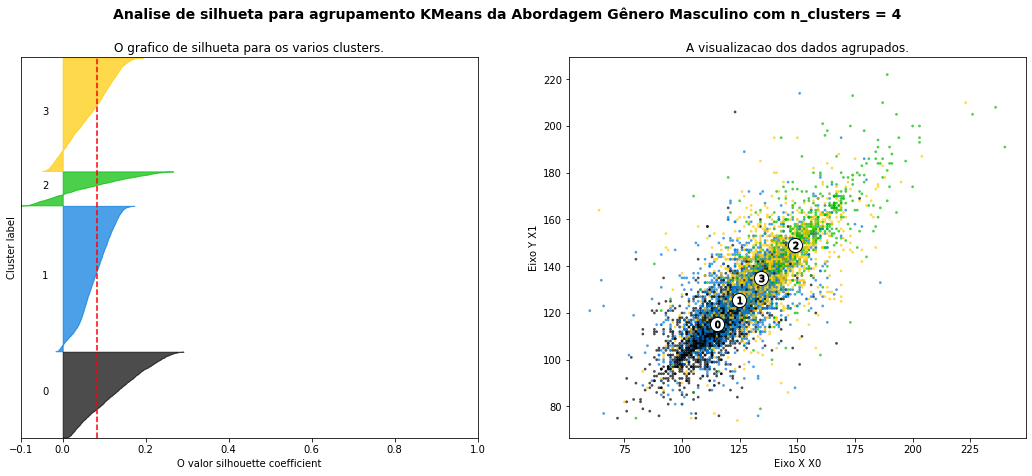

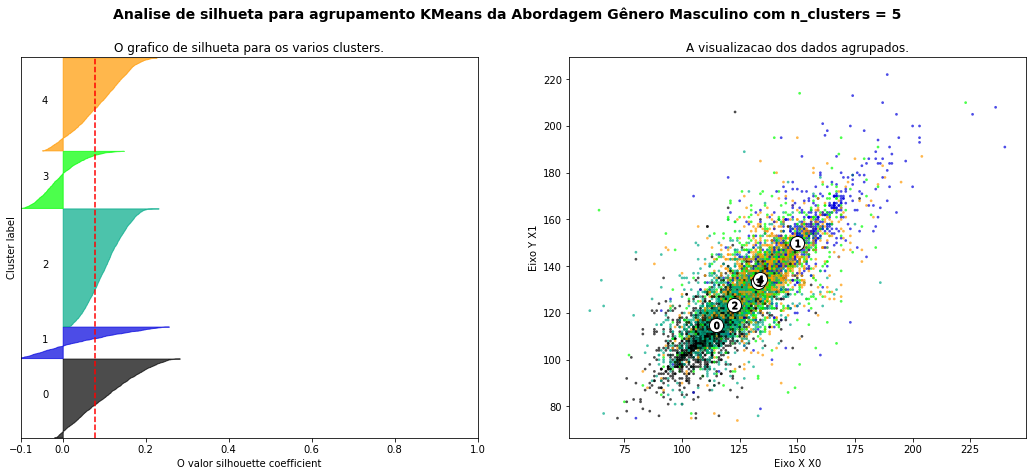

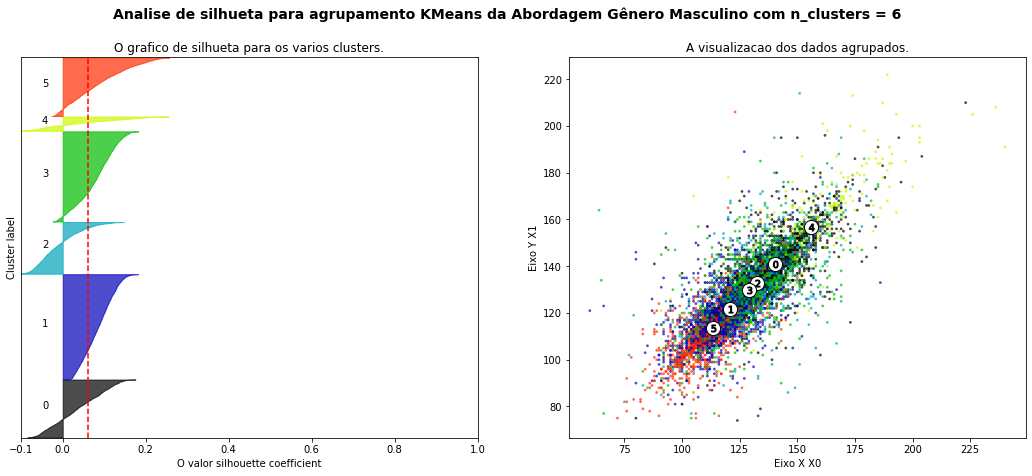

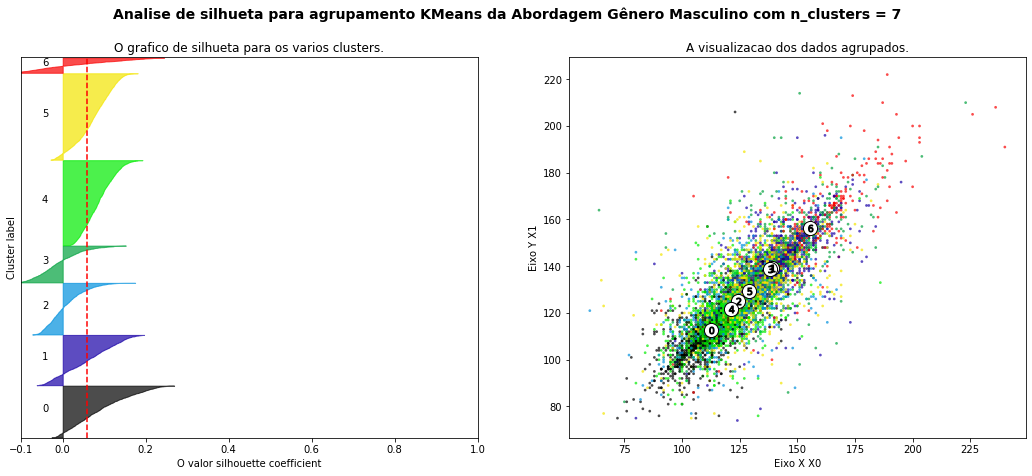

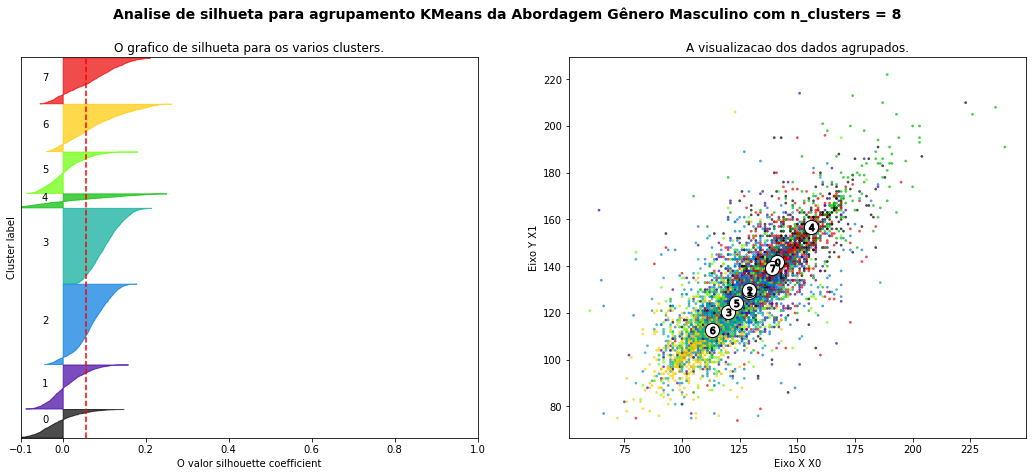

In [195]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dataset_masc_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dataset_masc_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dataset_masc_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dataset_masc_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dataset_masc_medidas_array[:, 0], dataset_masc_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Gênero Masculino "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_masc_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [196]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
genero_M_F = {"genero": {1: "M", 0: "F"}}

dataset_masc_apos_kmeans = dataset_masc.loc[:,'numero_identificacao':'data_exame']

dataset_masc_apos_kmeans['grupo'] = grupos_masc

dataset_masc_apos_kmeans['grupo'] = dataset_masc_apos_kmeans['grupo'] + 1

dataset_masc_apos_kmeans = pd.concat([dataset_masc_apos_kmeans,
                                         dataset_masc.loc[:,'sist 9:00':]],axis=1)

dataset_masc_apos_kmeans = dataset_masc_apos_kmeans.replace(genero_M_F)

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_masc_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

dataset_masc_apos_kmeans

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
0                         4      1923-10-05      M   94.0   85.0    160  33.2   
1                         5      1948-10-07      M   70.0   80.0    165  29.4   
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
4                         8      1990-03-07      M   28.0  120.0    172  40.6   
5                         9      1982-04-28      M   36.0  100.0    185  29.2   
...                     ...             ...    ...    ...    ...    ...   ...   
19143                 21775      1955-09-04      M   65.0   94.0   1,83  28.1   
19148                 21783      1969-05-24      M   51.0   93.0    168  33.0   
19149                 21786      1972-11-25      M   47.0   75.0    165  27.5   
19150                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19153                 21793      1971-01-14      M   49.0   99.0    179  30.9   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
0      2018-09-10 12:25:23      6      105.0  ...                       59.0   
1      2018-12-26 07:39:41      6      103.0  ...                       62.0   
2      2018-12-26 08:06:19      3      147.0  ...                       79.0   
4      2018-12-26 08:26:59      2      113.0  ...                       78.0   
5      2018-12-26 09:56:35      5      152.0  ...                      104.5   
...                    ...    ...        ...  ...                        ...   
19143  2020-09-10 14:40:03      2      105.0  ...                       78.0   
19148  2020-09-10 15:40:30      2      119.0  ...                       74.0   
19149  2020-09-10 16:03:08      5      163.0  ...                      116.0   
19150  2020-09-10 16:21:02      1      114.0  ...                       85.0   
19153  2020-09-10 17:42:01      4      111.0  ...                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
4                    9141.5                 6118.0          2405.0   
5                   11583.0                 8198.0          2783.5   
...                     ...                    ...             ...   
19143                9742.5                 6171.5          2984.5   
19148                9121.5                 5963.5          2605.0   
19149               12224.5                 9265.0          2439.0   
19150               10970.0                 6819.0          3319.0   
19153                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
4                 566.0                12.27                 12.79   
5                 558.5                10.83                 12.82   
...                 ...                  ...                   ...   
19143             546.0                14.42                  8.85   
19148             513.0                14.69                 11.86   
19149             474.5                18.66                 14.80   
19150             738.0                17.22                 13.67   
19153             612.0                13.92                 12.71   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
0                   11                34             0.966110  
1                    9                23             0.969464  
2                   19                19             1.055812  
4                   10                11             1.136996  
5                   37                52             1.051359  
...    

### Abordagem 8: Random Forest

In [197]:
from sklearn.ensemble import RandomForestClassifier

In [198]:
#parametro simples do modelo
random_forest_masc = RandomForestClassifier(n_estimators=50)

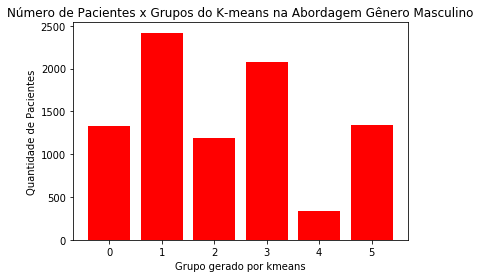

In [199]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_masc)

for i in range(0,num_otimo_clusters_masc):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Gênero Masculino')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem9_pacientes_masculino_por_grupos.svg',format="svg")
plt.show()


In [200]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dataset_masc_medidas_array, grupos_masc, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dataset_masc_medidas_array, grupos_masc, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [201]:
#treino
random_forest_masc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 8: VALIDAÇÃO

In [202]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_masc.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [203]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [204]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3    4    5
0  809     0    0     0    0    0
1    0  1476    0     0    0    0
2    0     0  725     0    0    0
3    0     0    0  1213    0    0
4    0     0    0     0  189    0
5    0     0    0     0    0  812

#### Abordagem 8: TESTE

In [205]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_masc.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [206]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9121447028423773 - Recall: 0.8720332128612768 - F1 Score: 0.8955281767730637


In [207]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2    3   4    5
0  485    0    8   33   0    0
1    0  907    6   22   0    9
2    8   51  382   27   0    1
3   17   29    2  820   0    0
4   46    0    0    0  97    0
5    0   45    2    0   0  486

In [208]:
dataset_masc_apos_kmeans.describe()


numero_identificacao        idade         peso          IMC  \
count           8707.000000  8707.000000  8707.000000  8707.000000   
mean           10844.831285    53.199839    85.743195    28.293522   
std             6289.651564    15.636038    16.138884     4.521842   
min                4.000000    18.000000    37.000000    12.100000   
25%             5395.500000    41.000000    75.000000    25.300000   
50%            10814.000000    52.000000    84.000000    27.700000   
75%            16320.500000    65.000000    95.000000    30.500000   
max            21793.000000   100.000000   200.000000    85.400000   

             grupo    sist 9:00    sist 9:15    sist 9:30    sist 9:45  \
count  8707.000000  8707.000000  8707.000000  8707.000000  8707.000000   
mean      3.194097   127.593431   128.055587   128.242449   128.129436   
std       1.623469    16.385359    16.552741    16.542565    16.336975   
min       1.000000    60.000000    74.000000    62.000000    63.000000   
25%       2.000000   117.000000   117.000000   118.000000   118.000000   
50%       3.000000   127.000000   127.000000   127.000000   127.000000   
75%       4.000000   137.000000   138.000000   138.000000   138.000000   
max       6.000000   240.000000   222.000000   257.000000   230.000000   

        sist 10:00  ...  Mediana Diastolica em 24h  AUC Sistolica em 24h  \
count  8707.000000  ...                8707.000000           8707.000000   
mean    127.883083  ...                  79.808660          10042.275698   
std      16.261810  ...                   9.404435            883.561835   
min      62.000000  ...                  43.000000           7438.500000   
25%     117.000000  ...                  73.500000           9439.500000   
50%     127.000000  ...                  79.500000           9966.000000   
75%     137.000000  ...                  86.000000          10532.000000   
max     232.000000  ...                 132.000000          15047.500000   

       AUC Diastolica em 24h  AUC PP Daytime  AUC PP Nighttime  \
count            8707.000000     8707.000000       8707.000000   
mean             6413.351384     2992.135868        590.603652   
std               724.911011      542.312069        111.071400   
min              3674.500000     1706.000000        301.000000   
25%              5925.750000     2608.000000        513.500000   
50%              6379.500000     2917.500000        574.500000   
75%              6859.500000     3289.000000        651.000000   
max             10530.500000     5885.000000       1250.500000   

       DP Sistolica em 24h  DP Diastolica em 24h  Picos Sistolica  \
count          8707.000000           8707.000000      8707.000000   
mean             12.545063             10.709348        15.391869   
std               3.189408              2.319481        13.192965   
min               5.070000              3.980000         0.000000   
25%              10.305000              9.050000         6.000000   
50%              12.120000             10.520000        11.000000   
75%              14.280000             12.130000        20.000000   
max              38.360000             23.850000        81.000000   

       Picos Diastolica  Diferença % Dipping  
count       8707.000000          8707.000000  
mean          21.114965             1.086473  
std           14.506302             0.080120  
min            0.000000             0.784534  
25%           11.000000             1.034538  
50%           17.000000             1.086400  
75%           28.000000             1.137542  
max           79.000000             1.491723  

[8 rows x 194 columns]

In [209]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_masc_apos_kmeans, grupos_masc, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_masc_apos_kmeans, grupos_masc, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 8: Importância das Features Random Forest

In [210]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_masc.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
95   diast 12:15       0.016
46    sist 20:30       0.016
94   diast 12:00       0.014
41    sist 19:15       0.014
93   diast 11:45       0.013
..           ...         ...
146   diast 3:00       0.003
150   diast 5:00       0.002
152   diast 6:00       0.002
149   diast 4:30       0.002
145   diast 2:30       0.002

[164 rows x 2 columns]

# Abordagem 9: Extratificação do Sexo Feminino

In [211]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45

#   Gera uma lista com cabeçalhos
ls_sist_diast = list(dataset_fem_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dataset_fem_medidas_sem_id = dataset_fem_medidas.loc[:,'sist 9:00':'diast 8:45']

dataset_fem_medidas_sem_id


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
3          140.0      139.0      142.0      137.0       135.0       177.0   
9          131.0      131.0      130.0      129.0       129.0       111.0   
10         107.0      110.0      113.0      116.0       120.0       108.0   
11         166.0      171.0      176.0      181.0       186.0       192.0   
13         142.0      123.0      124.0      135.0       147.0       159.0   
...          ...        ...        ...        ...         ...         ...   
19145      137.0      121.0      118.0      148.0       111.0       115.0   
19146      153.0      149.0      136.0      152.0       157.0       153.0   
19147      121.0      123.0      125.0      122.0       120.0       118.0   
19151      107.0      110.0      103.0      105.0       108.0       111.0   
19152       94.0      107.0      112.0      124.0       120.0        94.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
3           148.0       152.0       135.0       136.0  ...        49.0   
9           122.0       133.0       144.0       155.0  ...        58.0   
10          105.0       108.0       114.0       105.0  ...        57.0   
11          177.0       168.0       159.0       150.0  ...        79.0   
13          142.0       141.0       133.0       141.0  ...        83.0   
...           ...         ...         ...         ...  ...         ...   
19145       111.0       128.0       136.0       133.0  ...        70.0   
19146       141.0       135.0       136.0       134.0  ...        88.0   
19147       120.0       117.0       121.0       149.0  ...        66.0   
19151       114.0       144.0       128.0       104.0  ...        49.0   
19152       102.0       113.0       104.0        96.0  ...        63.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
3            56.0        62.0        83.0       104.0        99.0        94.0   
9            99.0       140.0        67.0        81.0        95.0        94.0   
10           61.0        65.0        70.0        66.0        78.0        67.0   
11           98.0       116.0       114.0       113.0       111.0       110.0   
13           76.0        68.0        86.0        64.0       100.0        88.0   
...           ...         ...         ...         ...         ...         ...   
19145        61.0        52.0        50.0        52.0        65.0        72.0   
19146        90.0        93.0       104.0        94.0        91.0        99.0   
19147        66.0        67.0        65.0        85.0        82.0        82.0   
19151        50.0        50.0        53.0        52.0        62.0        68.0   
19152        63.0        64.0        76.0        72.0        69.0        75.0   

       diast 8:15  diast 8:30  diast 8:45  
3            89.0        90.0        72.0  
9            94.0        94.0        93.0  
10           73.0        75.0        66.0  
11          108.0       107.0       105.0  
13          110.0       119.0        90.0  
...           ...         ...         ...  
19145        79.0        57.0        77.0  
19146        96.0       103.0        98.0  
19147        85.0        87.0        86.0  
19151        61.0        64.0        60.0  
19152        74.0        69.0        67.0  

[10447 rows x 164 columns]

## Abordagem 9: Número de Clusters gerado pelo k-Means

In [212]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_fem = calculate_wcss(dataset_fem_medidas_sem_id)
num_otimo_clusters_fem = optimal_number_of_clusters(sum_of_squares_fem)
num_otimo_clusters_fem

Wall time: 22.6 s


7

In [213]:
#convertendo os dados para a clusterização

dataset_fem_medidas_array = np.array(dataset_fem_medidas_sem_id)

In [214]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_fem = KMeans(n_clusters=num_otimo_clusters_fem, random_state=42).fit(dataset_fem_medidas_array)

In [215]:
#listar os grupos 

grupos_fem = kmeans_fem.fit_predict(dataset_fem_medidas_array)

##  Abordagem 9: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

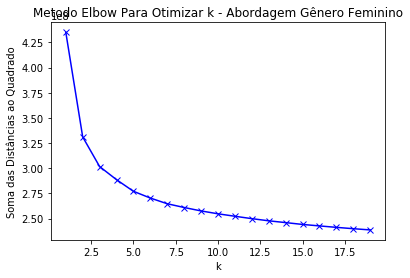

Wall time: 90 ms


In [216]:
#metodo de Elbow

Sum_of_squared_distances_fem = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_fem_medidas_array)
    Sum_of_squared_distances_fem.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances_fem, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Gênero Feminino')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medidas_fem.svg', format="svg")
%time plt.show()

## Abordagem 9: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.214345501193772
Para n_clusters = 3 O score_silhouette medio e : 0.12848844427503492
Para n_clusters = 4 O score_silhouette medio e : 0.11003965138943071
Para n_clusters = 5 O score_silhouette medio e : 0.07800066968703923
Para n_clusters = 6 O score_silhouette medio e : 0.07205913018871833
Para n_clusters = 7 O score_silhouette medio e : 0.055258589661288285
Para n_clusters = 8 O score_silhouette medio e : 0.053793083706097054


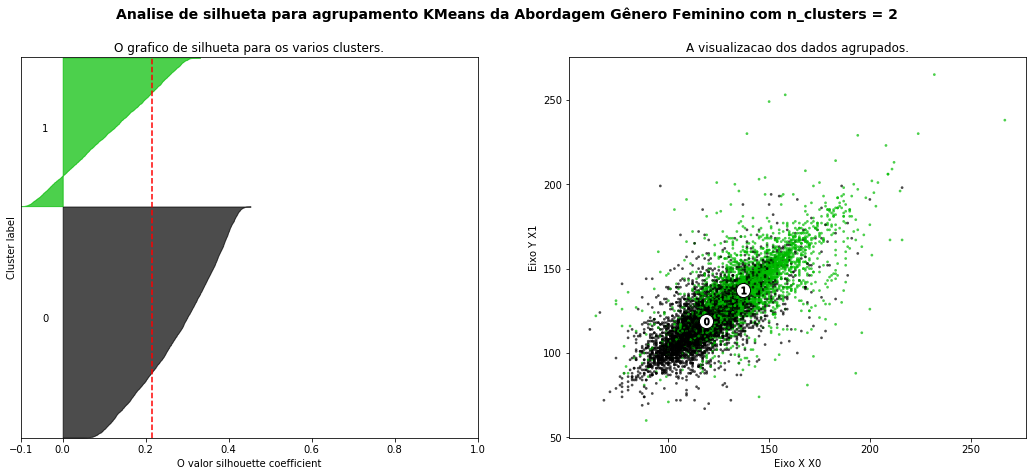

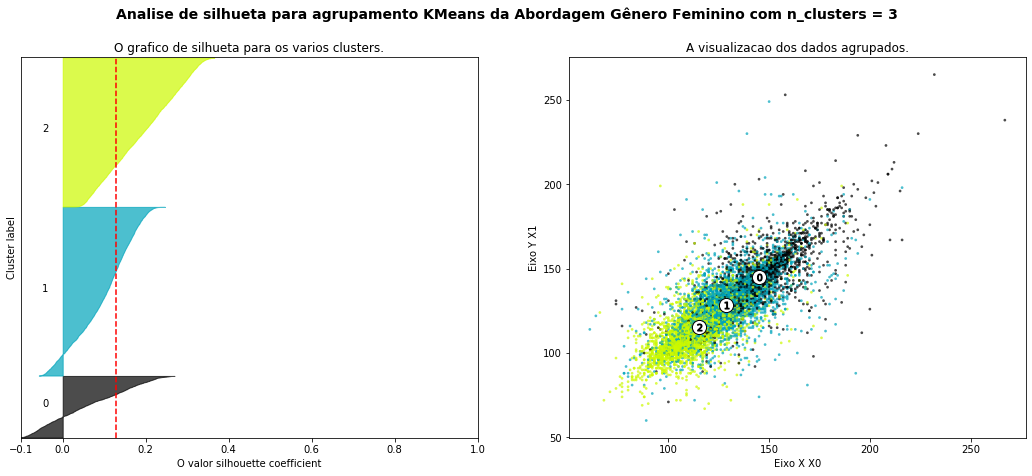

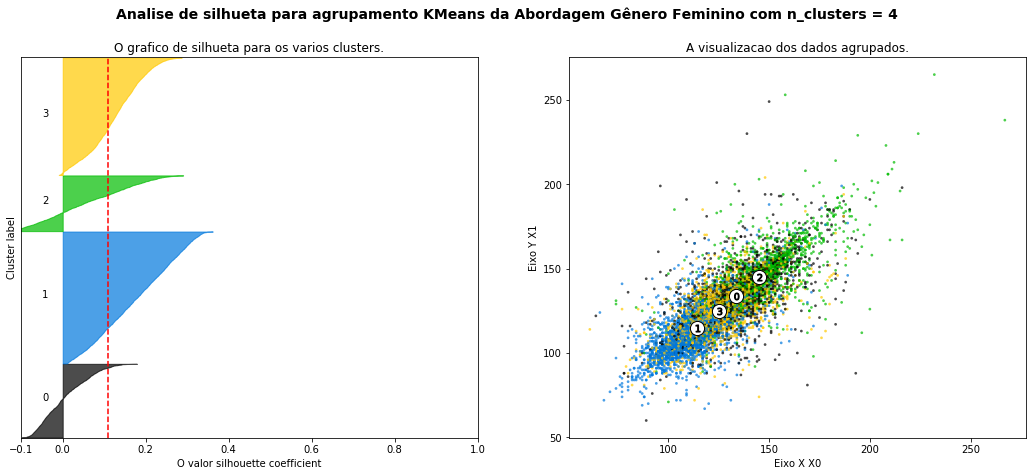

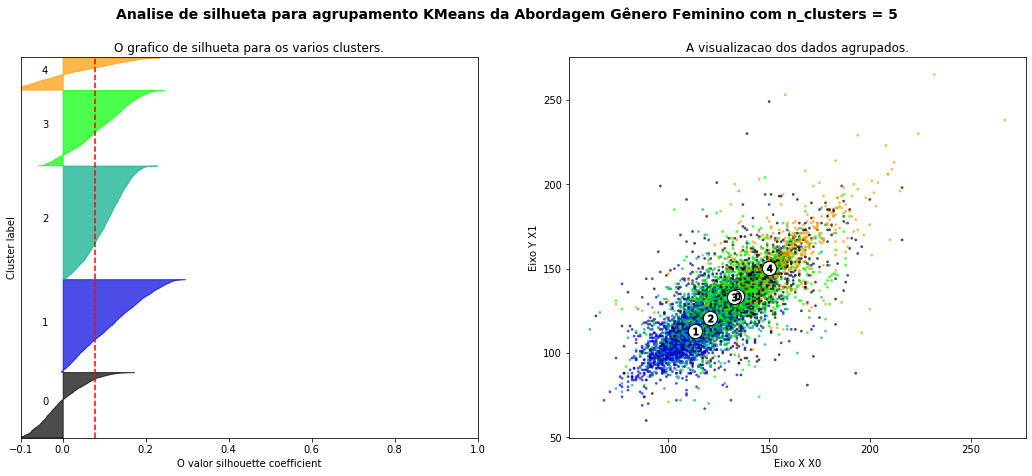

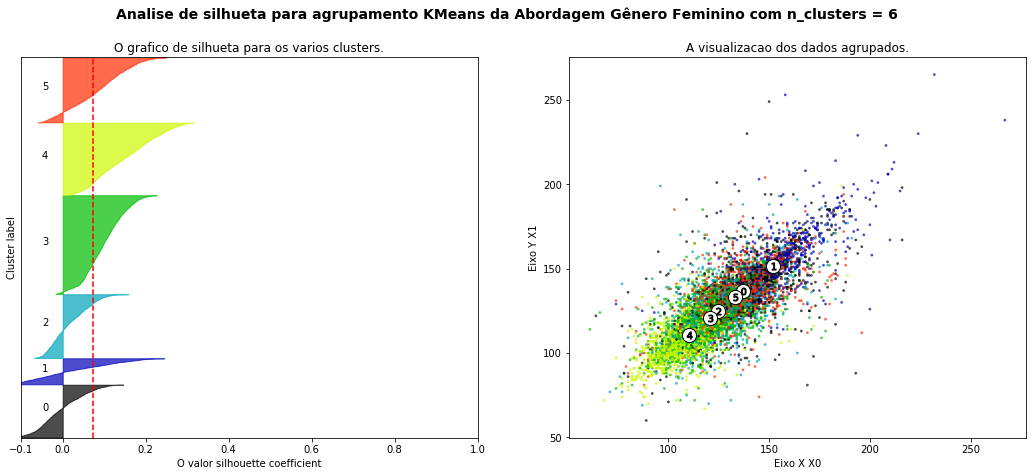

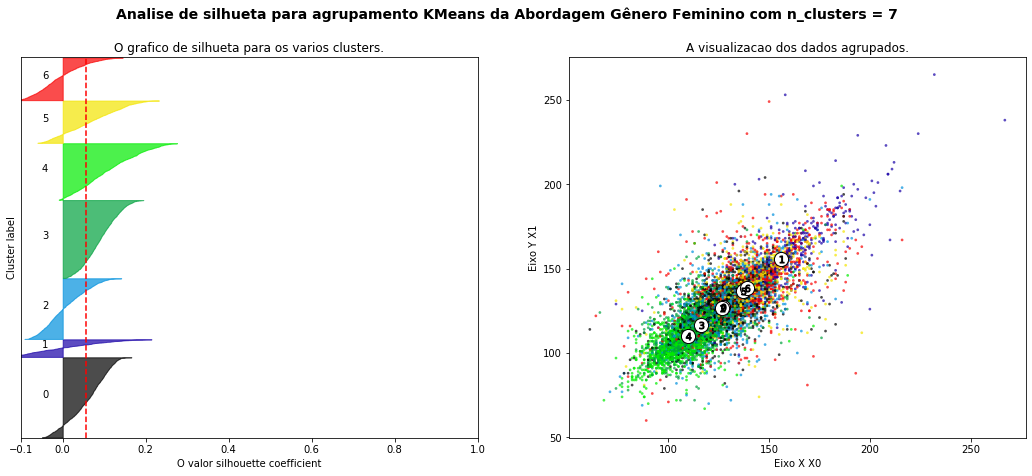

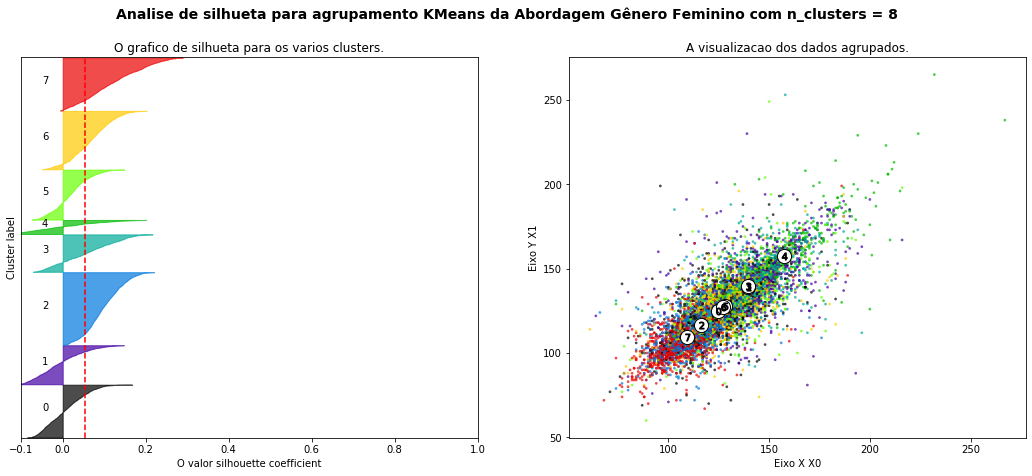

In [217]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dataset_fem_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dataset_fem_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dataset_fem_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dataset_fem_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dataset_fem_medidas_array[:, 0], dataset_fem_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Gênero Feminino "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_fem_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [218]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
dataset_fem_apos_kmeans = dataset_fem.loc[:,'numero_identificacao':'data_exame']

dataset_fem_apos_kmeans['grupo'] = grupos_fem

dataset_fem_apos_kmeans['grupo'] = dataset_fem_apos_kmeans['grupo'] + 1

dataset_fem_apos_kmeans = pd.concat([dataset_fem_apos_kmeans,
                                         dataset_fem.loc[:,'sist 9:00':]],axis=1)

dataset_fem_apos_kmeans = dataset_fem_apos_kmeans.replace(genero_M_F)

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_fem_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

dataset_fem_apos_kmeans

numero_identificacao data_nascimento genero  idade  peso altura   IMC  \
3                         7      1978-01-26      F   40.0  65.0   1,64  24.2   
9                        13      1963-06-23      F   55.0  60.0    158  24.0   
10                       14      1932-05-28      F   86.0  59.0    149  26.6   
11                       15      1933-02-16      F   85.0  68.0    151  29.8   
13                       18      1953-04-18      F   65.0  72.0    172  24.3   
...                     ...             ...    ...    ...   ...    ...   ...   
19145                 21779      1947-04-19      F   73.0  71.0    159  28.1   
19146                 21781      1947-04-18      F   73.0  92.0    168  32.6   
19147                 21782      1979-05-23      F   41.0  56.0   1,58  22.4   
19151                 21788      1985-03-15      F   35.0  93.0    167  33.3   
19152                 21792      1952-04-21      F   68.0  64.0    160  25.0   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
3      2018-12-26 08:19:06      7      140.0  ...                       80.0   
9      2018-12-26 10:04:36      1      131.0  ...                       70.0   
10     2018-12-26 10:06:10      5      107.0  ...                       66.0   
11     2018-12-26 10:08:12      7      166.0  ...                       74.0   
13     2018-12-26 10:15:40      6      142.0  ...                       87.0   
...                    ...    ...        ...  ...                        ...   
19145  2020-09-10 15:13:35      3      137.0  ...                       68.0   
19146  2020-09-10 15:18:46      2      153.0  ...                       93.0   
19147  2020-09-10 15:31:01      4      121.0  ...                       83.0   
19151  2020-09-10 16:44:53      5      107.0  ...                       62.0   
19152  2020-09-10 17:25:50      4       94.0  ...                       68.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
3                   10679.5                 6420.5          3642.0   
9                    9767.5                 6112.0          3093.0   
10                   8810.5                 5280.5          2900.5   
11                  11307.5                 6435.5          3922.0   
13                  11003.5                 6952.5          3237.0   
...                     ...                    ...             ...   
19145                9369.5                 5393.5          3321.0   
19146               11726.0                 7390.0          3668.0   
19147                9108.0                 6613.5          2069.5   
19151                9245.0                 4935.5          3556.0   
19152                8989.5                 5660.0          2815.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
3                 602.5                16.13                 10.34   
9                 506.0                19.92                 15.62   
10                574.0                 8.15                  7.86   
11                868.5                16.56                  9.47   
13                735.5                18.78                 14.23   
...                 ...                  ...                   ...   
19145             604.0                13.71                 10.41   
19146             618.0                20.56                 12.37   
19147             391.5                14.49                 12.30   
19151             713.5                14.36                  8.29   
19152             460.0                14.14                  9.38   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
3                   21                 9             1.106757  
9                   19                22             1.184304  
10                  11                16             1.115168  
11                  26                 4             0.999183  
13                  37                28             1.024866  
...                

### Abordagem 9: Random Forest

In [219]:
from sklearn.ensemble import RandomForestClassifier

In [220]:
#parametro simples do modelo
random_forest_fem = RandomForestClassifier(n_estimators=50)

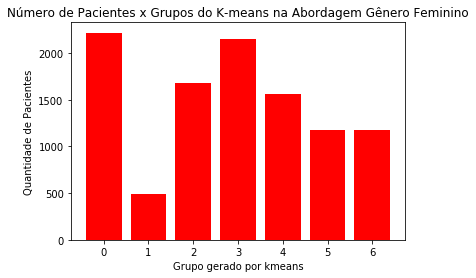

In [221]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_fem)

for i in range(0,num_otimo_clusters_fem):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Gênero Feminino')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem9_pacientes_feminino_por_grupos.svg',format="svg")
plt.show()


In [222]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dataset_fem_medidas_array, grupos_fem, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dataset_fem_medidas_array, grupos_fem, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [223]:
#treino
random_forest_fem.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 9: VALIDAÇÃO

In [224]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_fem.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [225]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [226]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2     3    4    5    6
0  1349    0    0     0    0    0    0
1     0  300    0     0    0    0    0
2     0    0  987     0    0    0    0
3     0    0    0  1322    0    0    0
4     0    0    0     0  917    0    0
5     0    0    0     0    0  683    0
6     0    0    0     0    0    0  710

#### Abordagem 9: TESTE

In [227]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_fem.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9140942809284518 - Recall: 0.9025475435493172 - F1 Score: 0.9130373435321752


In [228]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2    3    4    5    6
0  838    0    4   20    0    4    3
1    0  162    0    0    0   16    9
2   16    0  625   36    9    0    6
3   32    0   17  770   13    0    0
4    0    0   12   33  600    0    0
5   48    2    0    0    0  435    3
6   35    4   23    0    0   14  390

In [229]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_fem_apos_kmeans, grupos_fem, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_fem_apos_kmeans, grupos_fem, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 9: Importância das Features Random Forest

In [230]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_fem.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)
importancia

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

# Abordagem 10: Sistólicas separadas

In [231]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45 em listas separadas

ls_sistolica = list(dataset_medidas.loc[:,'sist 9:00':'sist 8:45'].columns)
sistolica_sem_id = dataset_medidas.loc[:,'sist 9:00':'sist 8:45']


## Abordagem 10: Número de Clusters gerado pelo k-Means

In [232]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_sistolica = calculate_wcss(sistolica_sem_id)
num_otimo_clusters_sistolica = optimal_number_of_clusters(sum_of_squares_sistolica)
num_otimo_clusters_sistolica

Wall time: 29.1 s


6

In [233]:
#convertendo os dados para a clusterização

sistolica_array = np.array(sistolica_sem_id)

In [234]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_sistolica = KMeans(n_clusters=num_otimo_clusters_sistolica, random_state=42).fit(sistolica_array)

In [235]:
#listar os grupos 

grupos_sistolica = kmeans_sistolica.fit_predict(sistolica_array)

In [236]:
#incluir grupos nos dados de sist e diast

sistolica_sem_id['grupo'] = grupos_sistolica
sistolica_sem_id['grupo'] = sistolica_sem_id['grupo'] + 1
sistolica_sem_id

sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
0          105.0      108.0      116.0      104.0       106.0        98.0   
1          103.0      114.0       82.0      104.0        98.0       106.0   
2          147.0      148.0      156.0      140.0       130.0       132.0   
3          140.0      139.0      142.0      137.0       135.0       177.0   
4          113.0      110.0      101.0      108.0       111.0       111.0   
...          ...        ...        ...        ...         ...         ...   
19149      163.0      198.0      172.0      148.0       161.0       156.0   
19150      114.0      120.0      164.0      116.0       119.0       126.0   
19151      107.0      110.0      103.0      105.0       108.0       111.0   
19152       94.0      107.0      112.0      124.0       120.0        94.0   
19153      111.0      104.0      103.0      101.0        97.0       110.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  sist 6:45  \
0           102.0       107.0       111.0       116.0  ...       94.0   
1           108.0       107.0       109.0       100.0  ...      111.0   
2           121.0       113.0       149.0       128.0  ...      136.0   
3           148.0       152.0       135.0       136.0  ...      104.0   
4           114.0       115.0       113.0       112.0  ...      116.0   
...           ...         ...         ...         ...  ...        ...   
19149       156.0       138.0       107.0        76.0  ...      162.0   
19150       123.0       122.0       122.0       159.0  ...      136.0   
19151       114.0       144.0       128.0       104.0  ...       96.0   
19152       102.0       113.0       104.0        96.0  ...      124.0   
19153       111.0       116.0       104.0       121.0  ...      105.0   

       sist 7:00  sist 7:15  sist 7:30  sist 7:45  sist 8:00  sist 8:15  \
0           92.0       91.0       89.0       88.0      115.0      114.0   
1          113.0      113.0      113.0      113.0      114.0      111.0   
2          136.0      135.0      134.0      133.0      133.0      137.0   
3          111.0      128.0      145.0      147.0      150.0      153.0   
4          124.0      132.0       93.0      118.0      114.0      110.0   
...          ...        ...        ...        ...        ...        ...   
19149      166.0      166.0      166.0      166.0      167.0      162.0   
19150      116.0      113.0      113.0      146.0      146.0      147.0   
19151       95.0      100.0      110.0      116.0      113.0      124.0   
19152      133.0      121.0      114.0      108.0      115.0      105.0   
19153      108.0      111.0      105.0       90.0       98.0       98.0   

       sist 8:30  sist 8:45  grupo  
0          111.0      102.0      5  
1          102.0      116.0      3  
2          169.0      143.0      4  
3          153.0      185.0      4  
4          106.0      116.0      5  
...          ...        ...    ...  
19149      156.0      148.0      6  
19150      145.0      142.0      4  
19151      114.0      113.0      5  
19152      113.0      101.0      3  
19153      103.0      113.0      5  

[19154 rows x 83 columns]

In [237]:

# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

dataset_sistolica_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'data_exame']

dataset_sistolica_apos_kmeans = pd.concat([dataset_sistolica_apos_kmeans, sistolica_sem_id['grupo'],
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_sistolica_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 10 (medidas)
#dataset_sistolica_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_sistolica.csv', 
#             sep=';',index=False,encoding='UTF-8')


numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19149                 21786      1972-11-25       1   47.0   75.0    165   
19150                 21787      1970-10-19       1   49.0   90.0    183   
19151                 21788      1985-03-15       0   35.0   93.0    167   
19152                 21792      1952-04-21       0   68.0   64.0    160   
19153                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      5      105.0  ...   
1      29.4  2018-12-26 07:39:41      3      103.0  ...   
2      25.8  2018-12-26 08:06:19      4      147.0  ...   
3      24.2  2018-12-26 08:19:06      4      140.0  ...   
4      40.6  2018-12-26 08:26:59      5      113.0  ...   
...     ...                  ...    ...        ...  ...   
19149  27.5  2020-09-10 16:03:08      6      163.0  ...   
19150  26.9  2020-09-10 16:21:02      4      114.0  ...   
19151  33.3  2020-09-10 16:44:53      5      107.0  ...   
19152  25.0  2020-09-10 17:25:50      3       94.0  ...   
19153  30.9  2020-09-10 17:42:01      5      111.0  ...   

       Mediana Sistolica em 24h  Mediana Diastolica em 24h  \
0                         118.5                       59.0   
1                         106.0                       62.0   
2                         133.0                       79.0   
3                         131.0                       80.0   
4                         115.0                       78.0   
...                         ...                        ...   
19149                     152.0                      116.0   
19150                     136.0                       85.0   
19151                     112.0                       62.0   
19152                     109.5                       68.0   
19153                     121.0                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
3                   10679.5                 6420.5          3642.0   
4                    9141.5                 6118.0          2405.0   
...                     ...                    ...             ...   
19149               12224.5                 9265.0          2439.0   
19150               10970.0                 6819.0          3319.0   
19151                9245.0                 4935.5          3556.0   
19152                8989.5                 5660.0          2815.5   
19153                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
3                 602.5                16.13                 10.34   
4                 566.0                12.27                 12.79   
...                 ...                  ...                   ...   
19149             474.5                18.66                 14.80   
19150             738.0                17.22                 13.67   
19151             713.5                14.36                  8.29   
19152             460.0                14.14                  9.38   
19153             612.0      

### Abordagem 10: Random Forest

In [238]:
from sklearn.ensemble import RandomForestClassifier

In [239]:
#parametro simples do modelo
random_forest_sistolica = RandomForestClassifier(n_estimators=50)

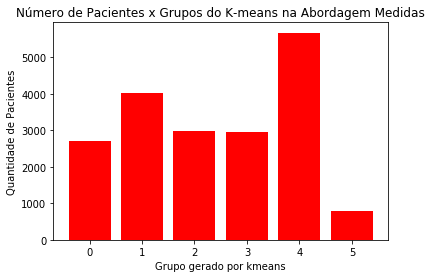

In [240]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_sistolica)

for i in range(0,num_otimo_clusters_sistolica):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem_sistolica_pacientes_por_grupos.svg',format="svg")
plt.show()


In [241]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(sistolica_array, grupos_sistolica, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(sistolica_array, grupos_sistolica, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [242]:
#treino
random_forest_sistolica.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 10: VALIDAÇÃO

In [243]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_sistolica.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [244]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4    5
0  1605     0     0     0     0    0
1     0  2461     0     0     0    0
2     0     0  1759     0     0    0
3     0     0     0  1747     0    0
4     0     0     0     0  3453    0
5     0     0     0     0     0  467

#### Abordagem 10: TESTE

In [245]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_sistolica.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9206473505612112 - Recall: 0.8960294820032031 - F1 Score: 0.913363354652209


In [246]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4    5
0  941    58     0    31    77    0
1   35  1441     0    19    64    0
2    0     0  1127     0   104    0
3   22    71     0  1121     0    0
4   21    24    13     0  2166    0
5    1     0     0    68     0  258

In [247]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_sistolica_apos_kmeans, grupos_sistolica, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_sistolica_apos_kmeans, grupos_sistolica, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 10: Importância das Features Random Forest

In [248]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sistolica,'importance':np.round(random_forest_sistolica.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia


features  importance
71   sist 6:15       0.031
73   sist 6:45       0.030
23  sist 14:45       0.023
37  sist 18:15       0.018
16  sist 13:00       0.017
..         ...         ...
1    sist 9:15       0.009
62   sist 2:00       0.009
54  sist 22:30       0.009
60   sist 1:00       0.009
0    sist 9:00       0.009

[82 rows x 2 columns]

# Abordagem 11: Diastólicas

In [249]:
ls_diastolica = list(dataset_medidas.loc[:,'diast 9:00':'diast 8:45'].columns)
diastolica_sem_id = dataset_medidas.loc[:,'diast 9:00':'diast 8:45']

## Abordagem 11: Número de Clusters gerado pelo k-Means

In [250]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_diastolica = calculate_wcss(diastolica_sem_id)
num_otimo_clusters_diastolica = optimal_number_of_clusters(sum_of_squares_diastolica)
num_otimo_clusters_diastolica

Wall time: 28.1 s


6

In [251]:
#convertendo os dados para a clusterização

diastolica_array = np.array(diastolica_sem_id)

In [252]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_diastolica = KMeans(n_clusters=num_otimo_clusters_diastolica, random_state=42).fit(diastolica_array)

In [253]:
#listar os grupos 

grupos_diastolica = kmeans_diastolica.fit_predict(diastolica_array)

In [254]:
#incluir grupos nos dados de sist e diast

diastolica_sem_id['grupo'] = grupos_diastolica
diastolica_sem_id['grupo'] = diastolica_sem_id['grupo'] + 1
diastolica_sem_id

diast 9:00  diast 9:15  diast 9:30  diast 9:45  diast 10:00  \
0            47.0        47.0        53.0        48.0         55.0   
1            60.0        54.0        59.0        57.0         62.0   
2            92.0        95.0        78.0        82.0         75.0   
3            81.0        90.0        90.0        89.0         83.0   
4            76.0        80.0        78.0        79.0         68.0   
...           ...         ...         ...         ...          ...   
19149       121.0       112.0       134.0       124.0        130.0   
19150        87.0        86.0        79.0        79.0         76.0   
19151        57.0        58.0        57.0        58.0         60.0   
19152        63.0        68.0        72.0        68.0         73.0   
19153        73.0        64.0        55.0        64.0         60.0   

       diast 10:15  diast 10:30  diast 10:45  diast 11:00  diast 11:15  ...  \
0             49.0         50.0         50.0         54.0         58.0  ...   
1             64.0         60.0         52.0         61.0         61.0  ...   
2             69.0         56.0         57.0         54.0         54.0  ...   
3             93.0         85.0         88.0         77.0         84.0  ...   
4             75.0         80.0         81.0         76.0         78.0  ...   
...            ...          ...          ...          ...          ...  ...   
19149        111.0        117.0        121.0         90.0         60.0  ...   
19150         78.0         76.0         80.0         83.0         84.0  ...   
19151         61.0         63.0         66.0         63.0         65.0  ...   
19152         60.0         60.0         71.0         74.0         69.0  ...   
19153         58.0         79.0         78.0         75.0         98.0  ...   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
0            46.0        51.0        56.0        61.0        67.0        61.0   
1            74.0        74.0        70.0        67.0        63.0        60.0   
2            86.0        93.0        91.0        89.0        87.0        86.0   
3            56.0        62.0        83.0       104.0        99.0        94.0   
4            73.0        83.0        93.0        68.0        91.0        87.0   
...           ...         ...         ...         ...         ...         ...   
19149       114.0       126.0       125.0       124.0       123.0       123.0   
19150        73.0        59.0        74.0        68.0        86.0        96.0   
19151        50.0        50.0        53.0        52.0        62.0        68.0   
19152        63.0        64.0        76.0        72.0        69.0        75.0   
19153        68.0        69.0        71.0        73.0        56.0        57.0   

       diast 8:15  diast 8:30  diast 8:45  grupo  
0            69.0        62.0        51.0      5  
1            74.0        70.0        67.0      5  
2            87.0        82.0        82.0      6  
3            89.0        90.0        72.0      6  
4            84.0        81.0        72.0      4  
...           ...         ...         ...    ...  
19149       121.0       119.0       123.0      2  
19150       107.0       106.0        93.0      3  
19151        61.0        64.0        60.0      5  
19152        74.0        69.0        67.0      1  
19153        65.0        68.0        82.0      4  

[19154 rows x 83 columns]

In [255]:

# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

dataset_diastolica_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'data_exame']

dataset_diastolica_apos_kmeans = pd.concat([dataset_diastolica_apos_kmeans, diastolica_sem_id['grupo'],
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_diastolica_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 10 (medidas)
#dataset_diastolica_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_diastolica.csv', 
#             sep=';',index=False,encoding='UTF-8')


numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19149                 21786      1972-11-25       1   47.0   75.0    165   
19150                 21787      1970-10-19       1   49.0   90.0    183   
19151                 21788      1985-03-15       0   35.0   93.0    167   
19152                 21792      1952-04-21       0   68.0   64.0    160   
19153                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      5      105.0  ...   
1      29.4  2018-12-26 07:39:41      5      103.0  ...   
2      25.8  2018-12-26 08:06:19      6      147.0  ...   
3      24.2  2018-12-26 08:19:06      6      140.0  ...   
4      40.6  2018-12-26 08:26:59      4      113.0  ...   
...     ...                  ...    ...        ...  ...   
19149  27.5  2020-09-10 16:03:08      2      163.0  ...   
19150  26.9  2020-09-10 16:21:02      3      114.0  ...   
19151  33.3  2020-09-10 16:44:53      5      107.0  ...   
19152  25.0  2020-09-10 17:25:50      1       94.0  ...   
19153  30.9  2020-09-10 17:42:01      4      111.0  ...   

       Mediana Sistolica em 24h  Mediana Diastolica em 24h  \
0                         118.5                       59.0   
1                         106.0                       62.0   
2                         133.0                       79.0   
3                         131.0                       80.0   
4                         115.0                       78.0   
...                         ...                        ...   
19149                     152.0                      116.0   
19150                     136.0                       85.0   
19151                     112.0                       62.0   
19152                     109.5                       68.0   
19153                     121.0                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
3                   10679.5                 6420.5          3642.0   
4                    9141.5                 6118.0          2405.0   
...                     ...                    ...             ...   
19149               12224.5                 9265.0          2439.0   
19150               10970.0                 6819.0          3319.0   
19151                9245.0                 4935.5          3556.0   
19152                8989.5                 5660.0          2815.5   
19153                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
3                 602.5                16.13                 10.34   
4                 566.0                12.27                 12.79   
...                 ...                  ...                   ...   
19149             474.5                18.66                 14.80   
19150             738.0                17.22                 13.67   
19151             713.5                14.36                  8.29   
19152             460.0                14.14                  9.38   
19153             612.0      

### Abordagem 11: Random Forest

In [256]:
from sklearn.ensemble import RandomForestClassifier

In [257]:
#parametro simples do modelo
random_forest_diastolica = RandomForestClassifier(n_estimators=50)

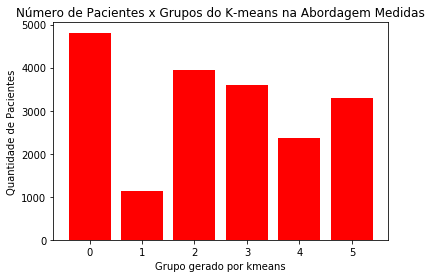

In [258]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_diastolica)

for i in range(0,num_otimo_clusters_diastolica):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem_diastolica_pacientes_por_grupos.svg',format="svg")
plt.show()


In [259]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(diastolica_array, grupos_diastolica, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(diastolica_array, grupos_diastolica, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [260]:
#treino
random_forest_diastolica.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 11: VALIDAÇÃO

In [261]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_diastolica.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [262]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1     2     3     4     5
0  2899    0     0     0     0     0
1     0  657     0     0     0     0
2     0    0  2365     0     0     0
3     0    0     0  2190     0     0
4     0    0     0     0  1411     0
5     0    0     0     0     0  1970

#### Abordagem 11: TESTE

In [263]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_diastolica.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.919994779430958 - Recall: 0.9092810152427614 - F1 Score: 0.9210909605364433


In [264]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1     2     3    4     5
0  1846    0     0    25    9    32
1     0  414    62     0    0     0
2     0    2  1516    38    0    17
3    51    0    56  1272    0    36
4    95    0     0     0  865     0
5    84    0    40    66    0  1136

In [265]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_diastolica_apos_kmeans, grupos_diastolica, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_diastolica_apos_kmeans, grupos_diastolica, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 11: Importância das Features Random Forest

In [266]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_diastolica,'importance':np.round(random_forest_diastolica.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia


features  importance
73   diast 6:45       0.030
71   diast 6:15       0.025
35  diast 17:45       0.019
5   diast 10:15       0.017
33  diast 17:15       0.016
..          ...         ...
0    diast 9:00       0.009
59   diast 0:30       0.008
56  diast 23:00       0.008
57  diast 23:30       0.008
58   diast 0:00       0.008

[82 rows x 2 columns]

# Abordagem 12 Medidas Mais Importantes

In [267]:
ls_importantes = importancia_medidas['features'].iloc[:7].values
ls_importantes

array(['sist 6:45', 'sist 6:15', 'sist 7:15', 'sist 7:30', 'sist 6:30',
       'sist 7:00', 'sist 6:00'], dtype=object)

In [268]:
medidas_importantes = dataset_apos_tratamento[ls_importantes]
medidas_importantes

sist 6:45  sist 6:15  sist 7:15  sist 7:30  sist 6:30  sist 7:00  \
0           94.0      104.0       91.0       89.0       96.0       92.0   
1          111.0      107.0      113.0      113.0      109.0      113.0   
2          136.0      122.0      135.0      134.0      135.0      136.0   
3          104.0      116.0      128.0      145.0       96.0      111.0   
4          116.0      102.0      132.0       93.0      109.0      124.0   
...          ...        ...        ...        ...        ...        ...   
19149      162.0      152.0      166.0      166.0      157.0      166.0   
19150      136.0      146.0      113.0      113.0      157.0      116.0   
19151       96.0       94.0      100.0      110.0       98.0       95.0   
19152      124.0      107.0      121.0      114.0      116.0      133.0   
19153      105.0      102.0      111.0      105.0      103.0      108.0   

       sist 6:00  
0          113.0  
1          105.0  
2          109.0  
3          135.0  
4           94.0  
...          ...  
19149      147.0  
19150      135.0  
19151       89.0  
19152       99.0  
19153      100.0  

[19154 rows x 7 columns]

In [269]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas_importantes = calculate_wcss(medidas_importantes)
num_otimo_clusters_medidas_importantes = optimal_number_of_clusters(sum_of_squares_medidas_importantes)
num_otimo_clusters_medidas_importantes

Wall time: 16.1 s


6

In [270]:
#convertendo os dados para a clusterização

dados_medidas_importantes_array = np.array(medidas_importantes)

## K-means Abordagem: Medidas Mais Importantes

In [271]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas_importantes = KMeans(n_clusters=num_otimo_clusters_medidas_importantes, random_state=42).fit(dados_medidas_importantes_array)

In [272]:
#listar os grupos 

%time grupos_medidas_importantes = kmeans_medidas_importantes.fit_predict(dados_medidas_importantes_array)
grupos_medidas_importantes

Wall time: 315 ms


array([0, 3, 4, ..., 0, 3, 0])

In [273]:
#medidas_importantes.drop(['grupo'],axis=1,inplace=True)

In [274]:
medidas_importantes['grupo'] = grupos_medidas_importantes + 1
medidas_importantes

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


sist 6:45  sist 6:15  sist 7:15  sist 7:30  sist 6:30  sist 7:00  \
0           94.0      104.0       91.0       89.0       96.0       92.0   
1          111.0      107.0      113.0      113.0      109.0      113.0   
2          136.0      122.0      135.0      134.0      135.0      136.0   
3          104.0      116.0      128.0      145.0       96.0      111.0   
4          116.0      102.0      132.0       93.0      109.0      124.0   
...          ...        ...        ...        ...        ...        ...   
19149      162.0      152.0      166.0      166.0      157.0      166.0   
19150      136.0      146.0      113.0      113.0      157.0      116.0   
19151       96.0       94.0      100.0      110.0       98.0       95.0   
19152      124.0      107.0      121.0      114.0      116.0      133.0   
19153      105.0      102.0      111.0      105.0      103.0      108.0   

       sist 6:00  grupo  
0          113.0      1  
1          105.0      4  
2          109.0      5  
3          135.0      5  
4           94.0      4  
...          ...    ...  
19149      147.0      3  
19150      135.0      6  
19151       89.0      1  
19152       99.0      4  
19153      100.0      1  

[19154 rows x 8 columns]

In [275]:
df_medidas_importantes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],medidas_importantes.loc[:,'grupo'],dataset_apos_tratamento.loc[:,'sist 9:00':]], axis=1)
df_medidas_importantes


numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19149                 21786      1972-11-25       1   47.0   75.0    165   
19150                 21787      1970-10-19       1   49.0   90.0    183   
19151                 21788      1985-03-15       0   35.0   93.0    167   
19152                 21792      1952-04-21       0   68.0   64.0    160   
19153                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      1      105.0  ...   
1      29.4  2018-12-26 07:39:41      4      103.0  ...   
2      25.8  2018-12-26 08:06:19      5      147.0  ...   
3      24.2  2018-12-26 08:19:06      5      140.0  ...   
4      40.6  2018-12-26 08:26:59      4      113.0  ...   
...     ...                  ...    ...        ...  ...   
19149  27.5  2020-09-10 16:03:08      3      163.0  ...   
19150  26.9  2020-09-10 16:21:02      6      114.0  ...   
19151  33.3  2020-09-10 16:44:53      1      107.0  ...   
19152  25.0  2020-09-10 17:25:50      4       94.0  ...   
19153  30.9  2020-09-10 17:42:01      1      111.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19149                      116.0               12224.5                 9265.0   
19150                       85.0               10970.0                 6819.0   
19151                       62.0                9245.0                 4935.5   
19152                       68.0                8989.5                 5660.0   
19153                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19149          2439.0             474.5                18.66   
19150          3319.0             738.0                17.22   
19151          3556.0             713.5                14.36   
19152          2815.5             460.0                14.14   
19153          2400.5             612.0                13.92   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     11.36               11                34   
1                      6.65                9                23   
2                     13.01               19                19   
3                     10.34               21                 9   
4                     12.79               10                11   
...                     ...              ...               ...   
19149                 14.80               49                60   
19150                 13.67               32                27   
19151                  8.29               14     

## Abordagem 13: Apenas 2 categorias das covariáveis Gênero, Idade e IMC

In [276]:
dataset_simples = pd.DataFrame()
dataset_simples['numero_identificacao'] = dataset_apos_tratamento['numero_identificacao']
dataset_simples['genero'] = dataset_apos_tratamento['genero']
dataset_simples['idade'] = dataset_apos_tratamento['idade'].apply(faixas_etarias_classe_13)
dataset_simples['IMC'] = dataset_apos_tratamento['IMC'].apply(faixas_imc_classe_13)
dataset_simples = pd.concat([dataset_simples, dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)
for doenca in list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns):
    dataset_simples[doenca] = dataset_apos_tratamento[doenca].apply(verdadeiro_falso)
dataset_simples

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      2    2      105.0      108.0   
1                         5       1      2    1      103.0      114.0   
2                         6       1      1    1      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    2      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19149                 21786       1      1    1      163.0      198.0   
19150                 21787       1      1    1      114.0      120.0   
19151                 21788       0      1    2      107.0      110.0   
19152                 21792       0      2    1       94.0      107.0   
19153                 21793       1      1    2      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0  ...           1   
1           82.0      104.0        98.0       106.0  ...           1   
2          156.0      140.0       130.0       132.0  ...           1   
3          142.0      137.0       135.0       177.0  ...           1   
4          101.0      108.0       111.0       111.0  ...           1   
...          ...        ...         ...         ...  ...         ...   
19149      172.0      148.0       161.0       156.0  ...           1   
19150      164.0      116.0       119.0       126.0  ...           1   
19151      103.0      105.0       108.0       111.0  ...           1   
19152      112.0      124.0       120.0        94.0  ...           1   
19153      103.0      101.0        97.0       110.0  ...           1   

       Sistolica Isolada  Diastolica Isolada  Dipping  Non Dipping  \
0                      0                   0        0            0   
1                      0                   0        0            0   
2                      0                   0        0            1   
3                      0                   0        1            0   
4                      0                   0        1            0   
...                  ...                 ...      ...          ...   
19149                  0                   0        1            0   
19150                  0                   0        0            1   
19151                  0                   0        0            1   
19152                  0                   0        0            0   
19153                  0                   0        0            0   

       Extreme Dipping  Reverse Dipping  Morning Surge  Masked  Whitecoat  
0                    0                1              0       0          0  
1                    0                1              0       0          0  
2                    0                0              0       0          1  
3                    0                0              0       0          1  
4                    0                0              0       0          0  
...                ...              ...            ...     ...        ...  
19149                0                0              1       0          1  
19150                0                0              0       0          1  
19151                0                0              0       0          1  
19152                1                0              0       0          0  
19153                0                1              0       0          1  

[19154 rows x 178 columns]

In [277]:
#convertendo os dados para entrega ao Random - Classifcação

#ls_classes = list(dataset_por_classes.loc[:,'genero':].columns)

#genero_M_F1 = {"genero": {"M":1, "F":0}}
#dataset_por_classes = dataset_por_classes.replace(genero_M_F1)

ls_simples = list((dataset_simples.drop(list(dataset_simples.loc[:,'Hipotensao':].columns),axis=1)).drop('numero_identificacao',axis=1).columns)

array_simples = np.array(dataset_simples[ls_simples])

dataset_simples[ls_simples].head()

genero  idade  IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  \
0       1      2    2      105.0      108.0      116.0      104.0       106.0   
1       1      2    1      103.0      114.0       82.0      104.0        98.0   
2       1      1    1      147.0      148.0      156.0      140.0       130.0   
3       0      1    1      140.0      139.0      142.0      137.0       135.0   
4       1      1    2      113.0      110.0      101.0      108.0       111.0   

   sist 10:15  sist 10:30  ...  diast 6:30  diast 6:45  diast 7:00  \
0        98.0       102.0  ...        41.0        46.0        51.0   
1       106.0       108.0  ...        74.0        74.0        74.0   
2       132.0       121.0  ...        80.0        86.0        93.0   
3       177.0       148.0  ...        49.0        56.0        62.0   
4       111.0       114.0  ...        64.0        73.0        83.0   

   diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  diast 8:30  \
0        56.0        61.0        67.0        61.0        69.0        62.0   
1        70.0        67.0        63.0        60.0        74.0        70.0   
2        91.0        89.0        87.0        86.0        87.0        82.0   
3        83.0       104.0        99.0        94.0        89.0        90.0   
4        93.0        68.0        91.0        87.0        84.0        81.0   

   diast 8:45  
0        51.0  
1        67.0  
2        82.0  
3        72.0  
4        72.0  

[5 rows x 167 columns]

In [278]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)

sum_of_squares = calculate_wcss(array_simples)
n_simples = optimal_number_of_clusters(sum_of_squares)
print (n_simples)


7


In [279]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans_simples = KMeans(n_clusters=n_simples, random_state=42).fit(array_simples)


#listar os grupos 

grupos_simples = kmeans_simples.fit_predict(array_simples)


grupos_simples


array([6, 6, 0, ..., 6, 5, 4])

In [280]:
#  Inclui a coluna Grupo no dataset que será gravado no final
dataset_simples['grupo'] = grupos_simples 
dataset_simples['grupo'] = dataset_simples['grupo'] + 1

In [281]:
dataset_simples

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      2    2      105.0      108.0   
1                         5       1      2    1      103.0      114.0   
2                         6       1      1    1      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    2      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19149                 21786       1      1    1      163.0      198.0   
19150                 21787       1      1    1      114.0      120.0   
19151                 21788       0      1    2      107.0      110.0   
19152                 21792       0      2    1       94.0      107.0   
19153                 21793       1      1    2      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Sistolica Isolada  \
0          116.0      104.0       106.0        98.0  ...                  0   
1           82.0      104.0        98.0       106.0  ...                  0   
2          156.0      140.0       130.0       132.0  ...                  0   
3          142.0      137.0       135.0       177.0  ...                  0   
4          101.0      108.0       111.0       111.0  ...                  0   
...          ...        ...         ...         ...  ...                ...   
19149      172.0      148.0       161.0       156.0  ...                  0   
19150      164.0      116.0       119.0       126.0  ...                  0   
19151      103.0      105.0       108.0       111.0  ...                  0   
19152      112.0      124.0       120.0        94.0  ...                  0   
19153      103.0      101.0        97.0       110.0  ...                  0   

       Diastolica Isolada  Dipping  Non Dipping  Extreme Dipping  \
0                       0        0            0                0   
1                       0        0            0                0   
2                       0        0            1                0   
3                       0        1            0                0   
4                       0        1            0                0   
...                   ...      ...          ...              ...   
19149                   0        1            0                0   
19150                   0        0            1                0   
19151                   0        0            1                0   
19152                   0        0            0                1   
19153                   0        0            0                0   

       Reverse Dipping  Morning Surge  Masked  Whitecoat  grupo  
0                    1              0       0          0      7  
1                    1              0       0          0      7  
2                    0              0       0          1      1  
3                    0              0       0          1      1  
4                    0              0       0          0      6  
...                ...            ...     ...        ...    ...  
19149                0              1       0          1      2  
19150                0              0       0          1      3  
19151                0              0       0          1      7  
19152                0              0       0          0      6  
19153                1              0       0          1      5  

[19154 rows x 179 columns]

In [282]:
#from sklearn.ensemble import RandomForestClassifier
#
##parametro simples do modelo
#random_forest_classes = RandomForestClassifier(n_estimators=50)
#
##base para modelo
#classes = []
#qtds = []
#
#contagem = Counter(grupos_classes)
#
#for i in range(0,n_classes):
#    classes.append(i)
#    qtds.append(contagem[i])
#
#plt.bar(classes,qtds,color="red")
#plt.xticks(classes)
#plt.ylabel('Quantidade de Pacientes')
#plt.xlabel('Grupo gerado por kmeans')
#plt.title('Numero pacientes x Grupos por kmeans na Abordagem Classes')
#fig = plt.gcf()
#fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_AbordagemClasses_doenca_por_grupos.svg',format="svg")
#plt.show()

In [283]:
#train_ratio = 0.75
#validation_ratio = 0.15
#test_ratio = 0.10
#
## Feature Selection
#x_train, x_test, y_train, y_test = train_test_split(array_classes, grupos_classes, test_size=1 - train_ratio,random_state=42)
#
## Feature Selection
#x_val, x_test, y_val, y_test = train_test_split(array_classes, grupos_classes, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)
#
## Aplicação do modelo Random Forest no conjunto de dados de treino
#random_forest_classes.fit(x_train, y_train)

In [284]:
#### Abordagem 7: VALIDAÇÃO

#calcular acuracia, recall e f1
#y_prev_val = random_forest_classes.predict(x_val)
#
#accuracy = accuracy_score(y_val, y_prev_val)
#recall = recall_score(y_val, y_prev_val,average='macro')
#f1 = f1_score(y_val, y_prev_val,average='macro')
#
#print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))
#
##Matriz de Confusão
#mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
#pd.DataFrame(mat,index = classes, columns = classes)

In [285]:
#### Abordagem 7: TESTE

#calcular acuracia, recall e f1
#y_prev_test = random_forest_classes.predict(x_test)
#
#accuracy = accuracy_score(y_test, y_prev_test)
#recall = recall_score(y_test, y_prev_test,average='macro')
#f1 = f1_score(y_test, y_prev_test,average='macro')
#
#print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))
#
##Matriz de Confusão
#mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
#pd.DataFrame(mat,index = classes, columns = classes)

In [286]:
# Importância para Categorias

#importancia = pd.DataFrame({'features':ls_classes,'importance':np.round(random_forest_classes.feature_importances_,3)})
#
#importancia = importancia.sort_values('importance',ascending=False)
#
#importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_categoria.csv', 
#             sep=';',index=False,encoding='UTF-8')
#
#importancia

# Função para gravar os outputs

In [287]:
def gera_arquivos_por_grupo(todos_dados_grupo, abordagem):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)
    true_false_1_0 = {True:1, False:0}
    for doenca in list(todos_dados_grupo.loc[:,'Hipotensao':'Normotenso'].columns):
        todos_dados_grupo.loc[:,doenca] = todos_dados_grupo.loc[:,doenca].replace(true_false_1_0)
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_compara_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    if (abordagem == 'medidas'):
        try:
            df_grupo123 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 1) | (todos_dados_grupo['grupo'] == 2) | (todos_dados_grupo['grupo'] == 3)]
            df_grupo123.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo123.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo45 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 4) | (todos_dados_grupo['grupo'] == 5)]
            df_grupo45.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo45.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo67 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 6) | (todos_dados_grupo['grupo'] == 7)]
            df_grupo67.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo67.csv", 
                            sep=";", encoding="latin1", index=False)
        except:
            pass

In [288]:
#gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

##  Grava arquivo da abordagem 1 - Cadastro e Medidas

In [289]:
#'def gera_arquivos_por_grupo(todos_dados_grupo):
#'    grupos = list(set(todos_dados_grupo['grupo'].values))
#'    
#'    for grupo in grupos:
#'        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#'        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_cadastro_grupo_{grupo}.csv", 
#'                        sep=";", encoding="latin1", index=False)
#'
#'
#'#gera_arquivos_por_grupo(todos_dados_grupo)

In [290]:
dados_completos_cadastro = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_cadastro = dados_completos_cadastro.replace(genero_M_F)

In [291]:
gera_arquivos_por_grupo(dados_completos_cadastro,'cadastro')

In [292]:
dados_completos_cadastro[dados_completos_cadastro['grupo'] == 2]

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
5                         9      1982-04-28      M   36.0  100.0    185  29.2   
6                        10      1965-09-18      M   53.0   89.0    174  29.4   
13                       18      1953-04-18      F   65.0   72.0    172  24.3   
14                       19      1981-12-16      M   37.0   85.0    164  31.6   
...                     ...             ...    ...    ...    ...    ...   ...   
19142                 21774      1947-12-10      F   72.0   72.0    161  27.8   
19143                 21775      1955-09-04      M   65.0   94.0   1,83  28.1   
19145                 21779      1947-04-19      F   73.0   71.0    159  28.1   
19150                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19151                 21788      1985-03-15      F   35.0   93.0    167  33.3   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
2      2018-12-26 08:06:19      2      147.0  ...                       79.0   
5      2018-12-26 09:56:35      2      152.0  ...                      104.5   
6      2018-12-26 09:59:12      2      122.0  ...                       76.0   
13     2018-12-26 10:15:40      2      142.0  ...                       87.0   
14     2018-12-26 10:18:07      2      140.0  ...                       79.5   
...                    ...    ...        ...  ...                        ...   
19142  2020-09-10 14:25:22      2      137.0  ...                       66.0   
19143  2020-09-10 14:40:03      2      105.0  ...                       78.0   
19145  2020-09-10 15:13:35      2      137.0  ...                       68.0   
19150  2020-09-10 16:21:02      2      114.0  ...                       85.0   
19151  2020-09-10 16:44:53      2      107.0  ...                       62.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
2                   10674.0                 6154.0          3721.0   
5                   11583.0                 8198.0          2783.5   
6                    9821.5                 6122.5          3111.5   
13                  11003.5                 6952.5          3237.0   
14                   9837.0                 6359.5          3002.0   
...                     ...                    ...             ...   
19142               10447.5                 5407.0          4209.0   
19143                9742.5                 6171.5          2984.5   
19145                9369.5                 5393.5          3321.0   
19150               10970.0                 6819.0          3319.0   
19151                9245.0                 4935.5          3556.0   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
2                 751.5                12.70                 13.01   
5                 558.5                10.83                 12.82   
6                 538.0                10.51                 10.24   
13                735.5                18.78                 14.23   
14                470.0                13.82                 11.01   
...                 ...                  ...                   ...   
19142             771.0                12.48                 10.37   
19143             546.0                14.42                  8.85   
19145             604.0                13.71                 10.41   
19150             738.0                17.22                 13.67   
19151             713.5                14.36                  8.29   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
2                   19                19             1.055812  
5                   37                52             1.051359  
6                    5                10             1.015233  
13                  37                28             1.024866  
14                  10                16             1.039121  
...    

In [293]:
#dados_completos_cadastro = dados_completos_generico
#dados_completos_cadastro['grupo'] = dataset_padrao_doenca['grupo']

In [294]:
#gera_arquivos_por_grupo(dados_completos_cadastro)

##  Grava arquivo da abordagem 2 - Medidas

In [295]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS /  f"KMEANS_approach_medidas_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [296]:
dados_completos_medidas = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_medidas_sem_id['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_medidas = dados_completos_medidas.replace(genero_M_F)

In [297]:
#gera_arquivos_por_grupo(dados_completos_medidas)

In [298]:
gera_arquivos_por_grupo(dados_completos_medidas,'medidas')

In [299]:
dados_completos_medidas[dados_completos_medidas['grupo'] == 1].describe()

numero_identificacao        idade         peso          IMC   grupo  \
count           4126.000000  4126.000000  4126.000000  4126.000000  4126.0   
mean           11117.764178    51.135967    78.506544    27.933858     1.0   
std             6330.958881    13.559983    16.377940     4.710439     0.0   
min                8.000000    18.000000    37.000000    12.100000     1.0   
25%             5658.500000    41.000000    67.000000    24.700000     1.0   
50%            11190.000000    51.000000    77.000000    27.200000     1.0   
75%            16692.250000    61.000000    88.000000    30.500000     1.0   
max            21792.000000    92.000000   180.000000    54.700000     1.0   

         sist 9:00   sist 9:15    sist 9:30    sist 9:45   sist 10:00  ...  \
count  4126.000000  4126.00000  4126.000000  4126.000000  4126.000000  ...   
mean    117.939166   118.28381   118.539021   118.585070   118.692681  ...   
std      11.406301    11.41517    11.291007    11.323685    11.223507  ...   
min      66.000000    72.00000    65.000000    65.000000    65.000000  ...   
25%     111.000000   111.00000   112.000000   111.000000   112.000000  ...   
50%     118.000000   118.00000   118.000000   118.000000   118.000000  ...   
75%     125.000000   125.00000   125.000000   125.000000   125.000000  ...   
max     186.000000   176.00000   179.000000   198.000000   194.000000  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
count                4126.000000           4126.000000            4126.000000   
mean                   75.736912           9297.801260            6086.201285   
std                     3.891753            263.480721             267.589859   
min                    62.000000           8348.000000            5335.500000   
25%                    73.000000           9120.125000            5895.625000   
50%                    76.000000           9316.000000            6080.000000   
75%                    78.000000           9493.500000            6274.375000   
max                    90.000000           9999.000000            6954.000000   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
count     4126.000000        4126.00000          4126.000000   
mean      2640.910567         528.94062            11.358856   
std        304.078626          68.80076             2.540503   
min       1698.500000         332.50000             4.570000   
25%       2427.000000         481.50000             9.580000   
50%       2646.750000         528.00000            11.090000   
75%       2861.500000         575.00000            12.810000   
max       3470.500000         808.50000            33.020000   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
count           4126.000000      4126.000000       4126.000000   
mean              10.340000         9.090887         11.637906   
std                2.062852         5.385883          6.221625   
min                3.980000         0.000000          0.000000   
25%                8.902500         5.000000          7.000000   
50%               10.220000         8.000000         11.000000   
75%               11.630000        12.000000         15.000000   
max               23.550000        54.000000         49.000000   

       Diferença % Dipping  
count          4126.000000  
mean              1.091381  
std               0.072328  
min               0.833208  
25%               1.043347  
50%               1.089053  
75%               1.137844  
max               1.607116  

[8 rows x 205 columns]

##  Grava arquivo da abordagem 3 - Estatísticas

In [300]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_estatistica_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [301]:
dados_completos_estatistica = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_estatistica_sem_nan['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_estatistica = dados_completos_estatistica.replace(genero_M_F)

In [302]:
#gera_arquivos_por_grupo(dados_completos_estatistica)

In [303]:
gera_arquivos_por_grupo(dados_completos_estatistica,'estatistica')

##   Grava arquivo da abordagem 4 - DOENÇAS

In [304]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        print(df_grupo)
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_doenca_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [305]:
dados_completos_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_doenca = dados_completos_doenca.replace(genero_M_F)

In [306]:
#gera_arquivos_por_grupo(dados_completos_doenca)

In [307]:
gera_arquivos_por_grupo(dados_completos_doenca,'doenca')

In [308]:
dataset = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')

In [309]:
arquivo_whitecoat = pd.concat([dataset[dataset['Whitecoat'] == True].loc[:,'numero_identificacao'],
                               dataset[dataset['Whitecoat'] == True].loc[:,'Whitecoat']],axis=1)

arquivo_whitecoat.to_csv(DIR_KMEANS / "KMEANS_validando_whitecoat.csv", 
                        sep=";", encoding="latin1", index=False)

## Grava arquivo da abordagem A5: Doenças sem Hipertensão e Normotenso

In [310]:
gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

In [311]:
dados_completos_escolho_doenca

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
0                         4      1923-10-05      M   94.0   85.0    160  33.2   
1                         5      1948-10-07      M   70.0   80.0    165  29.4   
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
3                         7      1978-01-26      F   40.0   65.0   1,64  24.2   
4                         8      1990-03-07      M   28.0  120.0    172  40.6   
...                     ...             ...    ...    ...    ...    ...   ...   
19149                 21786      1972-11-25      M   47.0   75.0    165  27.5   
19150                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19151                 21788      1985-03-15      F   35.0   93.0    167  33.3   
19152                 21792      1952-04-21      F   68.0   64.0    160  25.0   
19153                 21793      1971-01-14      M   49.0   99.0    179  30.9   

       grupo           data_exame  sist 9:00  ...  Mediana Diastolica em 24h  \
0          3  2018-09-10 12:25:23      105.0  ...                       59.0   
1          3  2018-12-26 07:39:41      103.0  ...                       62.0   
2          4  2018-12-26 08:06:19      147.0  ...                       79.0   
3          5  2018-12-26 08:19:06      140.0  ...                       80.0   
4          2  2018-12-26 08:26:59      113.0  ...                       78.0   
...      ...                  ...        ...  ...                        ...   
19149      6  2020-09-10 16:03:08      163.0  ...                      116.0   
19150      4  2020-09-10 16:21:02      114.0  ...                       85.0   
19151      4  2020-09-10 16:44:53      107.0  ...                       62.0   
19152      7  2020-09-10 17:25:50       94.0  ...                       68.0   
19153      3  2020-09-10 17:42:01      111.0  ...                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
3                   10679.5                 6420.5          3642.0   
4                    9141.5                 6118.0          2405.0   
...                     ...                    ...             ...   
19149               12224.5                 9265.0          2439.0   
19150               10970.0                 6819.0          3319.0   
19151                9245.0                 4935.5          3556.0   
19152                8989.5                 5660.0          2815.5   
19153                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
3                 602.5                16.13                 10.34   
4                 566.0                12.27                 12.79   
...                 ...                  ...                   ...   
19149             474.5                18.66                 14.80   
19150             738.0                17.22                 13.67   
19151             713.5                14.36                  8.29   
19152             460.0                14.14                  9.38   
19153             612.0                13.92                 12.71   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
0                   11                34             0.966110  
1                    9                23             0.969464  
2                   19                19             1.055812  
3                   21                 9             1.106757  
4                   10                11             1.136996  
...    

##   Grava arquivo da abordagem 7: CATEGORIAS

In [312]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_classes_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [313]:
dados_completos_classes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_por_classes['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_classes = dados_completos_classes.replace(genero_M_F)

In [314]:
#gera_arquivos_por_grupo(dados_completos_classes)

In [315]:
gera_arquivos_por_grupo(dados_completos_classes,'classes')

In [316]:
gera_arquivos_por_grupo(df_medidas_importantes,'medidas_importantes')

##   Grava arquivo da abordagem 8 e 9: Sexo

In [317]:
gera_arquivos_por_grupo(dataset_masc_apos_kmeans,'medidas_masc')

In [318]:
gera_arquivos_por_grupo(dataset_fem_apos_kmeans,'medidas_fem')

In [319]:
dataset_masc_apos_kmeans[dataset_masc_apos_kmeans['grupo'] == 1]

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
12                       17      1976-05-20      M   42.0   87.0    175  28.4   
54                       62      1942-12-21      M   76.0   63.0    160  24.6   
71                       81      1984-09-01      M   34.0   85.0   1,89  23.8   
96                      110      1940-04-19      M   78.0   84.0    171  28.7   
143                     162      1958-06-30      M   60.0  134.0   1,69  46.9   
...                     ...             ...    ...    ...    ...    ...   ...   
19098                 21724      1981-08-18      M   39.0   76.0   1,83  22.7   
19108                 21737      1962-04-05      M   58.0   84.0   1,80  25.9   
19121                 21750      1968-03-19      M   52.0   94.0    183  28.1   
19122                 21751      1982-01-15      M   38.0   90.0    171  30.8   
19150                 21787      1970-10-19      M   49.0   90.0    183  26.9   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
12     2018-12-26 10:12:44      1      145.0  ...                       88.5   
54     2018-12-27 09:59:39      1      156.0  ...                       90.0   
71     2018-12-27 16:27:27      1      133.0  ...                       89.0   
96     2019-01-02 09:03:30      1      113.0  ...                       88.0   
143    2019-01-04 12:29:14      1      133.0  ...                       82.0   
...                    ...    ...        ...  ...                        ...   
19098  2020-09-09 16:40:41      1      144.0  ...                       93.0   
19108  2020-09-10 09:03:24      1      171.0  ...                       80.0   
19121  2020-09-10 10:24:08      1      154.0  ...                       73.0   
19122  2020-09-10 10:25:06      1      115.0  ...                       89.5   
19150  2020-09-10 16:21:02      1      114.0  ...                       85.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
12                  10621.0                 7194.0          2801.0   
54                  11719.0                 7337.5          3617.0   
71                  11019.5                 7236.5          3131.0   
96                  10847.5                 7096.0          2997.5   
143                 11419.5                 6564.5          4093.0   
...                     ...                    ...             ...   
19098               10549.5                 7295.0          2699.5   
19108               11035.5                 6431.0          3887.0   
19121               12026.0                 5719.0          5454.5   
19122               11076.5                 7272.5          3190.0   
19150               10970.0                 6819.0          3319.0   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
12                610.0                17.55                 14.13   
54                704.5                14.32                 12.83   
71                579.5                11.26                 10.68   
96                684.0                20.12                 13.84   
143               679.5                16.87                 14.61   
...                 ...                  ...                   ...   
19098             513.5                11.54                 12.73   
19108             679.0                11.30                  8.23   
19121             791.0                20.67                 10.35   
19122             576.5                15.85                 12.77   
19150             738.0                17.22                 13.67   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
12                  20                26             0.922891  
54                  36                33             1.014698  
71                  19                35             1.108778  
96                  23                27             0.984779  
143                 27                18             1.057725  
...    

In [320]:
dataset_fem_apos_kmeans[dataset_fem_apos_kmeans['grupo'] == 1]

numero_identificacao data_nascimento genero  idade  peso altura   IMC  \
9                        13      1963-06-23      F   55.0  60.0    158  24.0   
16                       21      1960-07-07      F   58.0  53.0    150  23.6   
19                       24      1980-01-19      F   38.0  85.0    170  29.4   
20                       25      1958-01-26      F   60.0  58.0    165  21.3   
26                       31      1963-01-20      F   55.0  62.0    165  22.8   
...                     ...             ...    ...    ...   ...    ...   ...   
19042                 21657      1958-07-21      F   62.0  80.0    158  32.0   
19063                 21681      1960-01-15      F   60.0  64.0    164  23.8   
19073                 21693      1964-09-02      F   56.0  61.0    148  27.8   
19128                 21757      1990-05-25      F   30.0  70.0   1,55  29.1   
19136                 21767      1968-11-15      F   51.0  75.0    165  27.5   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
9      2018-12-26 10:04:36      1      131.0  ...                       70.0   
16     2018-12-26 10:23:39      1      123.0  ...                       78.0   
19     2018-12-26 10:37:07      1      117.0  ...                       89.0   
20     2018-12-26 10:48:05      1      132.0  ...                       75.0   
26     2018-12-26 13:19:42      1      113.0  ...                       75.0   
...                    ...    ...        ...  ...                        ...   
19042  2020-09-08 14:44:54      1      121.0  ...                       75.0   
19063  2020-09-09 09:11:57      1      140.0  ...                       78.0   
19073  2020-09-09 10:52:07      1      116.0  ...                       79.5   
19128  2020-09-10 11:08:52      1      137.0  ...                       85.0   
19136  2020-09-10 13:30:24      1      120.0  ...                       90.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
9                    9767.5                 6112.0          3093.0   
16                   9521.0                 6284.0          2655.5   
19                   9809.5                 7159.5          2083.5   
20                   9760.5                 6129.0          3008.0   
26                  10023.0                 6001.5          3319.0   
...                     ...                    ...             ...   
19042               10586.5                 6311.0          3569.0   
19063                9427.0                 6336.0          2639.0   
19073                9809.5                 6391.0          2836.0   
19128               10287.5                 6830.0          2751.0   
19136               10111.0                 6892.5          2574.0   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
9                 506.0                19.92                 15.62   
16                535.5                11.75                  8.63   
19                532.5                 8.86                 10.18   
20                585.5                11.33                  7.33   
26                646.5                 9.13                  7.20   
...                 ...                  ...                   ...   
19042             676.5                13.15                 11.30   
19063             432.0                14.11                 10.90   
19073             541.5                13.86                  8.78   
19128             635.0                11.67                  8.13   
19136             601.5                12.73                 13.87   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
9                   19                22             1.184304  
16                   7                 6             0.976355  
19                   3                38             1.016669  
20                   5                 3             1.021271  
26                   3                 0             1.041423  
...                

##   Grava arquivo da abordagem 10 e 11

In [321]:
gera_arquivos_por_grupo(dataset_sistolica_apos_kmeans,'medidas_sistolica')

In [322]:
gera_arquivos_por_grupo(dataset_diastolica_apos_kmeans,'medidas_diastolica')

### Grava arquivo da abordagem 13

In [323]:
dados_completos_simples = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_simples['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_simples = dados_completos_simples.replace(genero_M_F)
dados_completos_simples

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
0                         4      1923-10-05      M   94.0   85.0    160  33.2   
1                         5      1948-10-07      M   70.0   80.0    165  29.4   
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
3                         7      1978-01-26      F   40.0   65.0   1,64  24.2   
4                         8      1990-03-07      M   28.0  120.0    172  40.6   
...                     ...             ...    ...    ...    ...    ...   ...   
19149                 21786      1972-11-25      M   47.0   75.0    165  27.5   
19150                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19151                 21788      1985-03-15      F   35.0   93.0    167  33.3   
19152                 21792      1952-04-21      F   68.0   64.0    160  25.0   
19153                 21793      1971-01-14      M   49.0   99.0    179  30.9   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
0      2018-09-10 12:25:23      7      105.0  ...                       59.0   
1      2018-12-26 07:39:41      7      103.0  ...                       62.0   
2      2018-12-26 08:06:19      1      147.0  ...                       79.0   
3      2018-12-26 08:19:06      1      140.0  ...                       80.0   
4      2018-12-26 08:26:59      6      113.0  ...                       78.0   
...                    ...    ...        ...  ...                        ...   
19149  2020-09-10 16:03:08      2      163.0  ...                      116.0   
19150  2020-09-10 16:21:02      3      114.0  ...                       85.0   
19151  2020-09-10 16:44:53      7      107.0  ...                       62.0   
19152  2020-09-10 17:25:50      6       94.0  ...                       68.0   
19153  2020-09-10 17:42:01      5      111.0  ...                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
3                   10679.5                 6420.5          3642.0   
4                    9141.5                 6118.0          2405.0   
...                     ...                    ...             ...   
19149               12224.5                 9265.0          2439.0   
19150               10970.0                 6819.0          3319.0   
19151                9245.0                 4935.5          3556.0   
19152                8989.5                 5660.0          2815.5   
19153                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
3                 602.5                16.13                 10.34   
4                 566.0                12.27                 12.79   
...                 ...                  ...                   ...   
19149             474.5                18.66                 14.80   
19150             738.0                17.22                 13.67   
19151             713.5                14.36                  8.29   
19152             460.0                14.14                  9.38   
19153             612.0                13.92                 12.71   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
0                   11                34             0.966110  
1                    9                23             0.969464  
2                   19                19             1.055812  
3                   21                 9             1.106757  
4                   10                11             1.136996  
...    

In [324]:
gera_arquivos_por_grupo(dados_completos_simples,'simplificado')

# Identificação do Centróide na Abordagem 2: MEDIDAS

In [325]:
len(kmeans_medidas.labels_)

19154

In [326]:
import sklearn.metrics as metric

In [327]:
metric.pairwise_distances_argmin_min(kmeans_medidas.cluster_centers_,dados_medidas_array)

(array([ 9782,   238, 11093,  6874,   617,  7769, 10328], dtype=int64),
 array([49.96180881, 98.16383219, 83.24127394, 76.22599759, 83.1356113 ,
        69.76071311, 88.91403731]))

In [328]:
kmeans_medidas.cluster_centers_

array([[117.93916626, 118.28380999, 118.53902084, ...,  77.67692681,
         78.07634513,  78.33882695],
       [156.11994609, 156.15363881, 155.7574124 , ...,  98.73180593,
         98.5458221 ,  98.92722372],
       [127.29792473, 127.28244812, 127.06085121, ...,  73.19029195,
         73.40661273,  73.40098488],
       ...,
       [138.04046997, 138.55570061, 138.67449956, ...,  92.7689295 ,
         93.03176675,  93.25065274],
       [111.68632075, 111.76381402, 111.8638814 , ...,  67.87163073,
         68.32884097,  68.54649596],
       [140.22438466, 140.56611334, 140.41728678, ...,  80.26903263,
         79.8311391 ,  80.        ]])

In [329]:
lista = kmeans_medidas.cluster_centers_
dici = {'c1':lista[0],'c2':lista[1],'c3':lista[2],'c4':lista[3],'c5':lista[4],'c6':lista[5],'c7':lista[6]}

In [330]:
pontos_centroide_kmeans = pd.DataFrame(dici)
pontos_centroide_kmeans

c1          c2          c3          c4          c5          c6  \
0    117.939166  156.119946  127.297925  128.275621  138.040470  111.686321   
1    118.283810  156.153639  127.282448  128.694582  138.555701  111.763814   
2    118.539021  155.757412  127.060851  128.649661  138.674500  111.863881   
3    118.585070  155.491914  126.496307  128.759142  139.172759  111.855121   
4    118.692681  155.482480  125.840310  128.592325  139.090513  111.492588   
..          ...         ...         ...         ...         ...         ...   
159   75.864033   97.925876   72.641224   83.446275   91.599217   66.937668   
160   76.994426   98.588949   72.992613   84.230248   91.962141   67.421833   
161   77.676927   98.731806   73.190292   84.760948   92.768930   67.871631   
162   78.076345   98.545822   73.406613   85.246727   93.031767   68.328841   
163   78.338827   98.927224   73.400985   85.633860   93.250653   68.546496   

             c7  
0    140.224385  
1    140.566113  
2    140.417287  
3    139.793932  
4    139.057813  
..          ...  
159   80.283915  
160   80.259874  
161   80.269033  
162   79.831139  
163   80.000000  

[164 rows x 7 columns]

In [331]:
pontos_centroide_kmeans.to_excel(DIRETORIO_PRINCIPAL / 'KMeansRandom/centroides/pontos_centroide_kmeans.xlsx', 
                         encoding="latin1", index=False)